In [1]:
import os

import pandas as pd
import numpy as np


In [2]:
from mylib.result import Result

In [3]:
result_dir = "results/"

# View result dataframe

### Setup

In [4]:

def full_dataframe_from_results(result):
    
    ###          Continous univariate          ###

    feats = ["raw_amount", "td"]
    metrics = ["ks", "wasser"]


    records = []

    for f in feats:
        for m in metrics:

            d = {"index": f + "-" + m, "measures": f, "metric":m, "value": result.univariate_cont_res[f][m]}


            records.append(d)


    ###          N-Grams          ###

    metrics = ["jsd", "jac", "coverage_r", "coverage_g", "NED"]


    ngram_n_vals = result.ngram_res["code"].keys()

    for n in ngram_n_vals:
        f = f"codes_{n}-grams"

        for m in metrics:
            mean_val = np.mean([v[m] for v in result.ngram_res["code"][n].values()]) 

            d = {"index": f + "_mean-" + m, "measures": f, "metric":m, "value": mean_val}

            records.append(d)



    for n in ngram_n_vals:
        f = f"tcode_{n}-grams"

        for m in metrics:
            val = result.ngram_res["tcode"][n][m]

            d = {"index": f + "_mean-" + m, "measures": f, "metric":m, "value": val}

            records.append(d)


    for n in ngram_n_vals:
        f = f"dates_{n}-grams"

        for m in metrics:
            mean_val = np.mean([v[m] for v in result.ngram_res["date"][n].values()]) 

            d = {"index": f + "_mean-" + m, "measures": f, "metric":m, "value": mean_val}

            records.append(d)



    ###          Categorical + amount          ###


    metrics = ["wasser", "ks"]
    cont_fields = ["raw_amount"]



    for m in metrics:
        for cf in cont_fields: 

            d = result.amount_codes_res["code"]

            # this is mean over code, of the distance between the joint distributions 
            mean_val =  np.mean([(v[cf][m + "_r"] + v[cf][m + "_g"])/2. for v in d.values()])

            record = {"index": "joint-codes-" + cf + "_" + m, "measures": "codes, " + cf , "metric":m, "value": mean_val}

            records.append(record)




    for m in metrics:
        for cf in cont_fields: 

            d = result.amount_codes_res["tcode"][cf]

            # val = (d[m + "_r"] + d[m + "_g"])/2.
            val = d[m + "_r"] # just use expectation over real!

            d = {"index": "*r-joint-tcode-" + cf+ "_" + m, "measures": "tcode, " + cf, "metric":m, "value": val}

            records.append(d)



    ###          2 Categorical + amounts          ###

    cat_metrics = ['jsd', 'jac', 'coverage_r',  'coverage_g']
    con_metrics = ['wasser', "ks"]
    cont_fields = ["raw_amount"]


    #####        Codes        #####

    d = result.amount_code_date_res["code"]

    res_d = {}

    for m in cat_metrics:
        vals = []
        res_d[m] = vals
        for field1 in d.keys():
            vals.append([])
            for field2 in d[field1].keys():
                vals[-1].append(d[field1][field2][m])



    for m in cat_metrics:
        mean_val =  np.mean(res_d[m])

        record = {"index": "joint-codes-dates_" + m, "measures": "codes, dates" , "metric":m, "value": mean_val}

        records.append(record)


    ## cont metrics

    # res_d = {}

    for m in con_metrics:

        vals = []
        vals_r = []
    #     res_d[m] = vals
        for field1 in d.keys():
            vals.append([])
            vals_r.append([])
            for field2 in d[field1].keys():

                cmr = d[field1][field2]["cont_metric_results"]["raw_amount"]
                mean_val = (cmr[m + "_r"] + cmr[m + "_g"])/2. # mean between 'expectation over r, expectation over g'

                vals[-1].append(mean_val)
                vals_r[-1].append(cmr[m + "_r"])

        mean_val = np.mean(vals)

        record = {"index": "joint-codes-dates-amt_" + m, "measures": "codes, dates, amt" , "metric":m, "value": mean_val}
        records.append(record)
        
        
        # for expectation wrt R, not ave
        mean_val = np.mean(vals_r)

        record = {"index": "*r-joint-codes-dates-amt_" + m, "measures": "codes, dates, amt" , "metric":m, "value": mean_val}
        records.append(record)





    #####        Tcode        #####
    d = result.amount_code_date_res["tcode"]

    res_d = {}

    for m in cat_metrics:
        vals = []
        res_d[m] = vals
        for field1 in d.keys():
            vals.append(d[field1][m])

    for m in cat_metrics:
        mean_val =  np.mean(res_d[m])

        record = {"index": "joint-tcodes-dates_" + m, "measures": "tcode, dates" , "metric":m, "value": mean_val}

        records.append(record)    




    ## cont metrics


    for m in con_metrics:

        vals = []
        for field1 in d.keys():


            cmr = d[field1]["cont_metric_results"]["raw_amount"]
            # mean_val = (cmr[m + "_r"] + cmr[m + "_g"])/2. # mean between 'expectation over r, expectation over g'
            mean_val = cmr[m + "_r"]  # not a mean, just expectation over real!
            

            vals.append(mean_val)

        mean_val = np.mean(vals)
        record = {"index": "*r-joint-tcode-dates-amt_" + m, "measures": "tcode, dates, amt" , "metric":m, "value": mean_val}
        records.append(record)


        
    record = {"index": "gen_fname", "measures": "name" , "metric":"None", "value": result.gen_df_name}
    records.append(record)
    
    record = {"index": "real_fname", "measures": "name" , "metric":"None", "value": result.real_df_name}
    records.append(record)

    return pd.DataFrame.from_records(records)


### Set most important quality metrics

In [5]:
basic_qual_metrics = """
raw_amount-wasser
td-wasser
codes_1-grams_mean-jsd
codes_3-grams_mean-jsd
tcode_1-grams_mean-jsd
tcode_3-grams_mean-jsd
dates_1-grams_mean-jsd
dates_3-grams_mean-jsd
joint-codes-raw_amount_wasser
joint-tcode-raw_amount_wasser
joint-codes-dates_jsd
joint-tcode-dates_jsd
joint-tcode-dates-amt_wasser
""".split()

basic_qual_metrics

['raw_amount-wasser',
 'td-wasser',
 'codes_1-grams_mean-jsd',
 'codes_3-grams_mean-jsd',
 'tcode_1-grams_mean-jsd',
 'tcode_3-grams_mean-jsd',
 'dates_1-grams_mean-jsd',
 'dates_3-grams_mean-jsd',
 'joint-codes-raw_amount_wasser',
 'joint-tcode-raw_amount_wasser',
 'joint-codes-dates_jsd',
 'joint-tcode-dates_jsd',
 'joint-tcode-dates-amt_wasser']

# Combine results for all datasets

In [6]:
dfs = []

for fname in os.listdir(result_dir):
    
    if not ".result" in fname:
        continue 
        
        
    r = Result.load(os.path.join(result_dir, fname))
    
    dfs.append(full_dataframe_from_results(r))

In [7]:
r

In [8]:
#     #####        Tcode        #####
#     d = result.amount_code_date_res["tcode"]

#     res_d = {}

#     for m in cat_metrics:
#         vals = []
#         res_d[m] = vals
#         for field1 in d.keys():
#             vals.append(d[field1][m])

#     for m in cat_metrics:
#         mean_val =  np.mean(res_d[m])

#         record = {"index": "joint-tcodes-dates_" + m, "measures": "tcode, dates" , "metric":m, "value": mean_val}

#         records.append(record)    



In [9]:
cat_metrics = ['jsd', 'jac', 'coverage_r',  'coverage_g']
con_metrics = ['wasser', "ks"]
cont_fields = ["raw_amount"]

In [10]:
    d = r.amount_code_date_res["tcode"]
    res_d = {}
    for m in cat_metrics:
        vals = []
        res_d[m] = vals
        for field1 in d.keys():
            vals.append(d[field1][m])

# *** here

In [11]:
r.amount_code_date_res["tcode"]

{'day': {'jsd': 0.1254204805387305,
  'entr_r': 3.6348458371535237,
  'entr_g': 4.123696028273563,
  'l1': 0.7844416964556195,
  'l2': 0.15898586176387997,
  'jac': 0.0,
  'count_r': 62.0,
  'coverage_r': 1.0,
  'count_g': 62.0,
  'coverage_g': 1.0,
  'count_max': 62,
  'cont_metric_results': {'amount': {'wasser_r': 5213.235661995093,
    'wasser_g': 8754.064585585858,
    'ks_r': 0.5933634378452716,
    'ks_g': 0.5697689729059712,
    'energy_d_r': 52.46368126968303,
    'energy_d_g': 74.11059897200289},
   'raw_amount': {'wasser_r': 5213.235661995093,
    'wasser_g': 8754.064585585858,
    'ks_r': 0.5933634378452716,
    'ks_g': 0.5697689729059712,
    'energy_d_r': 52.46368126968303,
    'energy_d_g': 74.11059897200289},
   'td': {'wasser_r': 2.790671752499322,
    'wasser_g': 2.7663452093791583,
    'ks_r': 0.3448360382361513,
    'ks_g': 0.3565636927955545,
    'energy_d_r': 1.0769239474204646,
    'energy_d_g': 1.0861889300497916}}},
 'dow': {'jsd': 0.006890197267692371,
  'entr_

In [12]:
r.amount_code_date_res["code"]

{'day': {'k_symbol': {'jsd': 0.2670340800708821,
   'entr_r': 3.893774065902536,
   'entr_g': 4.738554199941387,
   'l1': 1.0731274038170264,
   'l2': 0.1601591437722703,
   'jac': 0.5268817204301075,
   'count_r': 132.0,
   'coverage_r': 0.4731182795698925,
   'count_g': 279.0,
   'coverage_g': 1.0,
   'count_max': 279,
   'cont_metric_results': {'amount': {'wasser_r': 4557.91602310583,
     'wasser_g': 4902.035577960898,
     'ks_r': 0.463609262374532,
     'ks_g': 0.5970465679278881,
     'energy_d_r': 42.65472574607424,
     'energy_d_g': 46.80371974234243},
    'raw_amount': {'wasser_r': 4895.931538322398,
     'wasser_g': 5237.191723298005,
     'ks_r': 0.39918651890351864,
     'ks_g': 0.5149168825976396,
     'energy_d_r': 37.8198300638546,
     'energy_d_g': 40.10341619707625},
    'td': {'wasser_r': 3.0606666012978727,
     'wasser_g': 3.066230352104198,
     'ks_r': 0.38575728772199036,
     'ks_g': 0.5010759264258291,
     'energy_d_r': 1.231135457124744,
     'energy_d_g':

In [13]:
res_d

{'jsd': [0.1254204805387305,
  0.006890197267692371,
  0.010189297409151716,
  0.1424110135555105],
 'jac': [0.0, 0.0, 0.0, 0.0],
 'coverage_r': [1.0, 1.0, 1.0, 1.0],
 'coverage_g': [1.0, 1.0, 1.0, 1.0]}

In [14]:
field1

'dtme'

In [15]:
d[field1]

{'jsd': 0.1424110135555105,
 'entr_r': 3.4027777764576546,
 'entr_g': 4.123749452159775,
 'l1': 0.8271899076037565,
 'l2': 0.22500285460468847,
 'jac': 0.0,
 'count_r': 62.0,
 'coverage_r': 1.0,
 'count_g': 62.0,
 'coverage_g': 1.0,
 'count_max': 62,
 'cont_metric_results': {'amount': {'wasser_r': 5294.371137552902,
   'wasser_g': 9242.889328062307,
   'ks_r': 0.6069391919094187,
   'ks_g': 0.5818396994011579,
   'energy_d_r': 53.83608246308962,
   'energy_d_g': 77.99994499663032},
  'raw_amount': {'wasser_r': 5294.371137552902,
   'wasser_g': 9242.889328062307,
   'ks_r': 0.6069391919094187,
   'ks_g': 0.5818396994011579,
   'energy_d_r': 53.83608246308962,
   'energy_d_g': 77.99994499663032},
  'td': {'wasser_r': 2.779399303465669,
   'wasser_g': 2.771023103293158,
   'ks_r': 0.3387090305193559,
   'ks_g': 0.3447873912793124,
   'energy_d_r': 1.0635758399463735,
   'energy_d_g': 1.0666469560211884}}}

In [16]:
r.amount_code_date_res["tcode"]

{'day': {'jsd': 0.1254204805387305,
  'entr_r': 3.6348458371535237,
  'entr_g': 4.123696028273563,
  'l1': 0.7844416964556195,
  'l2': 0.15898586176387997,
  'jac': 0.0,
  'count_r': 62.0,
  'coverage_r': 1.0,
  'count_g': 62.0,
  'coverage_g': 1.0,
  'count_max': 62,
  'cont_metric_results': {'amount': {'wasser_r': 5213.235661995093,
    'wasser_g': 8754.064585585858,
    'ks_r': 0.5933634378452716,
    'ks_g': 0.5697689729059712,
    'energy_d_r': 52.46368126968303,
    'energy_d_g': 74.11059897200289},
   'raw_amount': {'wasser_r': 5213.235661995093,
    'wasser_g': 8754.064585585858,
    'ks_r': 0.5933634378452716,
    'ks_g': 0.5697689729059712,
    'energy_d_r': 52.46368126968303,
    'energy_d_g': 74.11059897200289},
   'td': {'wasser_r': 2.790671752499322,
    'wasser_g': 2.7663452093791583,
    'ks_r': 0.3448360382361513,
    'ks_g': 0.3565636927955545,
    'energy_d_r': 1.0769239474204646,
    'energy_d_g': 1.0861889300497916}}},
 'dow': {'jsd': 0.006890197267692371,
  'entr_

In [17]:
r.amount_codes_res

{'code': {'k_symbol': {'amount': {'wasser_r': 4556.09934635337,
    'wasser_g': 4925.367951481949,
    'ks_r': 0.45835300703778475,
    'ks_g': 0.47733844137863396,
    'energy_d_r': 42.56668233549998,
    'energy_d_g': 44.323184262217374},
   'raw_amount': {'wasser_r': 4819.140240203425,
    'wasser_g': 5111.474755054492,
    'ks_r': 0.33956717293151956,
    'ks_g': 0.3354422455288948,
    'energy_d_r': 34.30072792945412,
    'energy_d_g': 34.129561436420985},
   'td': {'wasser_r': 2.846837953966033,
    'wasser_g': 3.0077465646051187,
    'ks_r': 0.32066410435469567,
    'ks_g': 0.32158211891215,
    'energy_d_r': 1.0964451532519737,
    'energy_d_g': 1.1305488527303647}},
  'operation': {'amount': {'wasser_r': 4646.231256297549,
    'wasser_g': 5381.807278049971,
    'ks_r': 0.3925287931735472,
    'ks_g': 0.4268831785442654,
    'energy_d_r': 43.02462722951871,
    'energy_d_g': 48.871905608985685},
   'raw_amount': {'wasser_r': 5375.125538373166,
    'wasser_g': 6153.876159111494,

In [18]:
from functools import reduce

df_merged = reduce(lambda  left,right: pd.merge(left,right, on=['index', 'measures', 'metric'],
                                            how='outer', suffixes=("_", "_")), dfs)


new_cols= []
val_count = 0

for c in df_merged.columns:
    if "value" in c:
        if not c[-1] == "_":
            c += "_"
        new_cols.append(c + str(val_count))
        val_count += 1
    else:
        new_cols.append(c)
        
df_merged.columns = new_cols

/Users/kylenickerson/opt/anaconda3/envs/py37_bf/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: Passing 'suffixes' which cause duplicate columns {'value_'} in the result is deprecated and will raise a MergeError in a future version.
  after removing the cwd from sys.path.


In [19]:
new_cols

['index',
 'measures',
 'metric',
 'value_0',
 'value_1',
 'value_2',
 'value_3',
 'value_4',
 'value_5',
 'value_6',
 'value_7',
 'value_8']

### Values of all metrics

In [20]:
value_cols = [f"value_{i}" for i in range(len(dfs))]
value_cols

['value_0',
 'value_1',
 'value_2',
 'value_3',
 'value_4',
 'value_5',
 'value_6',
 'value_7',
 'value_8']

In [21]:
df_merged

index           measures      metric  \
0                      raw_amount-ks         raw_amount          ks   
1                  raw_amount-wasser         raw_amount      wasser   
2                              td-ks                 td          ks   
3                          td-wasser                 td      wasser   
4             codes_1-grams_mean-jsd      codes_1-grams         jsd   
5             codes_1-grams_mean-jac      codes_1-grams         jac   
6      codes_1-grams_mean-coverage_r      codes_1-grams  coverage_r   
7      codes_1-grams_mean-coverage_g      codes_1-grams  coverage_g   
8             codes_1-grams_mean-NED      codes_1-grams         NED   
9             codes_3-grams_mean-jsd      codes_3-grams         jsd   
10            codes_3-grams_mean-jac      codes_3-grams         jac   
11     codes_3-grams_mean-coverage_r      codes_3-grams  coverage_r   
12     codes_3-grams_mean-coverage_g      codes_3-grams  coverage_g   
13            codes_3-grams_mean-NED      codes_3-grams         NED   
14            tcode_1-grams_mean-jsd      tcode_1-grams         jsd   
15            tcode_1-grams_mean-jac      tcode_1-grams         jac   
16     tcode_1-grams_mean-coverage_r      tcode_1-grams  coverage_r   
17     tcode_1-grams_mean-coverage_g      tcode_1-grams  coverage_g   
18            tcode_1-grams_mean-NED      tcode_1-grams         NED   
19            tcode_3-grams_mean-jsd      tcode_3-grams         jsd   
20            tcode_3-grams_mean-jac      tcode_3-grams         jac   
21     tcode_3-grams_mean-coverage_r      tcode_3-grams  coverage_r   
22     tcode_3-grams_mean-coverage_g      tcode_3-grams  coverage_g   
23            tcode_3-grams_mean-NED      tcode_3-grams         NED   
24            dates_1-grams_mean-jsd      dates_1-grams         jsd   
25            dates_1-grams_mean-jac      dates_1-grams         jac   
26     dates_1-grams_mean-coverage_r      dates_1-grams  coverage_r   
27     dates_1-grams_mean-coverage_g      dates_1-grams  coverage_g   
28            dates_1-grams_mean-NED      dates_1-grams         NED   
29            dates_3-grams_mean-jsd      dates_3-grams         jsd   
30            dates_3-grams_mean-jac      dates_3-grams         jac   
31     dates_3-grams_mean-coverage_r      dates_3-grams  coverage_r   
32     dates_3-grams_mean-coverage_g      dates_3-grams  coverage_g   
33            dates_3-grams_mean-NED      dates_3-grams         NED   
34     joint-codes-raw_amount_wasser  codes, raw_amount      wasser   
35         joint-codes-raw_amount_ks  codes, raw_amount          ks   
36  *r-joint-tcode-raw_amount_wasser  tcode, raw_amount      wasser   
37      *r-joint-tcode-raw_amount_ks  tcode, raw_amount          ks   
38             joint-codes-dates_jsd       codes, dates         jsd   
39             joint-codes-dates_jac       codes, dates         jac   
40      joint-codes-dates_coverage_r       codes, dates  coverage_r   
41      joint-codes-dates_coverage_g       codes, dates  coverage_g   
42      joint-codes-dates-amt_wasser  codes, dates, amt      wasser   
43   *r-joint-codes-dates-amt_wasser  codes, dates, amt      wasser   
44          joint-codes-dates-amt_ks  codes, dates, amt          ks   
45       *r-joint-codes-dates-amt_ks  codes, dates, amt          ks   
46            joint-tcodes-dates_jsd       tcode, dates         jsd   
47            joint-tcodes-dates_jac       tcode, dates         jac   
48     joint-tcodes-dates_coverage_r       tcode, dates  coverage_r   
49     joint-tcodes-dates_coverage_g       tcode, dates  coverage_g   
50   *r-joint-tcode-dates-amt_wasser  tcode, dates, amt      wasser   
51       *r-joint-tcode-dates-amt_ks  tcode, dates, amt          ks   
52                         gen_fname               name        None   
53                        real_fname               name        None   

                                              value_0  \
0                                            0.161694   
1          

In [22]:
vals_df = df_merged[df_merged["measures"] != "name"]
rank_df = vals_df[value_cols].rank(axis=1)


final_rank_df = pd.concat([vals_df[['index', 'measures', 'metric']], 
                           rank_df], axis=1)

final_rank_df

index           measures      metric  value_0  \
0                      raw_amount-ks         raw_amount          ks      5.0   
1                  raw_amount-wasser         raw_amount      wasser      7.0   
2                              td-ks                 td          ks      5.0   
3                          td-wasser                 td      wasser      4.0   
4             codes_1-grams_mean-jsd      codes_1-grams         jsd      2.0   
5             codes_1-grams_mean-jac      codes_1-grams         jac      4.0   
6      codes_1-grams_mean-coverage_r      codes_1-grams  coverage_r      5.5   
7      codes_1-grams_mean-coverage_g      codes_1-grams  coverage_g      6.0   
8             codes_1-grams_mean-NED      codes_1-grams         NED      2.0   
9             codes_3-grams_mean-jsd      codes_3-grams         jsd      2.0   
10            codes_3-grams_mean-jac      codes_3-grams         jac      1.0   
11     codes_3-grams_mean-coverage_r      codes_3-grams  coverage_r      5.5   
12     codes_3-grams_mean-coverage_g      codes_3-grams  coverage_g      4.0   
13            codes_3-grams_mean-NED      codes_3-grams         NED      7.0   
14            tcode_1-grams_mean-jsd      tcode_1-grams         jsd      4.0   
15            tcode_1-grams_mean-jac      tcode_1-grams         jac      4.0   
16     tcode_1-grams_mean-coverage_r      tcode_1-grams  coverage_r      4.0   
17     tcode_1-grams_mean-coverage_g      tcode_1-grams  coverage_g      6.0   
18            tcode_1-grams_mean-NED      tcode_1-grams         NED      5.0   
19            tcode_3-grams_mean-jsd      tcode_3-grams         jsd      2.0   
20            tcode_3-grams_mean-jac      tcode_3-grams         jac      4.0   
21     tcode_3-grams_mean-coverage_r      tcode_3-grams  coverage_r      4.0   
22     tcode_3-grams_mean-coverage_g      tcode_3-grams  coverage_g      1.0   
23            tcode_3-grams_mean-NED      tcode_3-grams         NED      9.0   
24            dates_1-grams_mean-jsd      dates_1-grams         jsd      7.0   
25            dates_1-grams_mean-jac      dates_1-grams         jac      5.0   
26     dates_1-grams_mean-coverage_r      dates_1-grams  coverage_r      5.0   
27     dates_1-grams_mean-coverage_g      dates_1-grams  coverage_g      5.0   
28            dates_1-grams_mean-NED      dates_1-grams         NED      1.0   
29            dates_3-grams_mean-jsd      dates_3-grams         jsd      6.0   
30            dates_3-grams_mean-jac      dates_3-grams         jac      3.0   
31     dates_3-grams_mean-coverage_r      dates_3-grams  coverage_r      5.0   
32     dates_3-grams_mean-coverage_g      dates_3-grams  coverage_g      8.0   
33            dates_3-grams_mean-NED      dates_3-grams         NED      1.0   
34     joint-codes-raw_amount_wasser  codes, raw_amount      wasser      5.0   
35         joint-codes-raw_amount_ks  codes, raw_amount          ks      6.0   
36  *r-joint-tcode-raw_amount_wasser  tcode, raw_amount      wasser      7.0   
37      *r-joint-tcode-raw_amount_ks  tcode, raw_amount          ks      5.0   
38             joint-codes-dates_jsd       codes, dates         jsd      4.0   
39             joint-codes-dates_jac       codes, dates         jac      5.5   
40      joint-codes-dates_coverage_r       codes, dates  coverage_r      5.5   
41      joint-codes-dates_coverage_g       codes, dates  coverage_g      8.5   
42      joint-codes-dates-amt_wasser  codes, dates, amt      wasser      5.0   
43   *r-joint-codes-dates-amt_wasser  codes, dates, amt      wasser      6.0   
44          joint-codes-dates-amt_ks  codes, dates, amt          ks      5.0   
45       *r-joint-codes-dates-amt_ks  codes, dates, amt          ks      5.0   
46            joint-tcodes-dates_jsd       tcode, dates         jsd      6.0   
47            joint-tcodes-dates_jac       tcode, dates         jac      5.0   
48     joint-tcodes-dates_coverage_r       tcode, dates  coverage_r      5.0   
49     joint-tcodes-dates_cover

## Most important metrics

In [23]:
small_df = final_rank_df[final_rank_df["index"].apply(lambda x: x in basic_qual_metrics)].reset_index(drop=True)
small_df

index           measures  metric  value_0  value_1  \
0              raw_amount-wasser         raw_amount  wasser      7.0      3.0   
1                      td-wasser                 td  wasser      4.0      8.0   
2         codes_1-grams_mean-jsd      codes_1-grams     jsd      2.0      4.0   
3         codes_3-grams_mean-jsd      codes_3-grams     jsd      2.0      7.0   
4         tcode_1-grams_mean-jsd      tcode_1-grams     jsd      4.0      3.0   
5         tcode_3-grams_mean-jsd      tcode_3-grams     jsd      2.0      4.0   
6         dates_1-grams_mean-jsd      dates_1-grams     jsd      7.0      8.0   
7         dates_3-grams_mean-jsd      dates_3-grams     jsd      6.0      8.0   
8  joint-codes-raw_amount_wasser  codes, raw_amount  wasser      5.0      4.0   
9          joint-codes-dates_jsd       codes, dates     jsd      4.0      7.0   

   value_2  value_3  value_4  value_5  value_6  value_7  value_8  
0      5.0      1.0      9.0      6.0      2.0      4.0      8.0  
1      6.0      3.0      2.0      5.0      9.0      1.0      7.0  
2      6.0      8.0      9.0      5.0      3.0      1.0      7.0  
3      4.0      8.0      9.0      3.0      5.0      1.0      6.0  
4      6.0      5.0      9.0      7.0      2.0      1.0      8.0  
5      7.0      5.0      9.0      6.0      3.0      1.0      8.0  
6      3.0      5.0      1.0      2.0      9.0      4.0      6.0  
7      4.0      5.0      1.0      3.0      9.0      2.0      7.0  
8      6.0      2.0      8.0      7.0      3.0      1.0      9.0  
9      3.0      6.0      9.0      2.0      8.0      1.0      5.0

### Map columns to filenames

In [24]:
gen_fname_row = df_merged[df_merged["index"]== "gen_fname"]

fname_map = dict([(c, gen_fname_row[c].item()) for c in value_cols])
small_df.rename(columns=fname_map)

index           measures  metric  \
0              raw_amount-wasser         raw_amount  wasser   
1                      td-wasser                 td  wasser   
2         codes_1-grams_mean-jsd      codes_1-grams     jsd   
3         codes_3-grams_mean-jsd      codes_3-grams     jsd   
4         tcode_1-grams_mean-jsd      tcode_1-grams     jsd   
5         tcode_3-grams_mean-jsd      tcode_3-grams     jsd   
6         dates_1-grams_mean-jsd      dates_1-grams     jsd   
7         dates_3-grams_mean-jsd      dates_3-grams     jsd   
8  joint-codes-raw_amount_wasser  codes, raw_amount  wasser   
9          joint-codes-dates_jsd       codes, dates     jsd   

   generated_data/h-gen_v2b-nd__nld_4-dm_128-nh_2-i_2-dr_0__1-opt_adam-lwi_0-bs_64--vf1-len_80-v2.csv  \
0                                                7.0                                                    
1                                                4.0                                                    
2                                                2.0                                                    
3                                                2.0                                                    
4                                                4.0                                                    
5                                                2.0                                                    
6                                                7.0                                                    
7                                                6.0                                                    
8                                                5.0                                                    
9                                                4.0                                                    

   generated_data/f-czech-700__epoch-1000_bs-50_lr-g0001-d0001-a0001_epoch_id-499.csv  \
0                                                3.0                                    
1                                                8.0                                    
2                                                4.0                                    
3                                                7.0                                    
4                                                3.0                                    
5                                                4.0                                    
6                                                8.0                                    
7                                                8.0                                    
8                                                4.0                                    
9                                                7.0                                    

   generated_data/gen_v2b-nc__nld_4-dm_128-nh_2-i_1-dr_0__1-opt_adam-lwi_0-bs_64--vf1-len_100-v2.csv  \
0                                                5.0                                                   
1                                                6.0                                                   
2                                                6.0                                                   
3                                                4.0                                                   
4                                                6.0                                                   
5                                                7.0                                                   
6                                                3.0                                                   
7                                                4.0                                                   
8                                                6.0                                                   
9                                                3.0                                                   

   generated_data/h-gtg_0-hd_24-nl_4-bs_32--len_80.c

# Metrics for paper!

In [25]:
def shortname(k):
    try:
        return fname_map[k].split("/")[1][:15]
    except:
        return k

In [26]:
check_these = """
joint-codes-dates-amt_wasser
*r-joint-codes-dates-amt_wasser
joint-codes-dates-amt_ks
*r-joint-codes-dates-amt_ks
""".split()

check_these

['joint-codes-dates-amt_wasser',
 '*r-joint-codes-dates-amt_wasser',
 'joint-codes-dates-amt_ks',
 '*r-joint-codes-dates-amt_ks']

In [27]:
paper_metrics = """
raw_amount-wasser
td-wasser
tcode_1-grams_mean-jsd
tcode_3-grams_mean-jsd
tcode_3-grams_mean-jac
dates_1-grams_mean-jsd
joint-tcode-raw_amount_wasser
joint-tcode-dates-amt_wasser
*r-joint-tcode-raw_amount_wasser
*r-joint-tcode-dates-amt_wasser
""".split()

# joint-tcodes-dates_jsd
# joint-tcodes-dates_jac

paper_metrics

['raw_amount-wasser',
 'td-wasser',
 'tcode_1-grams_mean-jsd',
 'tcode_3-grams_mean-jsd',
 'tcode_3-grams_mean-jac',
 'dates_1-grams_mean-jsd',
 'joint-tcode-raw_amount_wasser',
 'joint-tcode-dates-amt_wasser',
 '*r-joint-tcode-raw_amount_wasser',
 '*r-joint-tcode-dates-amt_wasser']

In [28]:
filter_list = paper_metrics

small_df = df_merged[df_merged["index"].apply(lambda x: x in filter_list)].reset_index(drop=True)
small_df.columns =  [shortname(lbl) for lbl in small_df]
small_df

index           measures  metric  \
0                 raw_amount-wasser         raw_amount  wasser   
1                         td-wasser                 td  wasser   
2            tcode_1-grams_mean-jsd      tcode_1-grams     jsd   
3            tcode_3-grams_mean-jsd      tcode_3-grams     jsd   
4            tcode_3-grams_mean-jac      tcode_3-grams     jac   
5            dates_1-grams_mean-jsd      dates_1-grams     jsd   
6  *r-joint-tcode-raw_amount_wasser  tcode, raw_amount  wasser   
7   *r-joint-tcode-dates-amt_wasser  tcode, dates, amt  wasser   

  h-gen_v2b-nd__n f-czech-700__ep gen_v2b-nc__nld h-gtg_0-hd_24-n  \
0      3704.78486     2048.765521     3551.998563     1930.988833   
1        1.176085        5.273062        1.498473        1.050423   
2        0.008737        0.007311        0.156934        0.074752   
3         0.05868        0.143343        0.414126        0.337165   
4        0.690745        0.561458        0.976079        0.951202   
5        0.059103         0.07474        0.006536        0.058898   
6     3683.794215     2060.473443     3540.287846     1905.585975   
7     4471.368043     3255.020611     3542.158798     3185.272282   

  h-gen_v2a__nld_ h-gen_v2b-nc__n f-czech-700__ep h-gen_v2b__nld_  \
0     5807.966294     3580.385345     1939.130183     2101.772203   
1        0.851423        1.481053        5.275384        0.600606   
2        0.693147        0.157778        0.007141        0.003719   
3        0.693147        0.411364        0.131679        0.042433   
4             1.0        0.973803         0.54666        0.542532   
5        0.006064         0.00619        0.089745        0.010558   
6     5858.348533     3566.945032      2003.33316     2069.527319   
7     5871.850974     3574.871387     3349.808808     2142.343413   

  h-gen_v2b-v__nl  
0     4725.972935  
1        2.384143  
2        0.185062  
3        0.445254  
4        0.972939  
5        0.058936  
6     4590.397478  
7     4922.409429

In [29]:
for_table = small_df.iloc[:,[0,1,2,3,8,6,9,10,11]]
for_table

index           measures  metric  \
0                 raw_amount-wasser         raw_amount  wasser   
1                         td-wasser                 td  wasser   
2            tcode_1-grams_mean-jsd      tcode_1-grams     jsd   
3            tcode_3-grams_mean-jsd      tcode_3-grams     jsd   
4            tcode_3-grams_mean-jac      tcode_3-grams     jac   
5            dates_1-grams_mean-jsd      dates_1-grams     jsd   
6  *r-joint-tcode-raw_amount_wasser  tcode, raw_amount  wasser   
7   *r-joint-tcode-dates-amt_wasser  tcode, dates, amt  wasser   

  h-gen_v2b-nd__n h-gen_v2b-nc__n h-gtg_0-hd_24-n f-czech-700__ep  \
0      3704.78486     3580.385345     1930.988833     1939.130183   
1        1.176085        1.481053        1.050423        5.275384   
2        0.008737        0.157778        0.074752        0.007141   
3         0.05868        0.411364        0.337165        0.131679   
4        0.690745        0.973803        0.951202         0.54666   
5        0.059103         0.00619        0.058898        0.089745   
6     3683.794215     3566.945032     1905.585975      2003.33316   
7     4471.368043     3574.871387     3185.272282     3349.808808   

  h-gen_v2b__nld_ h-gen_v2b-v__nl  
0     2101.772203     4725.972935  
1        0.600606        2.384143  
2        0.003719        0.185062  
3        0.042433        0.445254  
4        0.542532        0.972939  
5        0.010558        0.058936  
6     2069.527319     4590.397478  
7     2142.343413     4922.409429

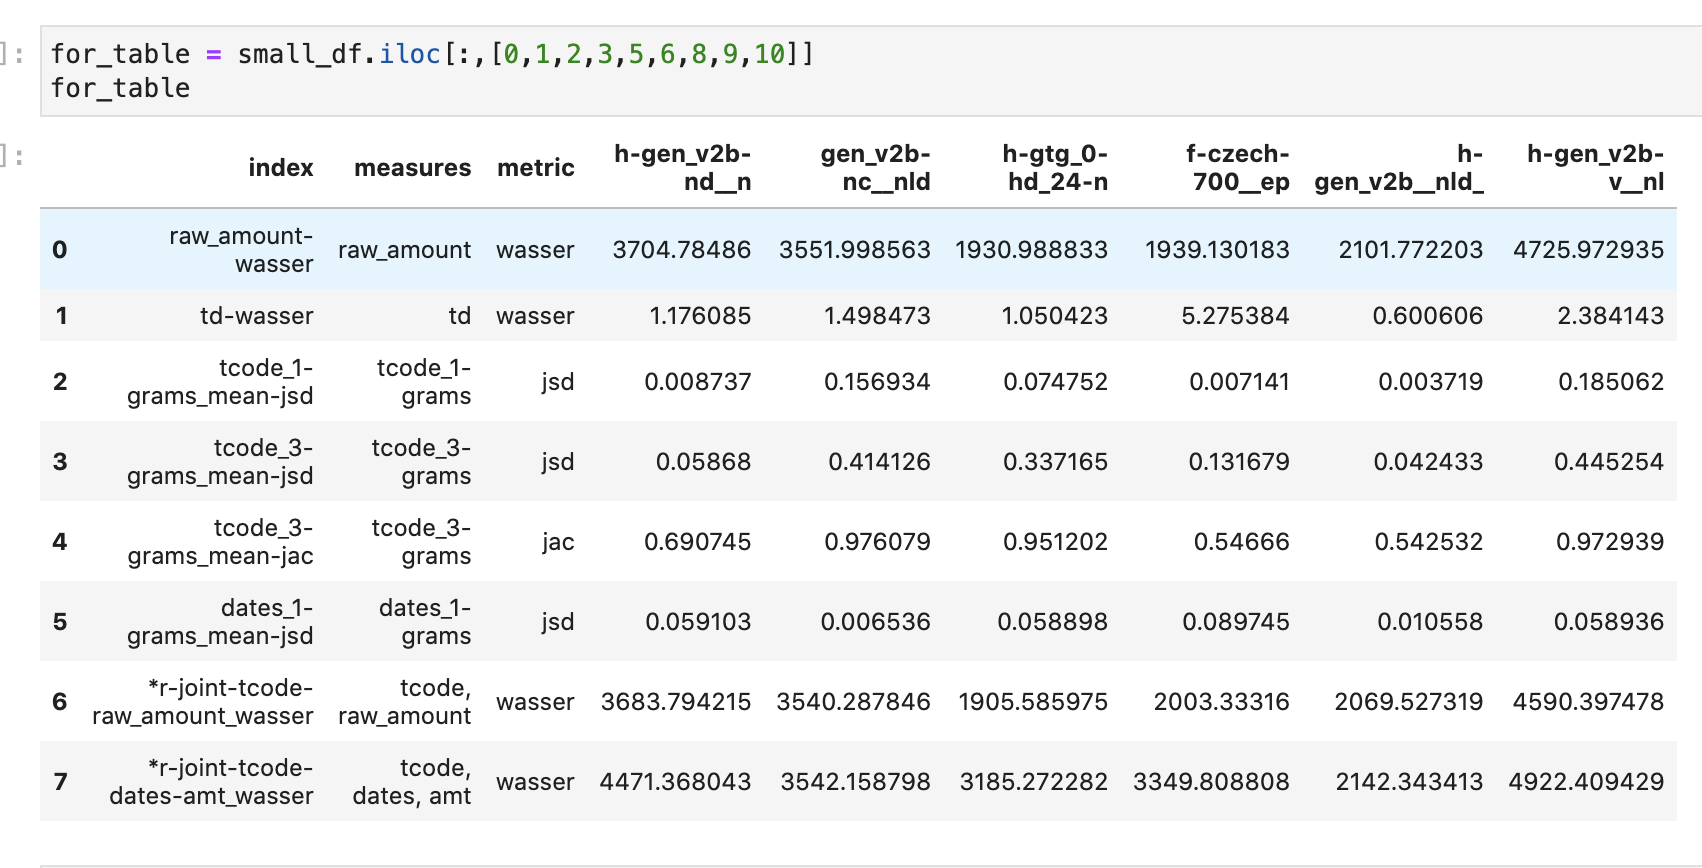

In [30]:
"raw_amount-wasser", "td-wasser", 

('raw_amount-wasser', 'td-wasser')

In [31]:
for_table.set_index('index')

measures  metric h-gen_v2b-nd__n  \
index                                                                         
raw_amount-wasser                        raw_amount  wasser      3704.78486   
td-wasser                                        td  wasser        1.176085   
tcode_1-grams_mean-jsd                tcode_1-grams     jsd        0.008737   
tcode_3-grams_mean-jsd                tcode_3-grams     jsd         0.05868   
tcode_3-grams_mean-jac                tcode_3-grams     jac        0.690745   
dates_1-grams_mean-jsd                dates_1-grams     jsd        0.059103   
*r-joint-tcode-raw_amount_wasser  tcode, raw_amount  wasser     3683.794215   
*r-joint-tcode-dates-amt_wasser   tcode, dates, amt  wasser     4471.368043   

                                 h-gen_v2b-nc__n h-gtg_0-hd_24-n  \
index                                                              
raw_amount-wasser                    3580.385345     1930.988833   
td-wasser                               1.481053        1.050423   
tcode_1-grams_mean-jsd                  0.157778        0.074752   
tcode_3-grams_mean-jsd                  0.411364        0.337165   
tcode_3-grams_mean-jac                  0.973803        0.951202   
dates_1-grams_mean-jsd                   0.00619        0.058898   
*r-joint-tcode-raw_amount_wasser     3566.945032     1905.585975   
*r-joint-tcode-dates-amt_wasser      3574.871387     3185.272282   

                                 f-czech-700__ep h-gen_v2b__nld_  \
index                                                              
raw_amount-wasser                    1939.130183     2101.772203   
td-wasser                               5.275384        0.600606   
tcode_1-grams_mean-jsd                  0.007141        0.003719   
tcode_3-grams_mean-jsd                  0.131679        0.042433   
tcode_3-grams_mean-jac                   0.54666        0.542532   
dates_1-grams_mean-jsd                  0.089745        0.010558   
*r-joint-tcode-raw_amount_wasser      2003.33316     2069.527319   
*r-joint-tcode-dates-amt_wasser      3349.808808     2142.343413   

                                 h-gen_v2b-v__nl  
index                                             
raw_amount-wasser                    4725.972935  
td-wasser                               2.384143  
tcode_1-grams_mean-jsd                  0.185062  
tcode_3-grams_mean-jsd                  0.445254  
tcode_3-grams_mean-jac                  0.972939  
dates_1-grams_mean-jsd                  0.058936  
*r-joint-tcode-raw_amount_wasser     4590.397478  
*r-joint-tcode-dates-amt_wasser      4922.409429

In [32]:
for_table.iloc[:, 3:]

h-gen_v2b-nd__n h-gen_v2b-nc__n h-gtg_0-hd_24-n f-czech-700__ep  \
0      3704.78486     3580.385345     1930.988833     1939.130183   
1        1.176085        1.481053        1.050423        5.275384   
2        0.008737        0.157778        0.074752        0.007141   
3         0.05868        0.411364        0.337165        0.131679   
4        0.690745        0.973803        0.951202         0.54666   
5        0.059103         0.00619        0.058898        0.089745   
6     3683.794215     3566.945032     1905.585975      2003.33316   
7     4471.368043     3574.871387     3185.272282     3349.808808   

  h-gen_v2b__nld_ h-gen_v2b-v__nl  
0     2101.772203     4725.972935  
1        0.600606        2.384143  
2        0.003719        0.185062  
3        0.042433        0.445254  
4        0.542532        0.972939  
5        0.010558        0.058936  
6     2069.527319     4590.397478  
7     2142.343413     4922.409429

In [33]:
for_table.set_index('index').iloc[:, 2:]

h-gen_v2b-nd__n h-gen_v2b-nc__n  \
index                                                              
raw_amount-wasser                     3704.78486     3580.385345   
td-wasser                               1.176085        1.481053   
tcode_1-grams_mean-jsd                  0.008737        0.157778   
tcode_3-grams_mean-jsd                   0.05868        0.411364   
tcode_3-grams_mean-jac                  0.690745        0.973803   
dates_1-grams_mean-jsd                  0.059103         0.00619   
*r-joint-tcode-raw_amount_wasser     3683.794215     3566.945032   
*r-joint-tcode-dates-amt_wasser      4471.368043     3574.871387   

                                 h-gtg_0-hd_24-n f-czech-700__ep  \
index                                                              
raw_amount-wasser                    1930.988833     1939.130183   
td-wasser                               1.050423        5.275384   
tcode_1-grams_mean-jsd                  0.074752        0.007141   
tcode_3-grams_mean-jsd                  0.337165        0.131679   
tcode_3-grams_mean-jac                  0.951202         0.54666   
dates_1-grams_mean-jsd                  0.058898        0.089745   
*r-joint-tcode-raw_amount_wasser     1905.585975      2003.33316   
*r-joint-tcode-dates-amt_wasser      3185.272282     3349.808808   

                                 h-gen_v2b__nld_ h-gen_v2b-v__nl  
index                                                             
raw_amount-wasser                    2101.772203     4725.972935  
td-wasser                               0.600606        2.384143  
tcode_1-grams_mean-jsd                  0.003719        0.185062  
tcode_3-grams_mean-jsd                  0.042433        0.445254  
tcode_3-grams_mean-jac                  0.542532        0.972939  
dates_1-grams_mean-jsd                  0.010558        0.058936  
*r-joint-tcode-raw_amount_wasser     2069.527319     4590.397478  
*r-joint-tcode-dates-amt_wasser      2142.343413     4922.409429

In [34]:
ds_ord = ['h-gen_v2b__nld_',
'h-gen_v2b-nd__n', 
'h-gen_v2b-nc__n',
'h-gen_v2b-v__nl',
'h-gtg_0-hd_24-n',
'f-czech-700__ep',]

In [35]:
for_table = for_table.set_index('index').iloc[:, 2:][ds_ord].T
for_table

index           raw_amount-wasser td-wasser tcode_1-grams_mean-jsd  \
h-gen_v2b__nld_       2101.772203  0.600606               0.003719   
h-gen_v2b-nd__n        3704.78486  1.176085               0.008737   
h-gen_v2b-nc__n       3580.385345  1.481053               0.157778   
h-gen_v2b-v__nl       4725.972935  2.384143               0.185062   
h-gtg_0-hd_24-n       1930.988833  1.050423               0.074752   
f-czech-700__ep       1939.130183  5.275384               0.007141   

index           tcode_3-grams_mean-jsd tcode_3-grams_mean-jac  \
h-gen_v2b__nld_               0.042433               0.542532   
h-gen_v2b-nd__n                0.05868               0.690745   
h-gen_v2b-nc__n               0.411364               0.973803   
h-gen_v2b-v__nl               0.445254               0.972939   
h-gtg_0-hd_24-n               0.337165               0.951202   
f-czech-700__ep               0.131679                0.54666   

index           dates_1-grams_mean-jsd *r-joint-tcode-raw_amount_wasser  \
h-gen_v2b__nld_               0.010558                      2069.527319   
h-gen_v2b-nd__n               0.059103                      3683.794215   
h-gen_v2b-nc__n                0.00619                      3566.945032   
h-gen_v2b-v__nl               0.058936                      4590.397478   
h-gtg_0-hd_24-n               0.058898                      1905.585975   
f-czech-700__ep               0.089745                       2003.33316   

index           *r-joint-tcode-dates-amt_wasser  
h-gen_v2b__nld_                     2142.343413  
h-gen_v2b-nd__n                     4471.368043  
h-gen_v2b-nc__n                     3574.871387  
h-gen_v2b-v__nl                     4922.409429  
h-gtg_0-hd_24-n                     3185.272282  
f-czech-700__ep                     3349.808808

In [36]:
for_table.columns

Index(['raw_amount-wasser', 'td-wasser', 'tcode_1-grams_mean-jsd',
       'tcode_3-grams_mean-jsd', 'tcode_3-grams_mean-jac',
       'dates_1-grams_mean-jsd', '*r-joint-tcode-raw_amount_wasser',
       '*r-joint-tcode-dates-amt_wasser'],
      dtype='object', name='index')

In [37]:
use_metrics =  ['raw_amount-wasser', 'td-wasser', 'tcode_1-grams_mean-jsd',
       'tcode_3-grams_mean-jsd', 
       'dates_1-grams_mean-jsd', '*r-joint-tcode-raw_amount_wasser',
       '*r-joint-tcode-dates-amt_wasser']
use_metrics

['raw_amount-wasser',
 'td-wasser',
 'tcode_1-grams_mean-jsd',
 'tcode_3-grams_mean-jsd',
 'dates_1-grams_mean-jsd',
 '*r-joint-tcode-raw_amount_wasser',
 '*r-joint-tcode-dates-amt_wasser']

In [38]:
for_table[use_metrics]

index           raw_amount-wasser td-wasser tcode_1-grams_mean-jsd  \
h-gen_v2b__nld_       2101.772203  0.600606               0.003719   
h-gen_v2b-nd__n        3704.78486  1.176085               0.008737   
h-gen_v2b-nc__n       3580.385345  1.481053               0.157778   
h-gen_v2b-v__nl       4725.972935  2.384143               0.185062   
h-gtg_0-hd_24-n       1930.988833  1.050423               0.074752   
f-czech-700__ep       1939.130183  5.275384               0.007141   

index           tcode_3-grams_mean-jsd dates_1-grams_mean-jsd  \
h-gen_v2b__nld_               0.042433               0.010558   
h-gen_v2b-nd__n                0.05868               0.059103   
h-gen_v2b-nc__n               0.411364                0.00619   
h-gen_v2b-v__nl               0.445254               0.058936   
h-gtg_0-hd_24-n               0.337165               0.058898   
f-czech-700__ep               0.131679               0.089745   

index           *r-joint-tcode-raw_amount_wasser  \
h-gen_v2b__nld_                      2069.527319   
h-gen_v2b-nd__n                      3683.794215   
h-gen_v2b-nc__n                      3566.945032   
h-gen_v2b-v__nl                      4590.397478   
h-gtg_0-hd_24-n                      1905.585975   
f-czech-700__ep                       2003.33316   

index           *r-joint-tcode-dates-amt_wasser  
h-gen_v2b__nld_                     2142.343413  
h-gen_v2b-nd__n                     4471.368043  
h-gen_v2b-nc__n                     3574.871387  
h-gen_v2b-v__nl                     4922.409429  
h-gtg_0-hd_24-n                     3185.272282  
f-czech-700__ep                     3349.808808

In [39]:
def round_to_digits(x, max_digits = 4):
    max_digits -= 1 # leading / trailing 0
    digits_leftof_dot = max(0, np.floor(np.log10(x)) + 1)
    round_to = max(0, max_digits - digits_leftof_dot)
    print("round to", round_to)
    return round(x, int(round_to))

In [40]:
for x in [1000.345, 1234, 9999.352534, 123, 1.36478572, 0.345245449, 0.0054256454]:
    print(x, "\t\t\t" ,np.floor(np.log10(x)) + 1)

1000.345 			 4.0
1234 			 4.0
9999.352534 			 4.0
123 			 3.0
1.36478572 			 1.0
0.345245449 			 0.0
0.0054256454 			 -2.0


In [41]:
for x in [1000.345, 1234, 9999.352534, 123, 1.36478572, 0.345245449, 0.0054256454]:
    print(x, "\t\t\t" ,round_to_digits(x))

round to 0
1000.345 			 1000.0
round to 0
1234 			 1234
round to 0
9999.352534 			 9999.0
round to 0
123 			 123
round to 2.0
1.36478572 			 1.36
round to 3
0.345245449 			 0.345
round to 3
0.0054256454 			 0.005


In [42]:
digits_leftof_dot = max(0, np.floor(np.log10(x)) + 1)
max_digits = 4
round_to = max(0, max_digits - digits_leftof_dot)
round(x, round_to)

0.0054

In [43]:
round(1232.4232, 0)

1232.0

In [44]:
final_table = for_table[use_metrics].copy()
for col in final_table.columns:
    final_table[col] = final_table[col].apply(round_to_digits)
    
final_table

round to 0
round to 0
round to 0
round to 0
round to 0
round to 0
round to 3
round to 2.0
round to 2.0
round to 2.0
round to 2.0
round to 2.0
round to 3
round to 3
round to 3
round to 3
round to 3
round to 3
round to 3
round to 3
round to 3
round to 3
round to 3
round to 3
round to 3
round to 3
round to 3
round to 3
round to 3
round to 3
round to 0
round to 0
round to 0
round to 0
round to 0
round to 0
round to 0
round to 0
round to 0
round to 0
round to 0
round to 0


index            raw_amount-wasser  td-wasser  tcode_1-grams_mean-jsd  \
h-gen_v2b__nld_             2102.0      0.601                   0.004   
h-gen_v2b-nd__n             3705.0      1.180                   0.009   
h-gen_v2b-nc__n             3580.0      1.480                   0.158   
h-gen_v2b-v__nl             4726.0      2.380                   0.185   
h-gtg_0-hd_24-n             1931.0      1.050                   0.075   
f-czech-700__ep             1939.0      5.280                   0.007   

index            tcode_3-grams_mean-jsd  dates_1-grams_mean-jsd  \
h-gen_v2b__nld_                   0.042                   0.011   
h-gen_v2b-nd__n                   0.059                   0.059   
h-gen_v2b-nc__n                   0.411                   0.006   
h-gen_v2b-v__nl                   0.445                   0.059   
h-gtg_0-hd_24-n                   0.337                   0.059   
f-czech-700__ep                   0.132                   0.090   

index            *r-joint-tcode-raw_amount_wasser  \
h-gen_v2b__nld_                            2070.0   
h-gen_v2b-nd__n                            3684.0   
h-gen_v2b-nc__n                            3567.0   
h-gen_v2b-v__nl                            4590.0   
h-gtg_0-hd_24-n                            1906.0   
f-czech-700__ep                            2003.0   

index            *r-joint-tcode-dates-amt_wasser  
h-gen_v2b__nld_                           2142.0  
h-gen_v2b-nd__n                           4471.0  
h-gen_v2b-nc__n                           3575.0  
h-gen_v2b-v__nl                           4922.0  
h-gtg_0-hd_24-n                           3185.0  
f-czech-700__ep                           3350.0

In [46]:
final_table.to_clipboard()

# * Almost done table

In [47]:
small_df = final_rank_df[final_rank_df["index"].apply(lambda x: x in filter_list)].reset_index(drop=True)
small_df.columns =  [shortname(lbl) for lbl in small_df]
small_df

index           measures  metric  \
0                 raw_amount-wasser         raw_amount  wasser   
1                         td-wasser                 td  wasser   
2            tcode_1-grams_mean-jsd      tcode_1-grams     jsd   
3            tcode_3-grams_mean-jsd      tcode_3-grams     jsd   
4            tcode_3-grams_mean-jac      tcode_3-grams     jac   
5            dates_1-grams_mean-jsd      dates_1-grams     jsd   
6  *r-joint-tcode-raw_amount_wasser  tcode, raw_amount  wasser   
7   *r-joint-tcode-dates-amt_wasser  tcode, dates, amt  wasser   

   h-gen_v2b-nd__n  f-czech-700__ep  gen_v2b-nc__nld  h-gtg_0-hd_24-n  \
0              7.0              3.0              5.0              1.0   
1              4.0              8.0              6.0              3.0   
2              4.0              3.0              6.0              5.0   
3              2.0              4.0              7.0              5.0   
4              4.0              3.0              8.0              5.0   
5              7.0              8.0              3.0              5.0   
6              7.0              3.0              5.0              1.0   
7              7.0              3.0              5.0              2.0   

   h-gen_v2a__nld_  h-gen_v2b-nc__n  f-czech-700__ep  h-gen_v2b__nld_  \
0              9.0              6.0              2.0              4.0   
1              2.0              5.0              9.0              1.0   
2              9.0              7.0              2.0              1.0   
3              9.0              6.0              3.0              1.0   
4              9.0              7.0              2.0              1.0   
5              1.0              2.0              9.0              4.0   
6              9.0              6.0              2.0              4.0   
7              9.0              6.0              4.0              1.0   

   h-gen_v2b-v__nl  
0              8.0  
1              7.0  
2              8.0  
3              8.0  
4              6.0  
5              6.0  
6              8.0  
7              8.0

In [39]:
small_df.iloc[:,[0,1,2,3,5,6,8,9,10]]

index           measures  metric  \
0                raw_amount-wasser         raw_amount  wasser   
1                        td-wasser                 td  wasser   
2           tcode_1-grams_mean-jsd      tcode_1-grams     jsd   
3           tcode_3-grams_mean-jsd      tcode_3-grams     jsd   
4           tcode_3-grams_mean-jac      tcode_3-grams     jac   
5           dates_1-grams_mean-jsd      dates_1-grams     jsd   
6  *r-joint-tcode-dates-amt_wasser  tcode, dates, amt  wasser   

   h-gen_v2b-nd__n  gen_v2b-nc__nld  h-gtg_0-hd_24-n  f-czech-700__ep  \
0              6.0              5.0              1.0              2.0   
1              4.0              5.0              3.0              8.0   
2              4.0              6.0              5.0              2.0   
3              2.0              6.0              5.0              3.0   
4              4.0              7.0              5.0              2.0   
5              6.0              2.0              4.0              8.0   
6              6.0              5.0              2.0              4.0   

   h-gen_v2b__nld_  h-gen_v2b-v__nl  
0              4.0              7.0  
1              1.0              6.0  
2              1.0              7.0  
3              1.0              7.0  
4              1.0              6.0  
5              3.0              5.0  
6              1.0              7.0

In [40]:
small_df.iloc[:,[3,5,6,8,9,10]].rank(axis=1)

h-gen_v2b-nd__n  gen_v2b-nc__nld  h-gtg_0-hd_24-n  f-czech-700__ep  \
0              5.0              4.0              1.0              2.0   
1              3.0              4.0              2.0              6.0   
2              3.0              5.0              4.0              2.0   
3              2.0              5.0              4.0              3.0   
4              3.0              6.0              4.0              2.0   
5              5.0              1.0              3.0              6.0   
6              5.0              4.0              2.0              3.0   

   h-gen_v2b__nld_  h-gen_v2b-v__nl  
0              3.0              6.0  
1              1.0              5.0  
2              1.0              6.0  
3              1.0              6.0  
4              1.0              5.0  
5              2.0              4.0  
6              1.0              6.0

# Select single 'best'  
Here we are considering the 'best' as the dataset with the highest average rank on important metrics

In [25]:
x_labels = [fname_map[x].replace("generated_data/", "") for x in value_cols]
short_labels_2 = [x[10:30] + "--" + x[50:66] for x in x_labels]
short_labels_2

['nd__nld_4-dm_128-nh_--am-lwi_0-bs_64--',
 '0__epoch-1000_bs-50_--_epoch_id-499.cs',
 '__nld_4-dm_128-nh_2----lwi_0-bs_64--vf',
 '_24-nl_4-bs_32--len_--',
 '_nld_4-dm_128-nh_2-i--lwi_0-bs_64--vf1',
 'nc__nld_4-dm_128-nh_--am-lwi_0-bs_64--',
 '0__epoch-1000_bs-200--5_epoch_id-299.c',
 '_nld_4-dm_128-nh_2-i--lwi_0-bs_64--vf1',
 'v__nld_4-dm_128-nh_2--m-lwi_0-bs_64--v']

In [26]:
result_df = small_df[value_cols].mean(axis=0).reset_index()
result_df.rename(columns={0:"ave_rank"}, inplace=True)
result_df["filename"] = result_df["index"].apply(lambda x: fname_map[x].split("/")[1])

result_df["short_labels_2"] = short_labels_2
result_df

index  ave_rank                                           filename  \
0  value_0       4.3  h-gen_v2b-nd__nld_4-dm_128-nh_2-i_2-dr_0__1-op...   
1  value_1       5.6  f-czech-700__epoch-1000_bs-50_lr-g0001-d0001-a...   
2  value_2       5.0  gen_v2b-nc__nld_4-dm_128-nh_2-i_1-dr_0__1-opt_...   
3  value_3       4.8               h-gtg_0-hd_24-nl_4-bs_32--len_80.csv   
4  value_4       6.6  h-gen_v2a__nld_4-dm_128-nh_2-i_1-dr_0__1-opt_a...   
5  value_5       4.6  h-gen_v2b-nc__nld_4-dm_128-nh_2-i_1-dr_0__1-op...   
6  value_6       5.3  f-czech-700__epoch-1000_bs-200_lr-g0005-d0005-...   
7  value_7       1.7  h-gen_v2b__nld_4-dm_128-nh_2-i_0-dr_0__1-opt_a...   
8  value_8       7.1  h-gen_v2b-v__nld_4-dm_128-nh_2-i_0-dr_0__1-opt...   

                           short_labels_2  
0  nd__nld_4-dm_128-nh_--am-lwi_0-bs_64--  
1  0__epoch-1000_bs-50_--_epoch_id-499.cs  
2  __nld_4-dm_128-nh_2----lwi_0-bs_64--vf  
3                  _24-nl_4-bs_32--len_--  
4  _nld_4-dm_128-nh_2-i--lwi_0-bs_64--vf1  
5  nc__nld_4-dm_128-nh_--am-lwi_0-bs_64--  
6  0__epoch-1000_bs-200--5_epoch_id-299.c  
7  _nld_4-dm_128-nh_2-i--lwi_0-bs_64--vf1  
8  v__nld_4-dm_128-nh_2--m-lwi_0-bs_64--v

In [27]:
# best_col = result_df.iloc[result_df[0].argmin()]["index"]
best_col = result_df.iloc[result_df["ave_rank"].argmin()]["index"]

print("Best result is from:", fname_map[best_col])

Best result is from: generated_data/h-gen_v2b__nld_4-dm_128-nh_2-i_0-dr_0__1-opt_adam-lwi_0-bs_64--vf1-len_80-v2.csv


In [28]:
result_df["filename"] = result_df["index"].apply(lambda x: fname_map[x].split("/")[1])
result_df.sort_values(by="ave_rank")

index  ave_rank                                           filename  \
7  value_7       1.7  h-gen_v2b__nld_4-dm_128-nh_2-i_0-dr_0__1-opt_a...   
0  value_0       4.3  h-gen_v2b-nd__nld_4-dm_128-nh_2-i_2-dr_0__1-op...   
5  value_5       4.6  h-gen_v2b-nc__nld_4-dm_128-nh_2-i_1-dr_0__1-op...   
3  value_3       4.8               h-gtg_0-hd_24-nl_4-bs_32--len_80.csv   
2  value_2       5.0  gen_v2b-nc__nld_4-dm_128-nh_2-i_1-dr_0__1-opt_...   
6  value_6       5.3  f-czech-700__epoch-1000_bs-200_lr-g0005-d0005-...   
1  value_1       5.6  f-czech-700__epoch-1000_bs-50_lr-g0001-d0001-a...   
4  value_4       6.6  h-gen_v2a__nld_4-dm_128-nh_2-i_1-dr_0__1-opt_a...   
8  value_8       7.1  h-gen_v2b-v__nld_4-dm_128-nh_2-i_0-dr_0__1-opt...   

                           short_labels_2  
7  _nld_4-dm_128-nh_2-i--lwi_0-bs_64--vf1  
0  nd__nld_4-dm_128-nh_--am-lwi_0-bs_64--  
5  nc__nld_4-dm_128-nh_--am-lwi_0-bs_64--  
3                  _24-nl_4-bs_32--len_--  
2  __nld_4-dm_128-nh_2----lwi_0-bs_64--vf  
6  0__epoch-1000_bs-200--5_epoch_id-299.c  
1  0__epoch-1000_bs-50_--_epoch_id-499.cs  
4  _nld_4-dm_128-nh_2-i--lwi_0-bs_64--vf1  
8  v__nld_4-dm_128-nh_2--m-lwi_0-bs_64--v

# New

In [29]:
full_vals_df = vals_df.copy()
full_vals_df

index           measures      metric  \
0                      raw_amount-ks         raw_amount          ks   
1                  raw_amount-wasser         raw_amount      wasser   
2                              td-ks                 td          ks   
3                          td-wasser                 td      wasser   
4             codes_1-grams_mean-jsd      codes_1-grams         jsd   
5             codes_1-grams_mean-jac      codes_1-grams         jac   
6      codes_1-grams_mean-coverage_r      codes_1-grams  coverage_r   
7      codes_1-grams_mean-coverage_g      codes_1-grams  coverage_g   
8             codes_1-grams_mean-NED      codes_1-grams         NED   
9             codes_3-grams_mean-jsd      codes_3-grams         jsd   
10            codes_3-grams_mean-jac      codes_3-grams         jac   
11     codes_3-grams_mean-coverage_r      codes_3-grams  coverage_r   
12     codes_3-grams_mean-coverage_g      codes_3-grams  coverage_g   
13            codes_3-grams_mean-NED      codes_3-grams         NED   
14            tcode_1-grams_mean-jsd      tcode_1-grams         jsd   
15            tcode_1-grams_mean-jac      tcode_1-grams         jac   
16     tcode_1-grams_mean-coverage_r      tcode_1-grams  coverage_r   
17     tcode_1-grams_mean-coverage_g      tcode_1-grams  coverage_g   
18            tcode_1-grams_mean-NED      tcode_1-grams         NED   
19            tcode_3-grams_mean-jsd      tcode_3-grams         jsd   
20            tcode_3-grams_mean-jac      tcode_3-grams         jac   
21     tcode_3-grams_mean-coverage_r      tcode_3-grams  coverage_r   
22     tcode_3-grams_mean-coverage_g      tcode_3-grams  coverage_g   
23            tcode_3-grams_mean-NED      tcode_3-grams         NED   
24            dates_1-grams_mean-jsd      dates_1-grams         jsd   
25            dates_1-grams_mean-jac      dates_1-grams         jac   
26     dates_1-grams_mean-coverage_r      dates_1-grams  coverage_r   
27     dates_1-grams_mean-coverage_g      dates_1-grams  coverage_g   
28            dates_1-grams_mean-NED      dates_1-grams         NED   
29            dates_3-grams_mean-jsd      dates_3-grams         jsd   
30            dates_3-grams_mean-jac      dates_3-grams         jac   
31     dates_3-grams_mean-coverage_r      dates_3-grams  coverage_r   
32     dates_3-grams_mean-coverage_g      dates_3-grams  coverage_g   
33            dates_3-grams_mean-NED      dates_3-grams         NED   
34     joint-codes-raw_amount_wasser  codes, raw_amount      wasser   
35         joint-codes-raw_amount_ks  codes, raw_amount          ks   
36  *r-joint-tcode-raw_amount_wasser  tcode, raw_amount      wasser   
37      *r-joint-tcode-raw_amount_ks  tcode, raw_amount          ks   
38             joint-codes-dates_jsd       codes, dates         jsd   
39             joint-codes-dates_jac       codes, dates         jac   
40      joint-codes-dates_coverage_r       codes, dates  coverage_r   
41      joint-codes-dates_coverage_g       codes, dates  coverage_g   
42      joint-codes-dates-amt_wasser  codes, dates, amt      wasser   
43   *r-joint-codes-dates-amt_wasser  codes, dates, amt      wasser   
44          joint-codes-dates-amt_ks  codes, dates, amt          ks   
45       *r-joint-codes-dates-amt_ks  codes, dates, amt          ks   
46            joint-tcodes-dates_jsd       tcode, dates         jsd   
47            joint-tcodes-dates_jac       tcode, dates         jac   
48     joint-tcodes-dates_coverage_r       tcode, dates  coverage_r   
49     joint-tcodes-dates_coverage_g       tcode, dates  coverage_g   
50   *r-joint-tcode-dates-amt_wasser  tcode, dates, amt      wasser   
51       *r-joint-tcode-dates-amt_ks  tcode, dates, amt          ks   

        value_0      value_1      value_2      value_3      value_4  \
0      0.161694     0.183205     0.156864     0.105645     0.616628   
1    3704.78486  2048.765521  3551.998563  1930.988833  5807.966294   
2      0.140243     0.764744      0.11228     0.178425

In [21]:
vals_df[value_cols]

value_0      value_1      value_2      value_3      value_4  \
0      0.161694     0.183205     0.156864     0.105645     0.616628   
1    3704.78486  2048.765521  3551.998563  1930.988833  5807.966294   
2      0.140243     0.764744      0.11228     0.178425     0.032921   
3      1.176085     5.273062     1.498473     1.050423     0.851423   
4      0.001866     0.002746     0.003459     0.021414     0.337494   
5           0.0          0.0          0.0     0.111111     0.619048   
6           1.0          1.0          1.0          1.0     0.690476   
7           1.0          1.0          1.0     0.888889     0.690476   
8      0.019418     0.063346     0.024028     0.140918     0.015173   
9      0.022299     0.061542     0.039616     0.137375      0.46394   
10      0.11594     0.184712     0.131361     0.375292     0.665712   
11     0.849909     0.849909     0.849909     0.849909     0.412293   
12     0.854481     0.832076     0.962963     0.609053     0.425049   
13     0.170046      0.14079     0.017108      0.27569    -0.035997   
14     0.008737     0.007311     0.156934     0.074752     0.693147   
15     0.794872          0.0     0.851852     0.826087          1.0   
16     0.205128          1.0     0.148148     0.347826          0.5   
17          1.0          1.0          1.0     0.826087          0.5   
18     0.073951      0.13627    -1.083243     0.181571     0.046267   
19      0.05868     0.143343     0.414126     0.337165     0.693147   
20     0.690745     0.561458     0.976079     0.951202          1.0   
21     0.003015     0.349365     0.001136     0.014702     0.043671   
22     0.006762     0.324951     0.038552     0.029681     0.062012   
23     0.390601     0.382679    -2.941865     0.225103    -0.041618   
24     0.059103      0.07474     0.006536     0.058898     0.006064   
25          0.0          0.0          0.0          0.0          0.0   
26          1.0          1.0          1.0          1.0          1.0   
27          1.0          1.0          1.0          1.0          1.0   
28     -0.27745    -0.220194     -0.01207    -0.277383    -0.017622   
29     0.188882     0.453922     0.072589     0.178518      0.03574   
30      0.38865     0.895163      0.38958     0.467262     0.340898   
31     0.418409     0.418409     0.418409     0.418409     0.418409   
32     0.441636     0.043181     0.345555     0.519935     0.422747   
33    -0.788156     2.198651     0.264366    -0.623875     0.050741   
34  3743.898891  2771.503108  4119.178323  2406.631775  4862.753519   
35     0.321596     0.363936     0.264675     0.302119     0.672511   
36  3686.092399  2065.278395  3504.596409  1913.550321  5794.460976   
37     0.233426     0.321778     0.219521     0.199919     0.674857   
38      0.10593     0.122669     0.019769     0.121276     0.394283   
39     0.148895     0.147611     0.148753     0.252665     0.623713   
40     0.851105     0.851105     0.851105     0.851105     0.607719   
41          1.0     0.997312     0.999701     0.847101     0.687404   
42  3975.792976   3583.44508  4177.183992  3229.575345  4750.483351   
43  4177.573575   3439.70933  4170.231658  3234.163428  5713.801373   
44     0.377858     0.428994      0.31834       0.3726     0.677927   
45     0.382594     0.417806     0.314224     0.376708     0.702961   
46     0.062532     0.079278      0.00921     0.062404     0.009323   
47          0.0          0.0          0.0          0.0          0.0   
48          1.0          1.0          1.0          1.0          1.0   
49          1.0          1.0          1.0          1.0          1.0   
50  4003.031347  3618.480297  3568.974976  3420.943629  5891.351274   
51     0.311903     0.396193     0.291869     0.309448     0.697689   

        value_5      value_6      value_7  
0      0.161744     0.081775     0.213238  
1   1939.130183  2101.772203  4725.972935  
2      0.767066     0.069934     0.233642  
3      5.275384     0.600606     2.384143  
4      0.002671     0.00

In [22]:
vals_df = vals_df[value_cols].copy()
vals_df

value_0      value_1      value_2      value_3      value_4  \
0      0.161694     0.183205     0.156864     0.105645     0.616628   
1    3704.78486  2048.765521  3551.998563  1930.988833  5807.966294   
2      0.140243     0.764744      0.11228     0.178425     0.032921   
3      1.176085     5.273062     1.498473     1.050423     0.851423   
4      0.001866     0.002746     0.003459     0.021414     0.337494   
5           0.0          0.0          0.0     0.111111     0.619048   
6           1.0          1.0          1.0          1.0     0.690476   
7           1.0          1.0          1.0     0.888889     0.690476   
8      0.019418     0.063346     0.024028     0.140918     0.015173   
9      0.022299     0.061542     0.039616     0.137375      0.46394   
10      0.11594     0.184712     0.131361     0.375292     0.665712   
11     0.849909     0.849909     0.849909     0.849909     0.412293   
12     0.854481     0.832076     0.962963     0.609053     0.425049   
13     0.170046      0.14079     0.017108      0.27569    -0.035997   
14     0.008737     0.007311     0.156934     0.074752     0.693147   
15     0.794872          0.0     0.851852     0.826087          1.0   
16     0.205128          1.0     0.148148     0.347826          0.5   
17          1.0          1.0          1.0     0.826087          0.5   
18     0.073951      0.13627    -1.083243     0.181571     0.046267   
19      0.05868     0.143343     0.414126     0.337165     0.693147   
20     0.690745     0.561458     0.976079     0.951202          1.0   
21     0.003015     0.349365     0.001136     0.014702     0.043671   
22     0.006762     0.324951     0.038552     0.029681     0.062012   
23     0.390601     0.382679    -2.941865     0.225103    -0.041618   
24     0.059103      0.07474     0.006536     0.058898     0.006064   
25          0.0          0.0          0.0          0.0          0.0   
26          1.0          1.0          1.0          1.0          1.0   
27          1.0          1.0          1.0          1.0          1.0   
28     -0.27745    -0.220194     -0.01207    -0.277383    -0.017622   
29     0.188882     0.453922     0.072589     0.178518      0.03574   
30      0.38865     0.895163      0.38958     0.467262     0.340898   
31     0.418409     0.418409     0.418409     0.418409     0.418409   
32     0.441636     0.043181     0.345555     0.519935     0.422747   
33    -0.788156     2.198651     0.264366    -0.623875     0.050741   
34  3743.898891  2771.503108  4119.178323  2406.631775  4862.753519   
35     0.321596     0.363936     0.264675     0.302119     0.672511   
36  3686.092399  2065.278395  3504.596409  1913.550321  5794.460976   
37     0.233426     0.321778     0.219521     0.199919     0.674857   
38      0.10593     0.122669     0.019769     0.121276     0.394283   
39     0.148895     0.147611     0.148753     0.252665     0.623713   
40     0.851105     0.851105     0.851105     0.851105     0.607719   
41          1.0     0.997312     0.999701     0.847101     0.687404   
42  3975.792976   3583.44508  4177.183992  3229.575345  4750.483351   
43  4177.573575   3439.70933  4170.231658  3234.163428  5713.801373   
44     0.377858     0.428994      0.31834       0.3726     0.677927   
45     0.382594     0.417806     0.314224     0.376708     0.702961   
46     0.062532     0.079278      0.00921     0.062404     0.009323   
47          0.0          0.0          0.0          0.0          0.0   
48          1.0          1.0          1.0          1.0          1.0   
49          1.0          1.0          1.0          1.0          1.0   
50  4003.031347  3618.480297  3568.974976  3420.943629  5891.351274   
51     0.311903     0.396193     0.291869     0.309448     0.697689   

        value_5      value_6      value_7  
0      0.161744     0.081775     0.213238  
1   1939.130183  2101.772203  4725.972935  
2      0.767066     0.069934     0.233642  
3      5.275384     0.600606     2.384143  
4      0.002671     0.00

In [23]:
from sklearn.preprocessing import scale

In [24]:
scaled_vals_df = pd.DataFrame.from_records(scale(vals_df.to_numpy(), axis=1))
scaled_vals_df

0             1             2             3             4  \
0  -3.054628e-01 -1.697164e-01 -3.359410e-01 -6.591552e-01  2.565402e+00   
1   3.466436e-01 -8.533848e-01  2.359276e-01 -9.387313e-01  1.870706e+00   
2  -5.214951e-01  1.691511e+00 -6.205873e-01 -3.861921e-01 -9.018070e-01   
3  -6.016603e-01  1.664756e+00 -4.233175e-01 -6.711753e-01 -7.812608e-01   
4  -4.204753e-01 -4.124472e-01 -4.059398e-01 -2.421652e-01  2.640977e+00   
5  -4.501159e-01 -4.501159e-01 -4.501159e-01  9.785129e-02  2.602844e+00   
6   3.779645e-01  3.779645e-01  3.779645e-01  3.779645e-01 -2.645751e+00   
7   5.070204e-01  5.070204e-01  5.070204e-01 -5.644189e-01 -2.477703e+00   
8  -7.777718e-01  3.165366e-01 -6.629253e-01  2.249007e+00 -8.835215e-01   
9  -6.013896e-01 -3.204360e-01 -4.774095e-01  2.224770e-01  2.560455e+00   
10 -6.602579e-01 -2.804171e-01 -5.750851e-01  7.721978e-01  2.376257e+00   
11  3.779645e-01  3.779645e-01  3.779645e-01  3.779645e-01 -2.645751e+00   
12  3.739669e-01  2.411567e-01  1.017012e+00 -1.080846e+00 -2.171567e+00   
13  7.011802e-01  4.048680e-01 -8.478010e-01  1.771155e+00 -1.385658e+00   
14 -6.090579e-01 -6.155714e-01  6.774164e-02 -3.075715e-01  2.516577e+00   
15  4.451925e-01 -1.697190e+00  5.987684e-01  5.293254e-01  9.980656e-01   
16 -7.494139e-01  1.638922e+00 -9.206208e-01 -3.206523e-01  1.365817e-01   
17  5.040151e-01  5.040151e-01  5.040151e-01 -5.365322e-01 -2.487558e+00   
18  5.095212e-01  6.391477e-01 -1.897501e+00  7.333759e-01  4.519380e-01   
19 -1.050870e+00 -6.546548e-01  6.125905e-01  2.524189e-01  1.918390e+00   
20 -4.473218e-01 -1.093808e+00  9.794672e-01  8.550692e-01  1.099081e+00   
21 -6.361723e-01  1.725288e+00 -6.489870e-01 -5.564943e-01 -3.589797e-01   
22 -7.313349e-01  1.542903e+00 -5.041156e-01 -5.675261e-01 -3.364419e-01   
23  7.151283e-01  7.087840e-01 -1.953679e+00  5.825890e-01  3.689850e-01   
24  4.375038e-01  9.430918e-01 -1.262218e+00  4.308755e-01 -1.277461e+00   
25  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
26  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
27  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
28 -9.977110e-01 -5.389062e-01  1.128836e+00 -9.971809e-01  1.084348e+00   
29 -1.153594e-01  1.563916e+00 -8.521821e-01 -1.810237e-01 -1.085655e+00   
30 -5.776763e-01  1.641712e+00 -5.736028e-01 -2.332246e-01 -7.869129e-01   
31  5.551115e-17  5.551115e-17  5.551115e-17  5.551115e-17  5.551115e-17   
32  6.752945e-01 -1.624236e+00  1.207992e-01  1.127166e+00  5.662832e-01   
33 -1.006523e+00  1.629183e+00 -7.772550e-02 -8.615531e-01 -2.662383e-01   
34  2.427179e-01 -6.550174e-01  5.891834e-01 -9.918739e-01  1.275667e+00   
35 -1.820747e-01  1.247188e-01 -5.945314e-01 -3.232139e-01  2.360692e+00   
36  3.309750e-01 -8.469961e-01  1.990678e-01 -9.572686e-01  1.863290e+00   
37 -3.869088e-01  1.765614e-01 -4.755902e-01 -6.006018e-01  2.428355e+00   
38 -2.090450e-01 -5.665390e-02 -9.934248e-01 -6.933247e-02  2.416036e+00   
39 -4.584014e-01 -4.666208e-01 -4.593091e-01  2.057477e-01  2.580519e+00   
40  3.779645e-01  3.779645e-01  3.779645e-01  3.779645e-01 -2.645751e+00   
41  5.843595e-01  5.591073e-01  5.815537e-01 -8.519467e-01 -2.352119e+00   
42  8.477795e-02 -3.262153e-01  2.957396e-01 -6.969019e-01  8.962836e-01   
43  2.372210e-01 -4.810776e-01  2.300738e-01 -6.811731e-01  1.732713e+00   
44 -2.078974e-01  1.961524e-01 -6.781767e-01 -2.494426e-01  2.163093e+00   
45 -1.548451e-01  1.099308e-01 -6.689467e-01 -1.991053e-01  2.254152e+00   
46  3.847954e-01  9.018407e-01 -1.261496e+00  3.808566e-01 -1.258005e+00   
47  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
48  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
49  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
50 -2.265185e-02 -3.422164e-01 -3.833556e-01 -5.063707e-01  1.546555e+00   
51 -4.456463e-01  1.429178e-01 -5.855329e-01 -4.627823e-01  2.2

In [25]:
scaled_vals_df.describe()

0          1          2          3          4          5  \
count  52.000000  52.000000  52.000000  52.000000  52.000000  52.000000   
mean   -0.098333   0.169659  -0.207470  -0.083663   0.399505   0.131357   
std     0.490517   0.831095   0.668120   0.679252   1.685627   0.897005   
min    -1.050870  -1.697190  -1.953679  -1.080846  -2.645751  -1.714489   
25%    -0.474175  -0.359774  -0.601045  -0.565196  -0.811065  -0.415101   
50%    -0.011326   0.054965  -0.206833  -0.190064   0.252783   0.000000   
75%     0.374966   0.520042   0.250881   0.283805   1.979566   0.507650   
max     0.715128   1.725288   1.128836   2.249007   2.640977   1.886664   

                  6          7  
count  5.200000e+01  52.000000  
mean  -4.822248e-01   0.171170  
std    7.309387e-01   0.708499  
min   -1.706181e+00  -1.541323  
25%   -1.067973e+00  -0.205252  
50%   -6.266845e-01   0.184775  
75%    1.387779e-17   0.566333  
max    1.497485e+00   1.854081

In [26]:
from matplotlib import pyplot as plt

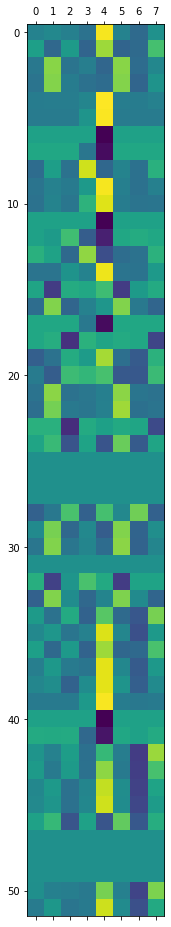

In [27]:
plt.matshow(scaled_vals_df)

Text(0.5, 0, "['value_0', 'value_1', 'value_2', 'value_3', 'value_4', 'value_5', 'value_6', 'value_7']")

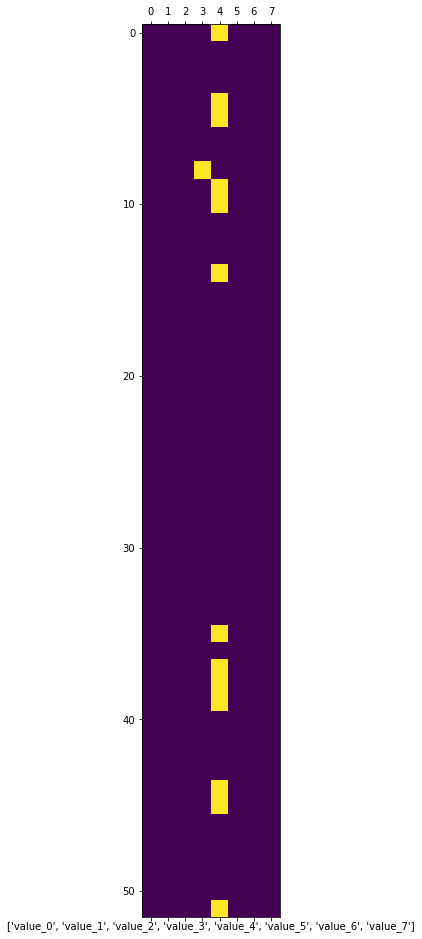

In [28]:
plt.matshow(scaled_vals_df > 2.0)
plt.xlabel(value_cols)

In [29]:
import seaborn as sns

<AxesSubplot:>

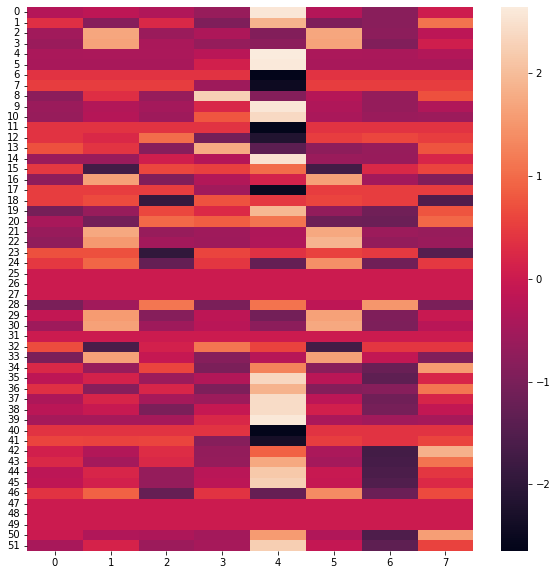

In [30]:
plt.figure(figsize=(10,10))
sns.heatmap(scaled_vals_df)

<AxesSubplot:>

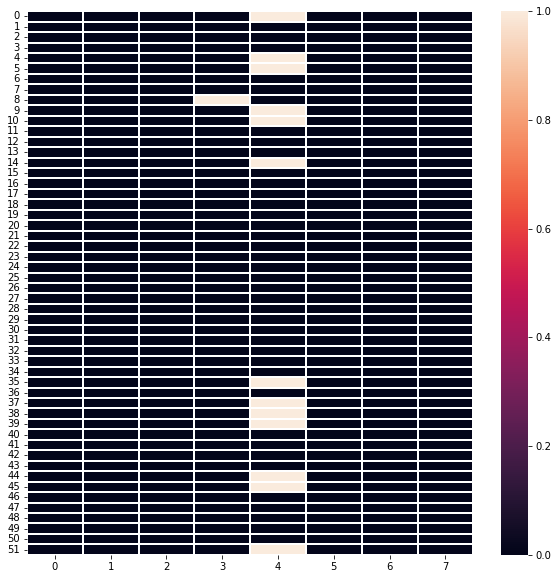

In [31]:
plt.figure(figsize=(10,10))
sns.heatmap(scaled_vals_df > 2.0, linewidths=0.1)

In [32]:
vals_df

value_0      value_1      value_2      value_3      value_4  \
0      0.161694     0.183205     0.156864     0.105645     0.616628   
1    3704.78486  2048.765521  3551.998563  1930.988833  5807.966294   
2      0.140243     0.764744      0.11228     0.178425     0.032921   
3      1.176085     5.273062     1.498473     1.050423     0.851423   
4      0.001866     0.002746     0.003459     0.021414     0.337494   
5           0.0          0.0          0.0     0.111111     0.619048   
6           1.0          1.0          1.0          1.0     0.690476   
7           1.0          1.0          1.0     0.888889     0.690476   
8      0.019418     0.063346     0.024028     0.140918     0.015173   
9      0.022299     0.061542     0.039616     0.137375      0.46394   
10      0.11594     0.184712     0.131361     0.375292     0.665712   
11     0.849909     0.849909     0.849909     0.849909     0.412293   
12     0.854481     0.832076     0.962963     0.609053     0.425049   
13     0.170046      0.14079     0.017108      0.27569    -0.035997   
14     0.008737     0.007311     0.156934     0.074752     0.693147   
15     0.794872          0.0     0.851852     0.826087          1.0   
16     0.205128          1.0     0.148148     0.347826          0.5   
17          1.0          1.0          1.0     0.826087          0.5   
18     0.073951      0.13627    -1.083243     0.181571     0.046267   
19      0.05868     0.143343     0.414126     0.337165     0.693147   
20     0.690745     0.561458     0.976079     0.951202          1.0   
21     0.003015     0.349365     0.001136     0.014702     0.043671   
22     0.006762     0.324951     0.038552     0.029681     0.062012   
23     0.390601     0.382679    -2.941865     0.225103    -0.041618   
24     0.059103      0.07474     0.006536     0.058898     0.006064   
25          0.0          0.0          0.0          0.0          0.0   
26          1.0          1.0          1.0          1.0          1.0   
27          1.0          1.0          1.0          1.0          1.0   
28     -0.27745    -0.220194     -0.01207    -0.277383    -0.017622   
29     0.188882     0.453922     0.072589     0.178518      0.03574   
30      0.38865     0.895163      0.38958     0.467262     0.340898   
31     0.418409     0.418409     0.418409     0.418409     0.418409   
32     0.441636     0.043181     0.345555     0.519935     0.422747   
33    -0.788156     2.198651     0.264366    -0.623875     0.050741   
34  3743.898891  2771.503108  4119.178323  2406.631775  4862.753519   
35     0.321596     0.363936     0.264675     0.302119     0.672511   
36  3686.092399  2065.278395  3504.596409  1913.550321  5794.460976   
37     0.233426     0.321778     0.219521     0.199919     0.674857   
38      0.10593     0.122669     0.019769     0.121276     0.394283   
39     0.148895     0.147611     0.148753     0.252665     0.623713   
40     0.851105     0.851105     0.851105     0.851105     0.607719   
41          1.0     0.997312     0.999701     0.847101     0.687404   
42  3975.792976   3583.44508  4177.183992  3229.575345  4750.483351   
43  4177.573575   3439.70933  4170.231658  3234.163428  5713.801373   
44     0.377858     0.428994      0.31834       0.3726     0.677927   
45     0.382594     0.417806     0.314224     0.376708     0.702961   
46     0.062532     0.079278      0.00921     0.062404     0.009323   
47          0.0          0.0          0.0          0.0          0.0   
48          1.0          1.0          1.0          1.0          1.0   
49          1.0          1.0          1.0          1.0          1.0   
50  4003.031347  3618.480297  3568.974976  3420.943629  5891.351274   
51     0.311903     0.396193     0.291869     0.309448     0.697689   

        value_5      value_6      value_7  
0      0.161744     0.081775     0.213238  
1   1939.130183  2101.772203  4725.972935  
2      0.767066     0.069934     0.233642  
3      5.275384     0.600606     2.384143  
4      0.002671     0.00

## Interesting plots

#### Score outliers

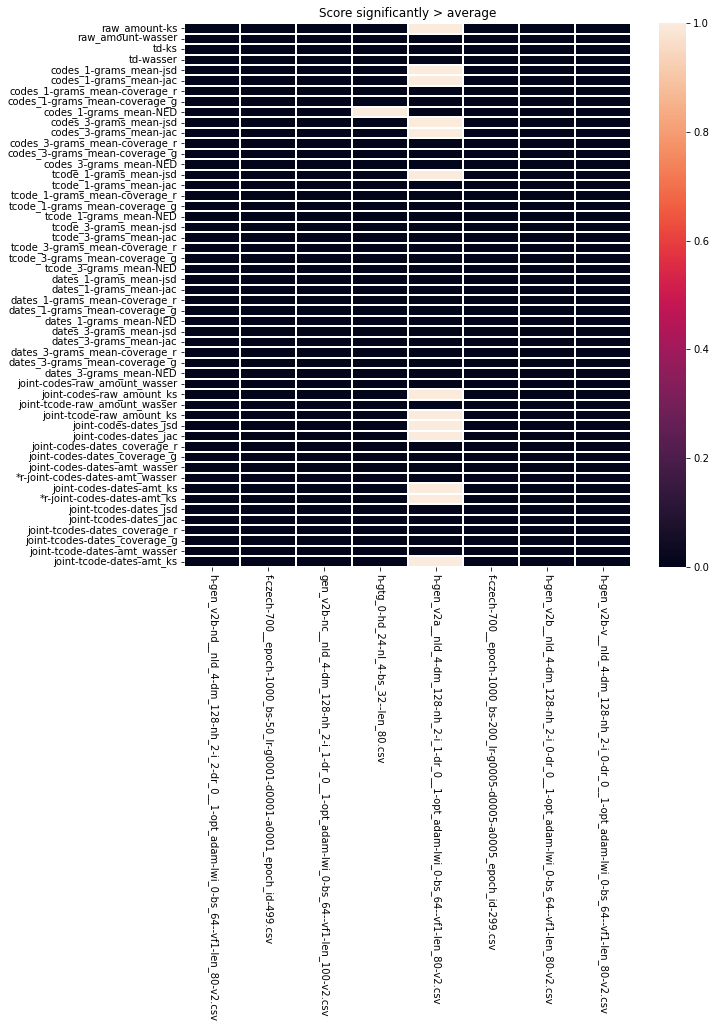

In [33]:
plt.figure(figsize=(10,10))
sns.heatmap(scaled_vals_df > 2.0, linewidths=0.1, xticklabels=x_labels, yticklabels=full_vals_df["index"])
plt.xticks(rotation=270)
plt.title(f"Score significantly > average")
plt.show()

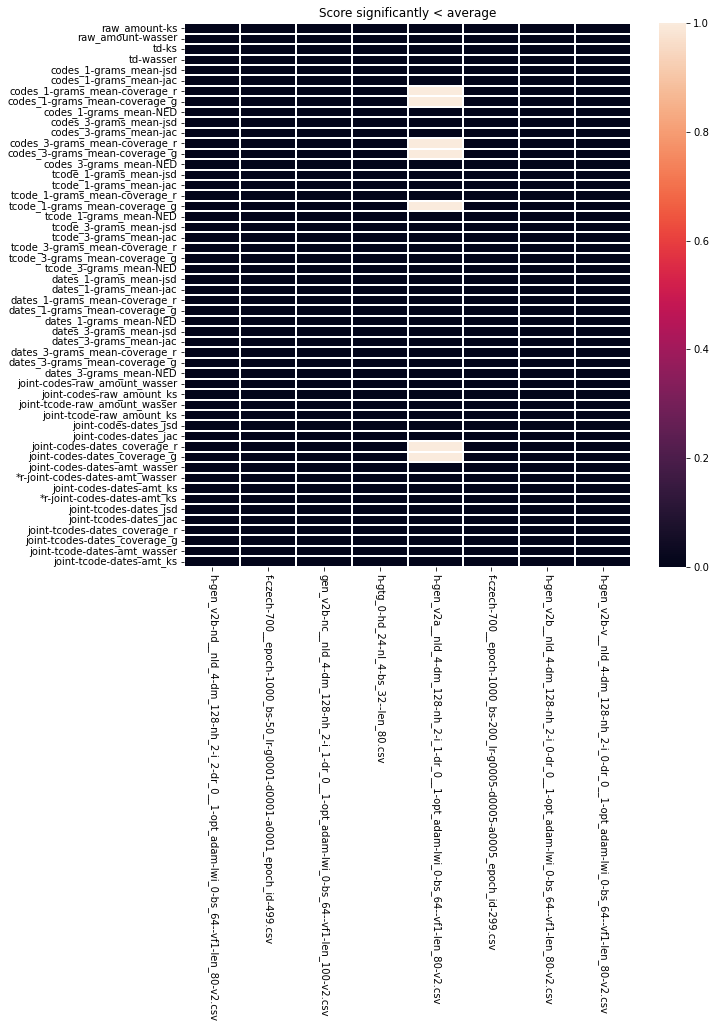

In [34]:
plt.figure(figsize=(10,10))
sns.heatmap(scaled_vals_df < -2.0, linewidths=0.1, xticklabels=x_labels, yticklabels=full_vals_df["index"])
plt.xticks(rotation=270)
plt.title(f"Score significantly < average")
plt.show()

#### Visualize ranks

In [35]:
final_rank_df

index           measures      metric  value_0  \
0                     raw_amount-ks         raw_amount          ks      4.0   
1                 raw_amount-wasser         raw_amount      wasser      6.0   
2                             td-ks                 td          ks      4.0   
3                         td-wasser                 td      wasser      4.0   
4            codes_1-grams_mean-jsd      codes_1-grams         jsd      2.0   
5            codes_1-grams_mean-jac      codes_1-grams         jac      3.5   
6     codes_1-grams_mean-coverage_r      codes_1-grams  coverage_r      5.0   
7     codes_1-grams_mean-coverage_g      codes_1-grams  coverage_g      5.5   
8            codes_1-grams_mean-NED      codes_1-grams         NED      2.0   
9            codes_3-grams_mean-jsd      codes_3-grams         jsd      2.0   
10           codes_3-grams_mean-jac      codes_3-grams         jac      1.0   
11    codes_3-grams_mean-coverage_r      codes_3-grams  coverage_r      5.0   
12    codes_3-grams_mean-coverage_g      codes_3-grams  coverage_g      4.0   
13           codes_3-grams_mean-NED      codes_3-grams         NED      6.0   
14           tcode_1-grams_mean-jsd      tcode_1-grams         jsd      4.0   
15           tcode_1-grams_mean-jac      tcode_1-grams         jac      4.0   
16    tcode_1-grams_mean-coverage_r      tcode_1-grams  coverage_r      3.0   
17    tcode_1-grams_mean-coverage_g      tcode_1-grams  coverage_g      5.5   
18           tcode_1-grams_mean-NED      tcode_1-grams         NED      4.0   
19           tcode_3-grams_mean-jsd      tcode_3-grams         jsd      2.0   
20           tcode_3-grams_mean-jac      tcode_3-grams         jac      4.0   
21    tcode_3-grams_mean-coverage_r      tcode_3-grams  coverage_r      3.0   
22    tcode_3-grams_mean-coverage_g      tcode_3-grams  coverage_g      1.0   
23           tcode_3-grams_mean-NED      tcode_3-grams         NED      8.0   
24           dates_1-grams_mean-jsd      dates_1-grams         jsd      6.0   
25           dates_1-grams_mean-jac      dates_1-grams         jac      4.5   
26    dates_1-grams_mean-coverage_r      dates_1-grams  coverage_r      4.5   
27    dates_1-grams_mean-coverage_g      dates_1-grams  coverage_g      4.5   
28           dates_1-grams_mean-NED      dates_1-grams         NED      1.0   
29           dates_3-grams_mean-jsd      dates_3-grams         jsd      5.0   
30           dates_3-grams_mean-jac      dates_3-grams         jac      3.0   
31    dates_3-grams_mean-coverage_r      dates_3-grams  coverage_r      4.5   
32    dates_3-grams_mean-coverage_g      dates_3-grams  coverage_g      7.0   
33           dates_3-grams_mean-NED      dates_3-grams         NED      1.0   
34    joint-codes-raw_amount_wasser  codes, raw_amount      wasser      5.0   
35        joint-codes-raw_amount_ks  codes, raw_amount          ks      5.0   
36    joint-tcode-raw_amount_wasser  tcode, raw_amount      wasser      6.0   
37        joint-tcode-raw_amount_ks  tcode, raw_amount          ks      4.0   
38            joint-codes-dates_jsd       codes, dates         jsd      3.0   
39            joint-codes-dates_jac       codes, dates         jac      4.5   
40     joint-codes-dates_coverage_r       codes, dates  coverage_r      5.0   
41     joint-codes-dates_coverage_g       codes, dates  coverage_g      7.5   
42     joint-codes-dates-amt_wasser  codes, dates, amt      wasser      5.0   
43  *r-joint-codes-dates-amt_wasser  codes, dates, amt      wasser      6.0   
44         joint-codes-dates-amt_ks  codes, dates, amt          ks      4.0   
45      *r-joint-codes-dates-amt_ks  codes, dates, amt          ks      4.0   
46           joint-tcodes-dates_jsd       tcode, dates         jsd      5.0   
47           joint-tcodes-dates_jac       tcode, dates         jac      4.5   
48    joint-tcodes-dates_coverage_r       tcode, dates  coverage_r      4.5   
49    joint-tcodes-dates_coverage_g       tcode, dates  coverage_g      4.5   
5

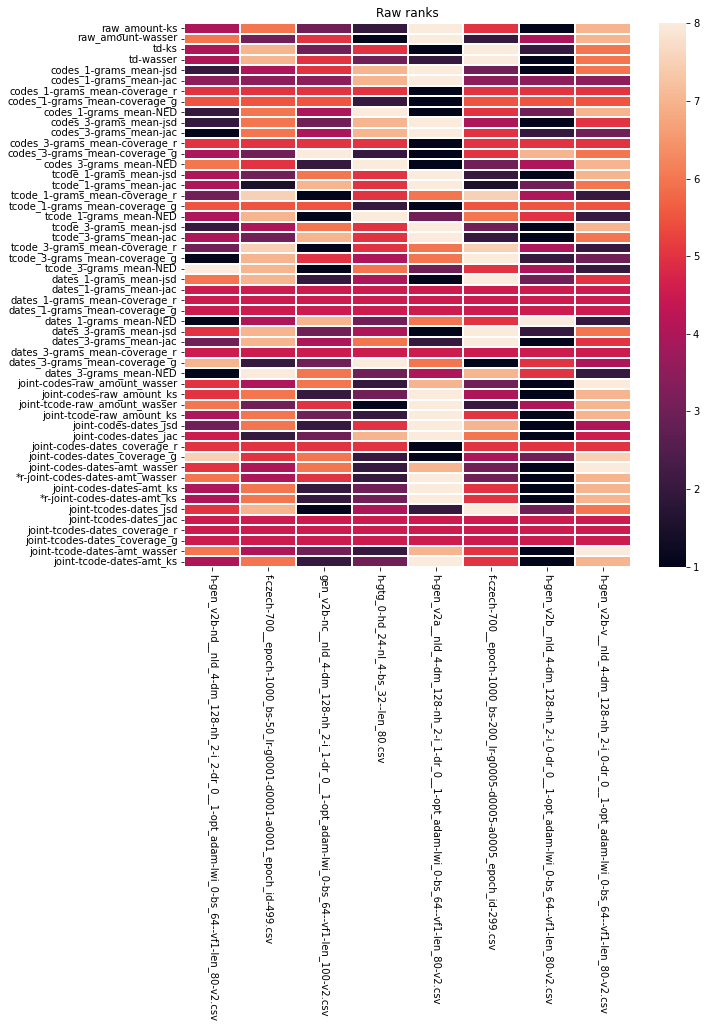

In [36]:
plt.figure(figsize=(10,10))
sns.heatmap(final_rank_df[value_cols], linewidths=0.1, xticklabels=x_labels, yticklabels=full_vals_df["index"])
plt.xticks(rotation=270)
plt.title(f"Raw ranks")
plt.show()

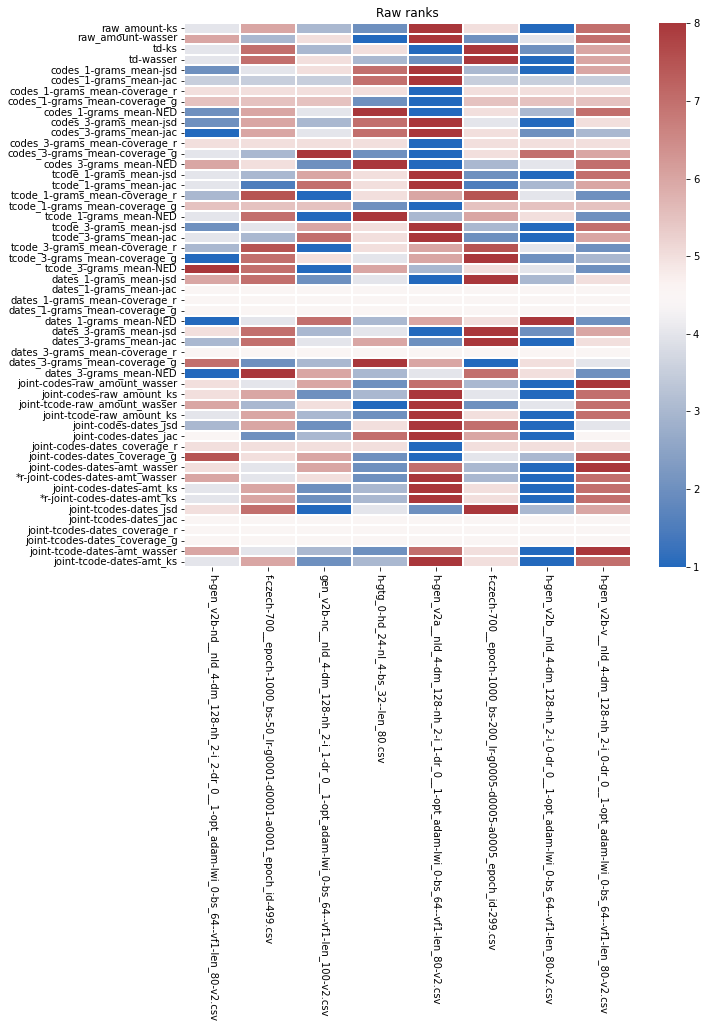

In [37]:
plt.figure(figsize=(10,10))
sns.heatmap(final_rank_df[value_cols], linewidths=0.1, xticklabels=x_labels, 
            yticklabels=full_vals_df["index"], cmap=sns.color_palette("vlag", as_cmap=True))
plt.xticks(rotation=270)
plt.title(f"Raw ranks")
plt.show()

#### Block ranks  
Groups ranks as: Top-k, bottom-k and remaining

In [38]:
k = 3

In [39]:
len(value_cols) - k

5

In [40]:
block_ranks = final_rank_df[value_cols].copy()
# block_ranks[value_cols][block_ranks[value_cols] <= 3] = 100
# block_ranks[]

best_vals = block_ranks < k
worst_vals = block_ranks >= len(value_cols) - k
mid_vals = ~np.logical_or(best_vals, worst_vals)


block_ranks[best_vals] = 100
block_ranks[worst_vals] = 0
block_ranks[mid_vals] = 50

block_ranks

value_0  value_1  value_2  value_3  value_4  value_5  value_6  value_7
0      50.0      0.0     50.0    100.0      0.0      0.0    100.0      0.0
1       0.0     50.0      0.0    100.0      0.0    100.0     50.0      0.0
2      50.0      0.0     50.0      0.0    100.0      0.0    100.0      0.0
3      50.0      0.0      0.0     50.0    100.0      0.0    100.0      0.0
4     100.0     50.0      0.0      0.0      0.0     50.0    100.0      0.0
5      50.0     50.0     50.0      0.0      0.0     50.0     50.0     50.0
6       0.0      0.0      0.0      0.0    100.0      0.0      0.0      0.0
7       0.0      0.0      0.0    100.0    100.0      0.0      0.0      0.0
8     100.0      0.0     50.0      0.0    100.0      0.0     50.0      0.0
9     100.0      0.0     50.0      0.0      0.0     50.0    100.0      0.0
10    100.0      0.0     50.0      0.0      0.0      0.0    100.0     50.0
11      0.0      0.0      0.0      0.0    100.0      0.0      0.0      0.0
12     50.0     50.0      0.0    100.0    100.0      0.0      0.0      0.0
13      0.0      0.0    100.0      0.0    100.0     50.0     50.0      0.0
14     50.0     50.0      0.0      0.0      0.0    100.0    100.0      0.0
15     50.0    100.0      0.0      0.0      0.0    100.0     50.0      0.0
16     50.0      0.0    100.0      0.0      0.0      0.0     50.0    100.0
17      0.0      0.0      0.0    100.0    100.0      0.0      0.0      0.0
18     50.0      0.0    100.0      0.0     50.0      0.0      0.0    100.0
19    100.0     50.0      0.0      0.0      0.0     50.0    100.0      0.0
20     50.0     50.0      0.0      0.0      0.0    100.0    100.0      0.0
21     50.0      0.0    100.0      0.0      0.0      0.0     50.0    100.0
22    100.0      0.0      0.0     50.0      0.0      0.0    100.0     50.0
23      0.0      0.0    100.0      0.0     50.0      0.0     50.0    100.0
24      0.0      0.0    100.0     50.0    100.0      0.0     50.0      0.0
25     50.0     50.0     50.0     50.0     50.0     50.0     50.0     50.0
26     50.0     50.0     50.0     50.0     50.0     50.0     50.0     50.0
27     50.0     50.0     50.0     50.0     50.0     50.0     50.0     50.0
28    100.0     50.0      0.0     50.0      0.0      0.0      0.0    100.0
29      0.0      0.0     50.0     50.0    100.0      0.0    100.0      0.0
30     50.0      0.0     50.0      0.0    100.0      0.0    100.0      0.0
31     50.0     50.0     50.0     50.0     50.0     50.0     50.0     50.0
32      0.0    100.0     50.0      0.0      0.0    100.0      0.0     50.0
33    100.0      0.0      0.0     50.0     50.0      0.0      0.0    100.0
34      0.0     50.0      0.0    100.0      0.0     50.0    100.0      0.0
35      0.0      0.0    100.0     50.0      0.0     50.0    100.0      0.0
36      0.0     50.0      0.0    100.0      0.0    100.0     50.0      0.0
37     50.0      0.0     50.0    100.0      0.0      0.0    100.0      0.0
38     50.0      0.0    100.0      0.0      0.0      0.0    100.0     50.0
39     50.0    100.0     50.0      0.0      0.0      0.0    100.0     50.0
40      0.0      0.0      0.0      0.0    100.0      0.0      0.0      0.0
41      0.0      0.0      0.0    100.0    100.0     50.0     50.0      0.0
42      0.0     50.0      0.0    100.0      0.0     50.0    100.0      0.0
43      0.0     50.0      0.0    100.0      0.0     50.0    100.0      0.0
44     50.0      0.0    100.0     50.0      0.0      0.0    100.0      0.0
45     50.0      0.0    100.0     50.0      0.0      0.0    100.0      0.0
46      0.0      0.0    100.0     50.0    100.0      0.0     50.0      0.0
47     50.0     50.0     50.0     50.0     50.0     50.0     50.0     50.0
48     50.0     50.0     50.0     50.0     50.0     50.0     50.0     50.0
49     50.0     50.0     50.0     50.0     50.0     50.0     50.0     50.0
50      0.0     50.0     50.0    100.0      0.0      0.0    100.0      0.0
51     50.0      0.0    100.0     50.0      0.0      0.0    100.0      0.0

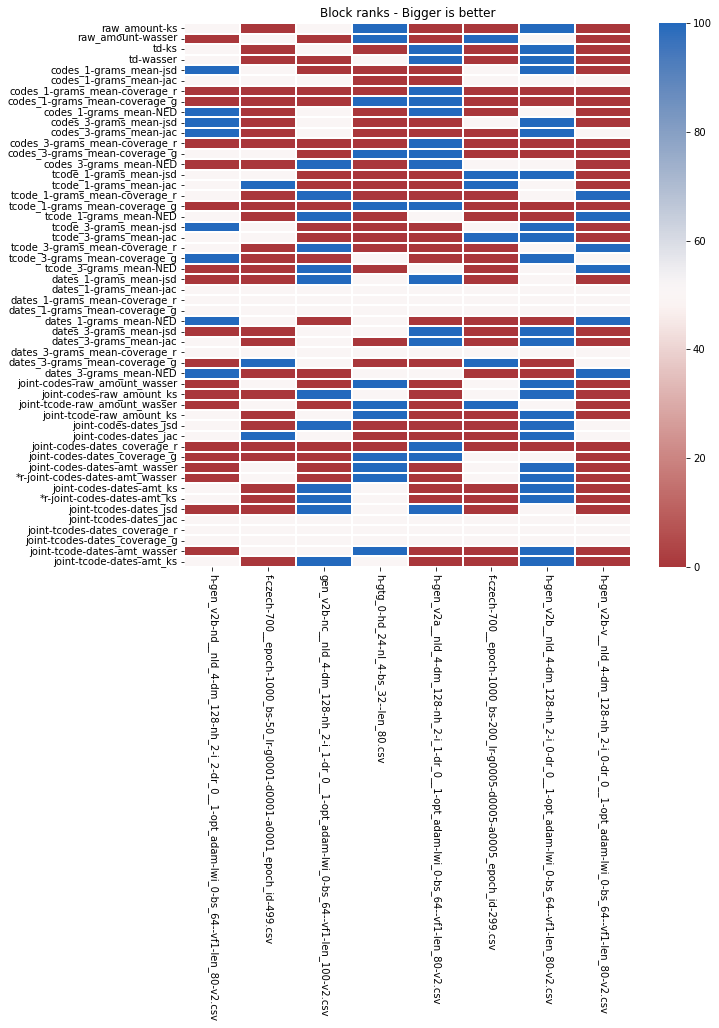

In [41]:
plt.figure(figsize=(10,10))
sns.heatmap(block_ranks, linewidths=0.1, xticklabels=x_labels, 
            yticklabels=full_vals_df["index"], cmap=sns.color_palette("vlag_r", as_cmap=True))
plt.xticks(rotation=270)
plt.title(f"Block ranks - Bigger is better")
plt.show()

In [42]:
x = (block_ranks > 50.0).sum()
for row in x.iteritems():
    break
    
row

('value_0', 8)

In [43]:
fname_map

get_short_fname = lambda x: fname_map[x].split("/")[1][:12]

l = [(get_short_fname(row[0]), row[1]) for row in x.iteritems()]
df = pd.DataFrame.from_records(l, columns=["fname", f"Times in top {k}"])
df.sort_values(by=f"Times in top {k}", ascending=False)

fname  Times in top 3
6  h-gen_v2b__n              23
4  h-gen_v2a__n              15
2  gen_v2b-nc__              12
3  h-gtg_0-hd_2              12
0  h-gen_v2b-nd               8
5  f-czech-700_               6
7  h-gen_v2b-v_               6
1  f-czech-700_               3

## Correlations

In [44]:
full_vals_df[value_cols]

value_0      value_1      value_2      value_3      value_4  \
0      0.161694     0.183205     0.156864     0.105645     0.616628   
1    3704.78486  2048.765521  3551.998563  1930.988833  5807.966294   
2      0.140243     0.764744      0.11228     0.178425     0.032921   
3      1.176085     5.273062     1.498473     1.050423     0.851423   
4      0.001866     0.002746     0.003459     0.021414     0.337494   
5           0.0          0.0          0.0     0.111111     0.619048   
6           1.0          1.0          1.0          1.0     0.690476   
7           1.0          1.0          1.0     0.888889     0.690476   
8      0.019418     0.063346     0.024028     0.140918     0.015173   
9      0.022299     0.061542     0.039616     0.137375      0.46394   
10      0.11594     0.184712     0.131361     0.375292     0.665712   
11     0.849909     0.849909     0.849909     0.849909     0.412293   
12     0.854481     0.832076     0.962963     0.609053     0.425049   
13     0.170046      0.14079     0.017108      0.27569    -0.035997   
14     0.008737     0.007311     0.156934     0.074752     0.693147   
15     0.794872          0.0     0.851852     0.826087          1.0   
16     0.205128          1.0     0.148148     0.347826          0.5   
17          1.0          1.0          1.0     0.826087          0.5   
18     0.073951      0.13627    -1.083243     0.181571     0.046267   
19      0.05868     0.143343     0.414126     0.337165     0.693147   
20     0.690745     0.561458     0.976079     0.951202          1.0   
21     0.003015     0.349365     0.001136     0.014702     0.043671   
22     0.006762     0.324951     0.038552     0.029681     0.062012   
23     0.390601     0.382679    -2.941865     0.225103    -0.041618   
24     0.059103      0.07474     0.006536     0.058898     0.006064   
25          0.0          0.0          0.0          0.0          0.0   
26          1.0          1.0          1.0          1.0          1.0   
27          1.0          1.0          1.0          1.0          1.0   
28     -0.27745    -0.220194     -0.01207    -0.277383    -0.017622   
29     0.188882     0.453922     0.072589     0.178518      0.03574   
30      0.38865     0.895163      0.38958     0.467262     0.340898   
31     0.418409     0.418409     0.418409     0.418409     0.418409   
32     0.441636     0.043181     0.345555     0.519935     0.422747   
33    -0.788156     2.198651     0.264366    -0.623875     0.050741   
34  3743.898891  2771.503108  4119.178323  2406.631775  4862.753519   
35     0.321596     0.363936     0.264675     0.302119     0.672511   
36  3686.092399  2065.278395  3504.596409  1913.550321  5794.460976   
37     0.233426     0.321778     0.219521     0.199919     0.674857   
38      0.10593     0.122669     0.019769     0.121276     0.394283   
39     0.148895     0.147611     0.148753     0.252665     0.623713   
40     0.851105     0.851105     0.851105     0.851105     0.607719   
41          1.0     0.997312     0.999701     0.847101     0.687404   
42  3975.792976   3583.44508  4177.183992  3229.575345  4750.483351   
43  4177.573575   3439.70933  4170.231658  3234.163428  5713.801373   
44     0.377858     0.428994      0.31834       0.3726     0.677927   
45     0.382594     0.417806     0.314224     0.376708     0.702961   
46     0.062532     0.079278      0.00921     0.062404     0.009323   
47          0.0          0.0          0.0          0.0          0.0   
48          1.0          1.0          1.0          1.0          1.0   
49          1.0          1.0          1.0          1.0          1.0   
50  4003.031347  3618.480297  3568.974976  3420.943629  5891.351274   
51     0.311903     0.396193     0.291869     0.309448     0.697689   

        value_5      value_6      value_7  
0      0.161744     0.081775     0.213238  
1   1939.130183  2101.772203  4725.972935  
2      0.767066     0.069934     0.233642  
3      5.275384     0.600606     2.384143  
4      0.002671     0.00

/Users/kylenickerson/opt/anaconda3/envs/py37_bf/lib/python3.7/site-packages/numpy/lib/function_base.py:2642: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/kylenickerson/opt/anaconda3/envs/py37_bf/lib/python3.7/site-packages/numpy/lib/function_base.py:2643: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


<AxesSubplot:>

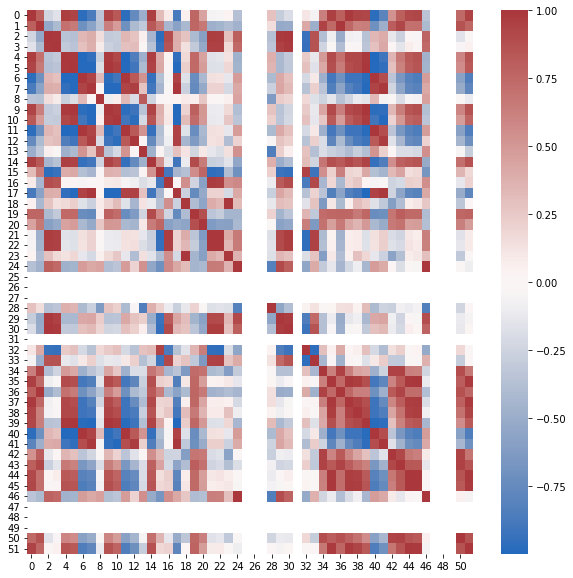

In [45]:
plt.figure(figsize=(10,10))
cor = np.corrcoef(scaled_vals_df)
sns.heatmap(cor, cmap=sns.color_palette("vlag", as_cmap=True))


In [46]:
cor

array([[ 1.        ,  0.79296228, -0.2345773 , ...,         nan,
         0.73592091,  0.94030905],
       [ 0.79296228,  1.        , -0.53246587, ...,         nan,
         0.86064886,  0.75421003],
       [-0.2345773 , -0.53246587,  1.        , ...,         nan,
        -0.15232235, -0.02981106],
       ...,
       [        nan,         nan,         nan, ...,         nan,
                nan,         nan],
       [ 0.73592091,  0.86064886, -0.15232235, ...,         nan,
         1.        ,  0.86695521],
       [ 0.94030905,  0.75421003, -0.02981106, ...,         nan,
         0.86695521,  1.        ]])

In [47]:
zero_var_cols = scaled_vals_df.transpose().std() == 0.0

<AxesSubplot:>

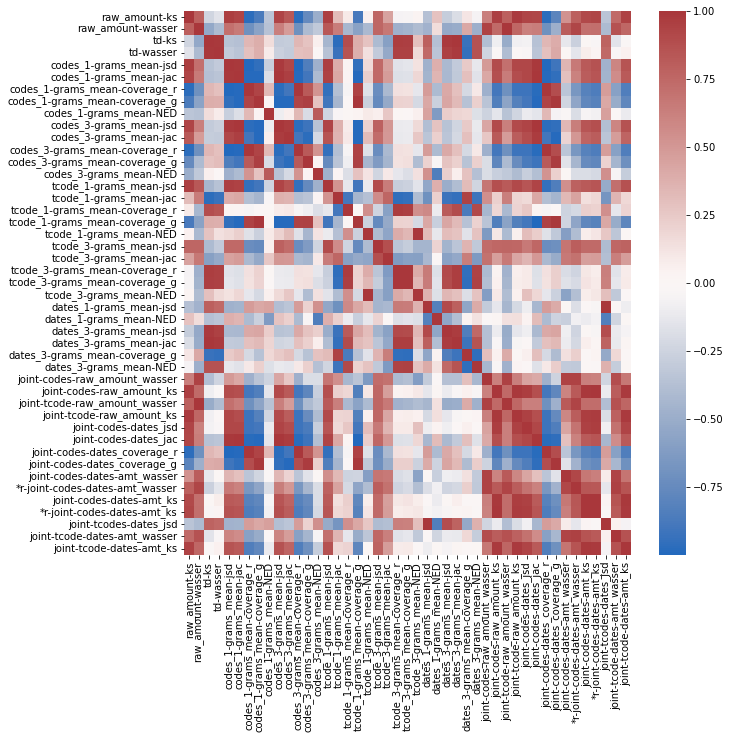

In [48]:
plt.figure(figsize=(10,10))
cor = np.corrcoef(scaled_vals_df[~zero_var_cols])
sns.heatmap(cor, cmap=sns.color_palette("vlag", as_cmap=True), 
            xticklabels=full_vals_df["index"][~zero_var_cols], yticklabels=full_vals_df["index"][~zero_var_cols])

## Cluster

In [49]:
scaled_vals_df

0             1             2             3             4  \
0  -3.054628e-01 -1.697164e-01 -3.359410e-01 -6.591552e-01  2.565402e+00   
1   3.466436e-01 -8.533848e-01  2.359276e-01 -9.387313e-01  1.870706e+00   
2  -5.214951e-01  1.691511e+00 -6.205873e-01 -3.861921e-01 -9.018070e-01   
3  -6.016603e-01  1.664756e+00 -4.233175e-01 -6.711753e-01 -7.812608e-01   
4  -4.204753e-01 -4.124472e-01 -4.059398e-01 -2.421652e-01  2.640977e+00   
5  -4.501159e-01 -4.501159e-01 -4.501159e-01  9.785129e-02  2.602844e+00   
6   3.779645e-01  3.779645e-01  3.779645e-01  3.779645e-01 -2.645751e+00   
7   5.070204e-01  5.070204e-01  5.070204e-01 -5.644189e-01 -2.477703e+00   
8  -7.777718e-01  3.165366e-01 -6.629253e-01  2.249007e+00 -8.835215e-01   
9  -6.013896e-01 -3.204360e-01 -4.774095e-01  2.224770e-01  2.560455e+00   
10 -6.602579e-01 -2.804171e-01 -5.750851e-01  7.721978e-01  2.376257e+00   
11  3.779645e-01  3.779645e-01  3.779645e-01  3.779645e-01 -2.645751e+00   
12  3.739669e-01  2.411567e-01  1.017012e+00 -1.080846e+00 -2.171567e+00   
13  7.011802e-01  4.048680e-01 -8.478010e-01  1.771155e+00 -1.385658e+00   
14 -6.090579e-01 -6.155714e-01  6.774164e-02 -3.075715e-01  2.516577e+00   
15  4.451925e-01 -1.697190e+00  5.987684e-01  5.293254e-01  9.980656e-01   
16 -7.494139e-01  1.638922e+00 -9.206208e-01 -3.206523e-01  1.365817e-01   
17  5.040151e-01  5.040151e-01  5.040151e-01 -5.365322e-01 -2.487558e+00   
18  5.095212e-01  6.391477e-01 -1.897501e+00  7.333759e-01  4.519380e-01   
19 -1.050870e+00 -6.546548e-01  6.125905e-01  2.524189e-01  1.918390e+00   
20 -4.473218e-01 -1.093808e+00  9.794672e-01  8.550692e-01  1.099081e+00   
21 -6.361723e-01  1.725288e+00 -6.489870e-01 -5.564943e-01 -3.589797e-01   
22 -7.313349e-01  1.542903e+00 -5.041156e-01 -5.675261e-01 -3.364419e-01   
23  7.151283e-01  7.087840e-01 -1.953679e+00  5.825890e-01  3.689850e-01   
24  4.375038e-01  9.430918e-01 -1.262218e+00  4.308755e-01 -1.277461e+00   
25  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
26  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
27  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
28 -9.977110e-01 -5.389062e-01  1.128836e+00 -9.971809e-01  1.084348e+00   
29 -1.153594e-01  1.563916e+00 -8.521821e-01 -1.810237e-01 -1.085655e+00   
30 -5.776763e-01  1.641712e+00 -5.736028e-01 -2.332246e-01 -7.869129e-01   
31  5.551115e-17  5.551115e-17  5.551115e-17  5.551115e-17  5.551115e-17   
32  6.752945e-01 -1.624236e+00  1.207992e-01  1.127166e+00  5.662832e-01   
33 -1.006523e+00  1.629183e+00 -7.772550e-02 -8.615531e-01 -2.662383e-01   
34  2.427179e-01 -6.550174e-01  5.891834e-01 -9.918739e-01  1.275667e+00   
35 -1.820747e-01  1.247188e-01 -5.945314e-01 -3.232139e-01  2.360692e+00   
36  3.309750e-01 -8.469961e-01  1.990678e-01 -9.572686e-01  1.863290e+00   
37 -3.869088e-01  1.765614e-01 -4.755902e-01 -6.006018e-01  2.428355e+00   
38 -2.090450e-01 -5.665390e-02 -9.934248e-01 -6.933247e-02  2.416036e+00   
39 -4.584014e-01 -4.666208e-01 -4.593091e-01  2.057477e-01  2.580519e+00   
40  3.779645e-01  3.779645e-01  3.779645e-01  3.779645e-01 -2.645751e+00   
41  5.843595e-01  5.591073e-01  5.815537e-01 -8.519467e-01 -2.352119e+00   
42  8.477795e-02 -3.262153e-01  2.957396e-01 -6.969019e-01  8.962836e-01   
43  2.372210e-01 -4.810776e-01  2.300738e-01 -6.811731e-01  1.732713e+00   
44 -2.078974e-01  1.961524e-01 -6.781767e-01 -2.494426e-01  2.163093e+00   
45 -1.548451e-01  1.099308e-01 -6.689467e-01 -1.991053e-01  2.254152e+00   
46  3.847954e-01  9.018407e-01 -1.261496e+00  3.808566e-01 -1.258005e+00   
47  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
48  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
49  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
50 -2.265185e-02 -3.422164e-01 -3.833556e-01 -5.063707e-01  1.546555e+00   
51 -4.456463e-01  1.429178e-01 -5.855329e-01 -4.627823e-01  2.2

In [50]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

#### points are metrics

In [51]:
pcs = PCA(n_components=2).fit_transform(scaled_vals_df)
pcs.shape

(52, 2)

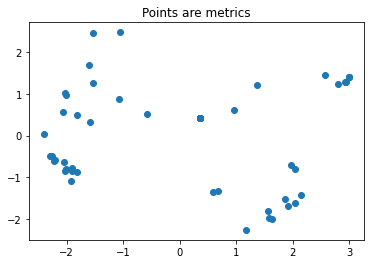

In [52]:
plt.scatter(pcs[:,0], pcs[:,1])
plt.title("Points are metrics")
plt.show()

In [53]:
tsne = TSNE(n_components=2).fit_transform(scaled_vals_df)
tsne.shape

/Users/kylenickerson/opt/anaconda3/envs/py37_bf/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/Users/kylenickerson/opt/anaconda3/envs/py37_bf/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


(52, 2)

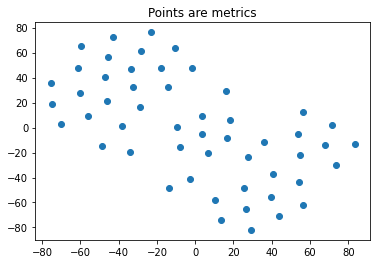

In [54]:
plt.scatter(tsne[:,0], tsne[:,1])
plt.title("Points are metrics")
plt.show()

#### points are datasets

In [55]:
pcs = PCA(n_components=2).fit_transform(scaled_vals_df.transpose())
pcs.shape

(8, 2)

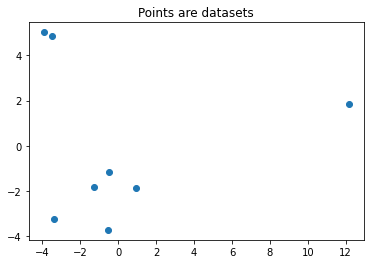

In [56]:
plt.scatter(pcs[:,0], pcs[:,1])
plt.title("Points are datasets")
plt.show()

In [57]:
tsne = TSNE(n_components=2, perplexity=2).fit_transform(scaled_vals_df.transpose())
tsne.shape

/Users/kylenickerson/opt/anaconda3/envs/py37_bf/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/Users/kylenickerson/opt/anaconda3/envs/py37_bf/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


(8, 2)

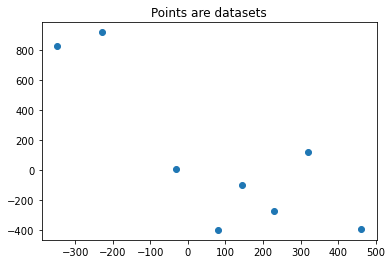

In [58]:
plt.scatter(tsne[:,0], tsne[:,1])
plt.title("Points are datasets")
plt.show()

### Color

#### points are metrics

In [59]:
pcs = PCA(n_components=2).fit_transform(scaled_vals_df)
pcs.shape

(52, 2)

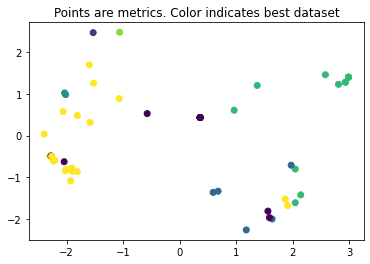

In [60]:
# plt.scatter(pcs[:,0], pcs[:,1], c=np.argmax(scaled_vals_df.to_numpy(), axis=1))
plt.scatter(pcs[:,0], pcs[:,1], c=np.argmin(scaled_vals_df.to_numpy(), axis=1))
plt.title("Points are metrics. Color indicates best dataset")
plt.show()

In [61]:
tsne = TSNE(n_components=2).fit_transform(scaled_vals_df)
tsne.shape

/Users/kylenickerson/opt/anaconda3/envs/py37_bf/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/Users/kylenickerson/opt/anaconda3/envs/py37_bf/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


(52, 2)

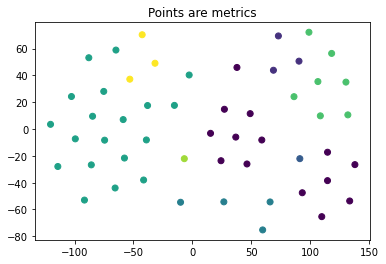

In [62]:
plt.scatter(tsne[:,0], tsne[:,1], c=np.argmax(scaled_vals_df.to_numpy(), axis=1))
plt.title("Points are metrics")
plt.show()

In [63]:
len(set(np.argmax(scaled_vals_df.to_numpy(), axis=1)))

8

#### points are datasets

In [64]:
result_df

index  ave_rank                                           filename  \
0  value_0  4.250000  h-gen_v2b-nd__nld_4-dm_128-nh_2-i_2-dr_0__1-op...   
1  value_1  4.833333  f-czech-700__epoch-1000_bs-50_lr-g0001-d0001-a...   
2  value_2  4.250000  gen_v2b-nc__nld_4-dm_128-nh_2-i_1-dr_0__1-opt_...   
3  value_3  3.833333               h-gtg_0-hd_24-nl_4-bs_32--len_80.csv   
4  value_4  6.166667  h-gen_v2a__nld_4-dm_128-nh_2-i_1-dr_0__1-opt_a...   
5  value_5  4.583333  f-czech-700__epoch-1000_bs-200_lr-g0005-d0005-...   
6  value_6  1.750000  h-gen_v2b__nld_4-dm_128-nh_2-i_0-dr_0__1-opt_a...   
7  value_7  6.333333  h-gen_v2b-v__nld_4-dm_128-nh_2-i_0-dr_0__1-opt...   

                           short_labels_2  
0  nd__nld_4-dm_128-nh_--am-lwi_0-bs_64--  
1  0__epoch-1000_bs-50_--_epoch_id-499.cs  
2  __nld_4-dm_128-nh_2----lwi_0-bs_64--vf  
3                  _24-nl_4-bs_32--len_--  
4  _nld_4-dm_128-nh_2-i--lwi_0-bs_64--vf1  
5  0__epoch-1000_bs-200--5_epoch_id-299.c  
6  _nld_4-dm_128-nh_2-i--lwi_0-bs_64--vf1  
7  v__nld_4-dm_128-nh_2--m-lwi_0-bs_64--v

In [65]:
pcs = PCA(n_components=2).fit_transform(scaled_vals_df.transpose())
pcs.shape

(8, 2)

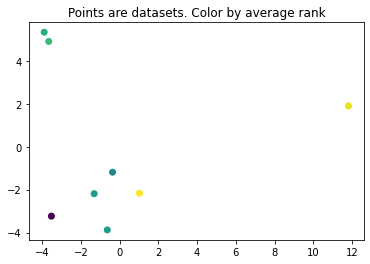

In [66]:
# plt.scatter(pcs[:,0], pcs[:,1], c=result_df.ave_rank)
plt.scatter(pcs[:,0] + np.random.normal(scale=0.2, size=pcs[:,0].shape), 
            pcs[:,1] + np.random.normal(scale=0.2, size=pcs[:,0].shape), c=result_df.ave_rank)
plt.title("Points are datasets. Color by average rank")
plt.show()

In [67]:
best_on_each_metric = np.argmax(scaled_vals_df.to_numpy(), axis=1)
colors = np.array([sum(best_on_each_metric==x) for x in range(len(result_df)) ])
colors

array([14,  3,  1,  4, 19,  7,  1,  3])

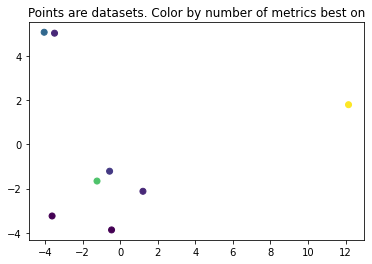

In [68]:

plt.scatter(pcs[:,0] + np.random.normal(scale=0.2, size=pcs[:,0].shape), 
            pcs[:,1] + np.random.normal(scale=0.2, size=pcs[:,0].shape), c=colors)
plt.title("Points are datasets. Color by number of metrics best on")
plt.show()

In [69]:
tsne = TSNE(n_components=2, perplexity=2).fit_transform(scaled_vals_df.transpose())
tsne.shape

/Users/kylenickerson/opt/anaconda3/envs/py37_bf/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/Users/kylenickerson/opt/anaconda3/envs/py37_bf/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


(8, 2)

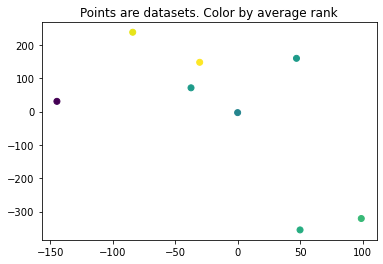

In [70]:
plt.scatter(tsne[:,0], tsne[:,1], c=result_df.ave_rank)
plt.title("Points are datasets. Color by average rank")
plt.show()

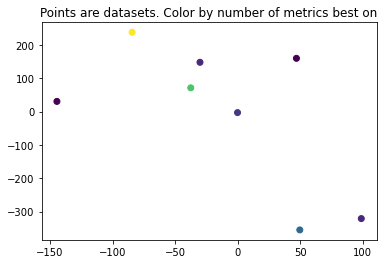

In [71]:

plt.scatter(tsne[:,0] + np.random.normal(scale=0.2, size=pcs[:,0].shape), 
            tsne[:,1] + np.random.normal(scale=0.2, size=pcs[:,0].shape), c=colors)
plt.title("Points are datasets. Color by number of metrics best on")

plt.show()

### Plotly

In [72]:
import plotly.graph_objects as go

In [73]:
final_rank_df

index           measures      metric  value_0  \
0                     raw_amount-ks         raw_amount          ks      4.0   
1                 raw_amount-wasser         raw_amount      wasser      6.0   
2                             td-ks                 td          ks      4.0   
3                         td-wasser                 td      wasser      4.0   
4            codes_1-grams_mean-jsd      codes_1-grams         jsd      2.0   
5            codes_1-grams_mean-jac      codes_1-grams         jac      3.5   
6     codes_1-grams_mean-coverage_r      codes_1-grams  coverage_r      5.0   
7     codes_1-grams_mean-coverage_g      codes_1-grams  coverage_g      5.5   
8            codes_1-grams_mean-NED      codes_1-grams         NED      2.0   
9            codes_3-grams_mean-jsd      codes_3-grams         jsd      2.0   
10           codes_3-grams_mean-jac      codes_3-grams         jac      1.0   
11    codes_3-grams_mean-coverage_r      codes_3-grams  coverage_r      5.0   
12    codes_3-grams_mean-coverage_g      codes_3-grams  coverage_g      4.0   
13           codes_3-grams_mean-NED      codes_3-grams         NED      6.0   
14           tcode_1-grams_mean-jsd      tcode_1-grams         jsd      4.0   
15           tcode_1-grams_mean-jac      tcode_1-grams         jac      4.0   
16    tcode_1-grams_mean-coverage_r      tcode_1-grams  coverage_r      3.0   
17    tcode_1-grams_mean-coverage_g      tcode_1-grams  coverage_g      5.5   
18           tcode_1-grams_mean-NED      tcode_1-grams         NED      4.0   
19           tcode_3-grams_mean-jsd      tcode_3-grams         jsd      2.0   
20           tcode_3-grams_mean-jac      tcode_3-grams         jac      4.0   
21    tcode_3-grams_mean-coverage_r      tcode_3-grams  coverage_r      3.0   
22    tcode_3-grams_mean-coverage_g      tcode_3-grams  coverage_g      1.0   
23           tcode_3-grams_mean-NED      tcode_3-grams         NED      8.0   
24           dates_1-grams_mean-jsd      dates_1-grams         jsd      6.0   
25           dates_1-grams_mean-jac      dates_1-grams         jac      4.5   
26    dates_1-grams_mean-coverage_r      dates_1-grams  coverage_r      4.5   
27    dates_1-grams_mean-coverage_g      dates_1-grams  coverage_g      4.5   
28           dates_1-grams_mean-NED      dates_1-grams         NED      1.0   
29           dates_3-grams_mean-jsd      dates_3-grams         jsd      5.0   
30           dates_3-grams_mean-jac      dates_3-grams         jac      3.0   
31    dates_3-grams_mean-coverage_r      dates_3-grams  coverage_r      4.5   
32    dates_3-grams_mean-coverage_g      dates_3-grams  coverage_g      7.0   
33           dates_3-grams_mean-NED      dates_3-grams         NED      1.0   
34    joint-codes-raw_amount_wasser  codes, raw_amount      wasser      5.0   
35        joint-codes-raw_amount_ks  codes, raw_amount          ks      5.0   
36    joint-tcode-raw_amount_wasser  tcode, raw_amount      wasser      6.0   
37        joint-tcode-raw_amount_ks  tcode, raw_amount          ks      4.0   
38            joint-codes-dates_jsd       codes, dates         jsd      3.0   
39            joint-codes-dates_jac       codes, dates         jac      4.5   
40     joint-codes-dates_coverage_r       codes, dates  coverage_r      5.0   
41     joint-codes-dates_coverage_g       codes, dates  coverage_g      7.5   
42     joint-codes-dates-amt_wasser  codes, dates, amt      wasser      5.0   
43  *r-joint-codes-dates-amt_wasser  codes, dates, amt      wasser      6.0   
44         joint-codes-dates-amt_ks  codes, dates, amt          ks      4.0   
45      *r-joint-codes-dates-amt_ks  codes, dates, amt          ks      4.0   
46           joint-tcodes-dates_jsd       tcode, dates         jsd      5.0   
47           joint-tcodes-dates_jac       tcode, dates         jac      4.5   
48    joint-tcodes-dates_coverage_r       tcode, dates  coverage_r      4.5   
49    joint-tcodes-dates_coverage_g       tcode, dates  coverage_g      4.5   
5

#### points are metrics

In [74]:
pcs = PCA(n_components=2).fit_transform(scaled_vals_df)
pcs.shape

(52, 2)

In [75]:
tsne = TSNE(n_components=2).fit_transform(scaled_vals_df)
tsne.shape

/Users/kylenickerson/opt/anaconda3/envs/py37_bf/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

/Users/kylenickerson/opt/anaconda3/envs/py37_bf/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



(52, 2)

In [76]:
fname_map

{'value_0': 'generated_data/h-gen_v2b-nd__nld_4-dm_128-nh_2-i_2-dr_0__1-opt_adam-lwi_0-bs_64--vf1-len_80-v2.csv',
 'value_1': 'generated_data/f-czech-700__epoch-1000_bs-50_lr-g0001-d0001-a0001_epoch_id-499.csv',
 'value_2': 'generated_data/gen_v2b-nc__nld_4-dm_128-nh_2-i_1-dr_0__1-opt_adam-lwi_0-bs_64--vf1-len_100-v2.csv',
 'value_3': 'generated_data/h-gtg_0-hd_24-nl_4-bs_32--len_80.csv',
 'value_4': 'generated_data/h-gen_v2a__nld_4-dm_128-nh_2-i_1-dr_0__1-opt_adam-lwi_0-bs_64--vf1-len_80-v2.csv',
 'value_5': 'generated_data/f-czech-700__epoch-1000_bs-200_lr-g0005-d0005-a0005_epoch_id-299.csv',
 'value_6': 'generated_data/h-gen_v2b__nld_4-dm_128-nh_2-i_0-dr_0__1-opt_adam-lwi_0-bs_64--vf1-len_80-v2.csv',
 'value_7': 'generated_data/h-gen_v2b-v__nld_4-dm_128-nh_2-i_0-dr_0__1-opt_adam-lwi_0-bs_64--vf1-len_80-v2.csv'}

In [77]:

parse_k = lambda x: int(x.split("_")[-1])
parse_v = lambda x: x.split("/")[-1][:10]

mini_fname_map = dict([ (parse_k(k), parse_v(v)) for k, v in fname_map.items() ])
mini_fname_map

{0: 'h-gen_v2b-',
 1: 'f-czech-70',
 2: 'gen_v2b-nc',
 3: 'h-gtg_0-hd',
 4: 'h-gen_v2a_',
 5: 'f-czech-70',
 6: 'h-gen_v2b_',
 7: 'h-gen_v2b-'}

In [78]:
d = {
    "pc0": pcs[:,0],
    "pc1": pcs[:,1],
    "tsne0": tsne[:,0],
    "tsne1": tsne[:,1],
    "metric": final_rank_df["index"],
    "best_dataset_no": np.argmin(scaled_vals_df.to_numpy(), axis=1),
    "measures": final_rank_df.measures,
    "base_metric": final_rank_df.metric,
}

plot_df_metrics = pd.DataFrame.from_dict(d)


plot_df_metrics["best_dataset"] = plot_df_metrics["best_dataset_no"].apply(lambda x: mini_fname_map[x])
plot_df_metrics["text"] = plot_df_metrics['metric'] + "--" + plot_df_metrics['best_dataset'].astype(str)

plot_df_metrics

pc0       pc1       tsne0       tsne1  \
0  -2.209778 -0.589018   37.589428  146.482178   
1  -2.037666  1.019356  -18.336962   79.789001   
2   2.041637 -1.606223  -92.896637  -81.571297   
3   1.863921 -1.520034  -74.288132 -112.251419   
4  -2.296085 -0.494115    3.227804  164.731140   
5  -2.278949 -0.485925   82.828285  199.741104   
6   2.983497  1.398126   17.571409 -177.348358   
7   2.925212  1.273383   66.244904 -208.137772   
8   0.960257  0.606860  -23.645243 -136.554489   
9  -2.231805 -0.612436   -0.534919  204.946655   
10 -2.045615 -0.624599  122.640480  117.650345   
11  2.983497  1.398126   18.893980 -216.694336   
12  2.573935  1.455411   98.331779 -166.897934   
13  1.368390  1.199259  -27.811796 -177.520950   
14 -2.399008  0.036221  -37.389484  170.516998   
15 -1.532557  2.461908  126.891144   12.087478   
16  1.174909 -2.256054 -121.279167  -52.634205   
17  2.931862  1.278809   56.728634 -169.296204   
18  0.589150 -1.359102  -86.411949   -6.377656   
19 -2.064288  0.575576  122.528900  160.877090   
20 -1.600421  1.692244  122.999207   61.110271   
21  1.632330 -1.994645 -156.495026  -69.234329   
22  1.585154 -1.961626 -128.099594 -100.003174   
23  0.676496 -1.330289 -118.530441    3.507204   
24  2.041212 -0.800266  -99.361740 -183.591949   
25  0.358718  0.432059    1.383357  -84.672722   
26  0.358718  0.432059  -30.964621  -64.056168   
27  0.358718  0.432059    1.983489  -13.791799   
28 -0.577306  0.526008  -92.154068   77.343765   
29  2.138382 -1.418113 -105.295364 -135.938110   
30  1.906503 -1.672756 -143.242325 -143.315048   
31  0.358718  0.432059    2.770243  -48.861221   
32 -1.064325  2.471621  107.131424  -21.520830   
33  1.557977 -1.806384 -171.358017 -107.169807   
34 -1.526703  1.255672   36.106220   37.561096   
35 -2.004437 -0.809570  -31.146620  126.314316   
36 -2.019347  0.980101   67.116081   75.106422   
37 -2.022271 -0.840451   75.420303  155.139954   
38 -1.932308 -1.083263   42.321781  182.403549   
39 -2.266418 -0.496020   40.413197  222.732880   
40  2.983497  1.398126   27.652523 -138.340317   
41  2.806080  1.226663   72.468315 -129.345078   
42 -1.073851  0.886444   -3.463409   40.349182   
43 -1.812639  0.483004   23.843971   75.786499   
44 -1.813141 -0.861919   42.274311  110.580452   
45 -1.901651 -0.856115    6.667704  121.506279   
46  1.969189 -0.707629  -70.318222 -159.382690   
47  0.358718  0.432059  -32.659290  -26.657421   
48  0.358718  0.432059   37.036148  -69.014984   
49  0.358718  0.432059   36.959801  -31.451876   
50 -1.586546  0.315480   74.402298   38.109924   
51 -1.906998 -0.776260   78.707146  116.787170   

                             metric  best_dataset_no           measures  \
0                     raw_amount-ks                6         raw_amount   
1                 raw_amount-wasser                3         raw_amount   
2                             td-ks                4                 td   
3                         td-wasser                6                 td   
4            codes_1-grams_mean-jsd                6      codes_1-grams   
5            codes_1-grams_mean-jac                0      codes_1-grams   
6     codes_1-grams_mean-coverage_r                4      codes_1-grams   
7     codes_1-grams_mean-coverage_g                4      codes_1-grams   
8            codes_1-grams_mean-NED                4      codes_1-grams   
9            codes_3-grams_mean-jsd                6      codes_3-grams   
10           codes_3-grams_mean-jac                0      codes_3-grams   
11    codes_3-grams_mean-coverage_r                4      codes_3-grams   
12    codes_3-grams_mean-coverage_g                4      codes_3-grams   
13           codes_3-grams_mean-NED                4      codes_3-grams   
14           tcode_1-grams_mean-jsd                6      tcode_1-grams   
15           tcode_1-grams_mean-jac                1      tcode_1-grams   
16    tcode_1-grams_mean-coverage_r                2      tcode_1-grams   
17    tc

In [79]:
uniq_models = plot_df_metrics.best_dataset.unique()

get_model_no = lambda x: list(uniq_models).index(x)

plot_df_metrics["best_model_no"] = plot_df_metrics.best_dataset.apply(get_model_no)
plot_df_metrics

pc0       pc1       tsne0       tsne1  \
0  -2.209778 -0.589018   37.589428  146.482178   
1  -2.037666  1.019356  -18.336962   79.789001   
2   2.041637 -1.606223  -92.896637  -81.571297   
3   1.863921 -1.520034  -74.288132 -112.251419   
4  -2.296085 -0.494115    3.227804  164.731140   
5  -2.278949 -0.485925   82.828285  199.741104   
6   2.983497  1.398126   17.571409 -177.348358   
7   2.925212  1.273383   66.244904 -208.137772   
8   0.960257  0.606860  -23.645243 -136.554489   
9  -2.231805 -0.612436   -0.534919  204.946655   
10 -2.045615 -0.624599  122.640480  117.650345   
11  2.983497  1.398126   18.893980 -216.694336   
12  2.573935  1.455411   98.331779 -166.897934   
13  1.368390  1.199259  -27.811796 -177.520950   
14 -2.399008  0.036221  -37.389484  170.516998   
15 -1.532557  2.461908  126.891144   12.087478   
16  1.174909 -2.256054 -121.279167  -52.634205   
17  2.931862  1.278809   56.728634 -169.296204   
18  0.589150 -1.359102  -86.411949   -6.377656   
19 -2.064288  0.575576  122.528900  160.877090   
20 -1.600421  1.692244  122.999207   61.110271   
21  1.632330 -1.994645 -156.495026  -69.234329   
22  1.585154 -1.961626 -128.099594 -100.003174   
23  0.676496 -1.330289 -118.530441    3.507204   
24  2.041212 -0.800266  -99.361740 -183.591949   
25  0.358718  0.432059    1.383357  -84.672722   
26  0.358718  0.432059  -30.964621  -64.056168   
27  0.358718  0.432059    1.983489  -13.791799   
28 -0.577306  0.526008  -92.154068   77.343765   
29  2.138382 -1.418113 -105.295364 -135.938110   
30  1.906503 -1.672756 -143.242325 -143.315048   
31  0.358718  0.432059    2.770243  -48.861221   
32 -1.064325  2.471621  107.131424  -21.520830   
33  1.557977 -1.806384 -171.358017 -107.169807   
34 -1.526703  1.255672   36.106220   37.561096   
35 -2.004437 -0.809570  -31.146620  126.314316   
36 -2.019347  0.980101   67.116081   75.106422   
37 -2.022271 -0.840451   75.420303  155.139954   
38 -1.932308 -1.083263   42.321781  182.403549   
39 -2.266418 -0.496020   40.413197  222.732880   
40  2.983497  1.398126   27.652523 -138.340317   
41  2.806080  1.226663   72.468315 -129.345078   
42 -1.073851  0.886444   -3.463409   40.349182   
43 -1.812639  0.483004   23.843971   75.786499   
44 -1.813141 -0.861919   42.274311  110.580452   
45 -1.901651 -0.856115    6.667704  121.506279   
46  1.969189 -0.707629  -70.318222 -159.382690   
47  0.358718  0.432059  -32.659290  -26.657421   
48  0.358718  0.432059   37.036148  -69.014984   
49  0.358718  0.432059   36.959801  -31.451876   
50 -1.586546  0.315480   74.402298   38.109924   
51 -1.906998 -0.776260   78.707146  116.787170   

                             metric  best_dataset_no           measures  \
0                     raw_amount-ks                6         raw_amount   
1                 raw_amount-wasser                3         raw_amount   
2                             td-ks                4                 td   
3                         td-wasser                6                 td   
4            codes_1-grams_mean-jsd                6      codes_1-grams   
5            codes_1-grams_mean-jac                0      codes_1-grams   
6     codes_1-grams_mean-coverage_r                4      codes_1-grams   
7     codes_1-grams_mean-coverage_g                4      codes_1-grams   
8            codes_1-grams_mean-NED                4      codes_1-grams   
9            codes_3-grams_mean-jsd                6      codes_3-grams   
10           codes_3-grams_mean-jac                0      codes_3-grams   
11    codes_3-grams_mean-coverage_r                4      codes_3-grams   
12    codes_3-grams_mean-coverage_g                4      codes_3-grams   
13           codes_3-grams_mean-NED                4      codes_3-grams   
14           tcode_1-grams_mean-jsd                6      tcode_1-grams   
15           tcode_1-grams_mean-jac                1      tcode_1-grams   
16    tcode_1-grams_mean-coverage_r                2      tcode_1-grams   
17    tc

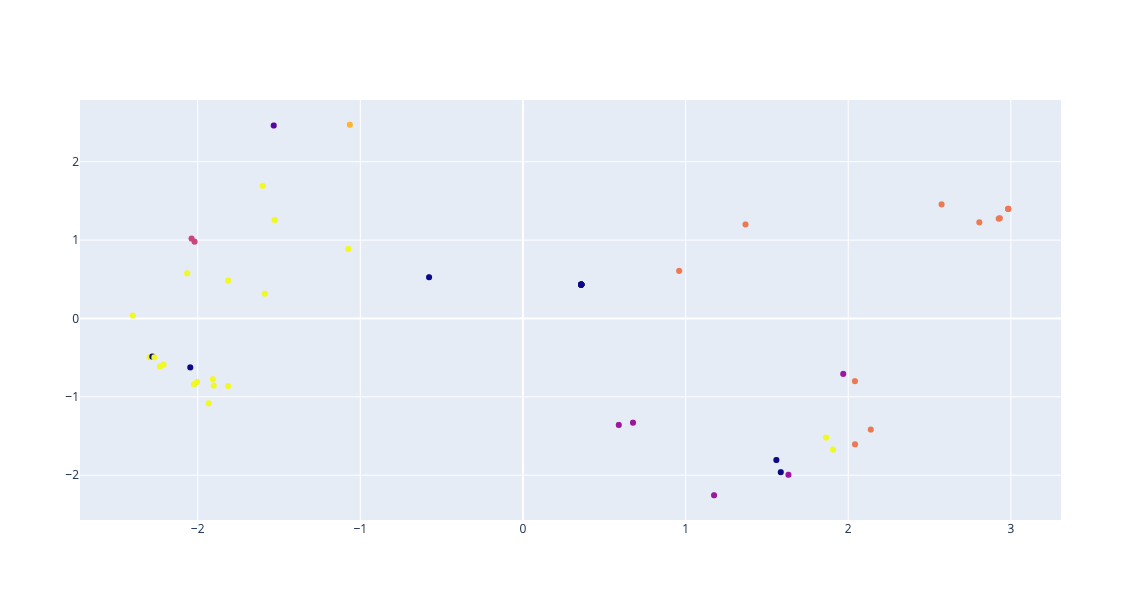

In [80]:
fig = go.Figure(data=go.Scatter(x=plot_df_metrics['pc0'],
                                y=plot_df_metrics['pc1'],
                                mode='markers',
                                marker_color=plot_df_metrics['best_dataset_no'],
                                text=plot_df_metrics["text"])) # hover text goes here


fig.update_layout(
    autosize=False,
    width=800,
    height=600,
)

# fig.update_layout(title='Population of USA States')
fig.show()

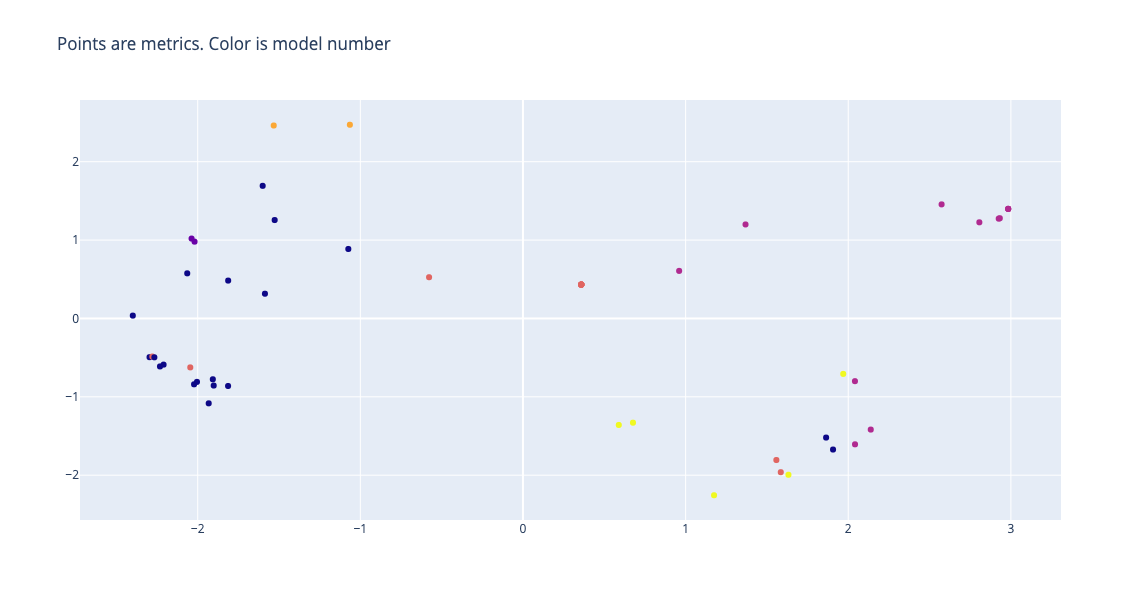

In [81]:
fig = go.Figure(data=go.Scatter(x=plot_df_metrics['pc0'],
                                y=plot_df_metrics['pc1'],
                                mode='markers',
                                marker_color=plot_df_metrics['best_model_no'],
                                text=plot_df_metrics["text"])) # hover text goes here


fig.update_layout(
    autosize=False,
    width=800,
    height=600,
    title = "Points are metrics. Color is model number"
)

# fig.update_layout(title='Population of USA States')
fig.show()

#### points are datasets

In [82]:
scaled_vals_df.transpose()

0         1         2         3         4         5         6   \
0 -0.305463  0.346644 -0.521495 -0.601660 -0.420475 -0.450116  0.377964   
1 -0.169716 -0.853385  1.691511  1.664756 -0.412447 -0.450116  0.377964   
2 -0.335941  0.235928 -0.620587 -0.423317 -0.405940 -0.450116  0.377964   
3 -0.659155 -0.938731 -0.386192 -0.671175 -0.242165  0.097851  0.377964   
4  2.565402  1.870706 -0.901807 -0.781261  2.640977  2.602844 -2.645751   
5 -0.305145 -0.932832  1.699739  1.666040 -0.413127 -0.450116  0.377964   
6 -0.809787 -0.814974 -0.770645 -0.920011 -0.425148 -0.450116  0.377964   
7  0.019806  1.086644 -0.190523  0.066628 -0.321675 -0.450116  0.377964   

         7         8         9   ...        42        43        44        45  \
0  0.507020 -0.777772 -0.601390  ...  0.084778  0.237221 -0.207897 -0.154845   
1  0.507020  0.316537 -0.320436  ... -0.326215 -0.481078  0.196152  0.109931   
2  0.507020 -0.662925 -0.477410  ...  0.295740  0.230074 -0.678177 -0.668947   
3 -0.564419  2.249007  0.222477  ... -0.696902 -0.681173 -0.249443 -0.199105   
4 -2.477703 -0.883521  2.560455  ...  0.896284  1.732713  2.163093  2.254152   
5  0.507020 -0.273472 -0.374064  ... -0.401584 -0.485454 -0.051478 -0.081012   
6  0.507020 -0.670023 -0.667144  ... -1.706181 -1.655441 -1.592964 -1.523121   
7  0.507020  0.702170 -0.342489  ...  1.854081  1.103138  0.420713  0.262948   

         46   47   48   49        50        51  
0  0.384795  0.0  0.0  0.0 -0.022652 -0.445646  
1  0.901841  0.0  0.0  0.0 -0.342216  0.142918  
2 -1.261496  0.0  0.0  0.0 -0.383356 -0.585533  
3  0.380857  0.0  0.0  0.0 -0.506371 -0.462782  
4 -1.258005  0.0  0.0  0.0  1.546555  2.248129  
5  1.378643  0.0  0.0  0.0 -0.341706 -0.098668  
6 -1.179911  0.0  0.0  0.0 -1.551384 -1.358741  
7  0.653276  0.0  0.0  0.0  1.601130  0.560324  

[8 rows x 52 columns]

In [83]:
pcs = PCA(n_components=2).fit_transform(scaled_vals_df.transpose())
pcs.shape

(8, 2)

In [84]:
tsne = TSNE(n_components=2, perplexity=2).fit_transform(scaled_vals_df.transpose())
tsne.shape

/Users/kylenickerson/opt/anaconda3/envs/py37_bf/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

/Users/kylenickerson/opt/anaconda3/envs/py37_bf/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



(8, 2)

In [85]:
d = {
    "pc0": pcs[:,0],
    "pc1": pcs[:,1],
    "tsne0": tsne[:,0],
    "tsne1": tsne[:,1],
}


In [86]:
plot_df_datasets = pd.merge(result_df, pd.DataFrame.from_dict(d), left_index=True, right_index=True).drop(columns=["index"])

best_on_each_metric = np.argmin(scaled_vals_df.to_numpy(), axis=1)
plot_df_datasets["best_count"] = np.array([sum(best_on_each_metric==x) for x in range(len(result_df)) ])
plot_df_datasets["best_prop"] = plot_df_datasets["best_count"] / sum(plot_df_datasets["best_count"])

worst_on_each_metric = np.argmax(scaled_vals_df.to_numpy(), axis=1)
plot_df_datasets["worst_count"] = np.array([sum(worst_on_each_metric==x) for x in range(len(result_df)) ])
plot_df_datasets["worst_prop"] = plot_df_datasets["worst_count"] / sum(plot_df_datasets["worst_count"])

plot_df_datasets

ave_rank                                           filename  \
0  4.250000  h-gen_v2b-nd__nld_4-dm_128-nh_2-i_2-dr_0__1-op...   
1  4.833333  f-czech-700__epoch-1000_bs-50_lr-g0001-d0001-a...   
2  4.250000  gen_v2b-nc__nld_4-dm_128-nh_2-i_1-dr_0__1-opt_...   
3  3.833333               h-gtg_0-hd_24-nl_4-bs_32--len_80.csv   
4  6.166667  h-gen_v2a__nld_4-dm_128-nh_2-i_1-dr_0__1-opt_a...   
5  4.583333  f-czech-700__epoch-1000_bs-200_lr-g0005-d0005-...   
6  1.750000  h-gen_v2b__nld_4-dm_128-nh_2-i_0-dr_0__1-opt_a...   
7  6.333333  h-gen_v2b-v__nld_4-dm_128-nh_2-i_0-dr_0__1-opt...   

                           short_labels_2        pc0       pc1       tsne0  \
0  nd__nld_4-dm_128-nh_--am-lwi_0-bs_64--  -1.268152 -1.800569   95.403763   
1  0__epoch-1000_bs-50_--_epoch_id-499.cs  -3.507632  4.868781 -419.372131   
2  __nld_4-dm_128-nh_2----lwi_0-bs_64--vf  -0.533318 -3.713852  126.971558   
3                  _24-nl_4-bs_32--len_--  -0.500143 -1.136852   67.020996   
4  _nld_4-dm_128-nh_2-i--lwi_0-bs_64--vf1  12.149977  1.866639  389.524048   
5  0__epoch-1000_bs-200--5_epoch_id-299.c  -3.909474  5.018763 -512.089661   
6  _nld_4-dm_128-nh_2-i--lwi_0-bs_64--vf1  -3.369730 -3.243880  -93.421608   
7  v__nld_4-dm_128-nh_2--m-lwi_0-bs_64--v   0.938471 -1.859030  203.128723   

        tsne1  best_count  best_prop  worst_count  worst_prop  
0   60.431328          12   0.230769           14    0.269231  
1 -473.242615           1   0.019231            3    0.057692  
2  274.713287           5   0.096154            1    0.019231  
3  -86.010490           2   0.038462            4    0.076923  
4  128.253448          12   0.230769           19    0.365385  
5 -417.431091           1   0.019231            7    0.134615  
6  181.294754          19   0.365385            1    0.019231  
7  146.087387           0   0.000000            3    0.057692

In [87]:
plot_df_datasets["shortname"] = plot_df_datasets.filename.apply(lambda x: x[:6])
plot_df_datasets

ave_rank                                           filename  \
0  4.250000  h-gen_v2b-nd__nld_4-dm_128-nh_2-i_2-dr_0__1-op...   
1  4.833333  f-czech-700__epoch-1000_bs-50_lr-g0001-d0001-a...   
2  4.250000  gen_v2b-nc__nld_4-dm_128-nh_2-i_1-dr_0__1-opt_...   
3  3.833333               h-gtg_0-hd_24-nl_4-bs_32--len_80.csv   
4  6.166667  h-gen_v2a__nld_4-dm_128-nh_2-i_1-dr_0__1-opt_a...   
5  4.583333  f-czech-700__epoch-1000_bs-200_lr-g0005-d0005-...   
6  1.750000  h-gen_v2b__nld_4-dm_128-nh_2-i_0-dr_0__1-opt_a...   
7  6.333333  h-gen_v2b-v__nld_4-dm_128-nh_2-i_0-dr_0__1-opt...   

                           short_labels_2        pc0       pc1       tsne0  \
0  nd__nld_4-dm_128-nh_--am-lwi_0-bs_64--  -1.268152 -1.800569   95.403763   
1  0__epoch-1000_bs-50_--_epoch_id-499.cs  -3.507632  4.868781 -419.372131   
2  __nld_4-dm_128-nh_2----lwi_0-bs_64--vf  -0.533318 -3.713852  126.971558   
3                  _24-nl_4-bs_32--len_--  -0.500143 -1.136852   67.020996   
4  _nld_4-dm_128-nh_2-i--lwi_0-bs_64--vf1  12.149977  1.866639  389.524048   
5  0__epoch-1000_bs-200--5_epoch_id-299.c  -3.909474  5.018763 -512.089661   
6  _nld_4-dm_128-nh_2-i--lwi_0-bs_64--vf1  -3.369730 -3.243880  -93.421608   
7  v__nld_4-dm_128-nh_2--m-lwi_0-bs_64--v   0.938471 -1.859030  203.128723   

        tsne1  best_count  best_prop  worst_count  worst_prop shortname  
0   60.431328          12   0.230769           14    0.269231    h-gen_  
1 -473.242615           1   0.019231            3    0.057692    f-czec  
2  274.713287           5   0.096154            1    0.019231    gen_v2  
3  -86.010490           2   0.038462            4    0.076923    h-gtg_  
4  128.253448          12   0.230769           19    0.365385    h-gen_  
5 -417.431091           1   0.019231            7    0.134615    f-czec  
6  181.294754          19   0.365385            1    0.019231    h-gen_  
7  146.087387           0   0.000000            3    0.057692    h-gen_

In [88]:
text_parts = []
text_parts.append(plot_df_datasets.shortname)
text_parts.append(plot_df_datasets.best_count.astype(str) )
text_parts.append(plot_df_datasets.worst_count.astype(str) )
text_parts.append(plot_df_datasets.ave_rank.round(1).astype(str) )

s = ""
for part in text_parts:
    s += part + "__"

plot_df_datasets["text"] = s
plot_df_datasets

ave_rank                                           filename  \
0  4.250000  h-gen_v2b-nd__nld_4-dm_128-nh_2-i_2-dr_0__1-op...   
1  4.833333  f-czech-700__epoch-1000_bs-50_lr-g0001-d0001-a...   
2  4.250000  gen_v2b-nc__nld_4-dm_128-nh_2-i_1-dr_0__1-opt_...   
3  3.833333               h-gtg_0-hd_24-nl_4-bs_32--len_80.csv   
4  6.166667  h-gen_v2a__nld_4-dm_128-nh_2-i_1-dr_0__1-opt_a...   
5  4.583333  f-czech-700__epoch-1000_bs-200_lr-g0005-d0005-...   
6  1.750000  h-gen_v2b__nld_4-dm_128-nh_2-i_0-dr_0__1-opt_a...   
7  6.333333  h-gen_v2b-v__nld_4-dm_128-nh_2-i_0-dr_0__1-opt...   

                           short_labels_2        pc0       pc1       tsne0  \
0  nd__nld_4-dm_128-nh_--am-lwi_0-bs_64--  -1.268152 -1.800569   95.403763   
1  0__epoch-1000_bs-50_--_epoch_id-499.cs  -3.507632  4.868781 -419.372131   
2  __nld_4-dm_128-nh_2----lwi_0-bs_64--vf  -0.533318 -3.713852  126.971558   
3                  _24-nl_4-bs_32--len_--  -0.500143 -1.136852   67.020996   
4  _nld_4-dm_128-nh_2-i--lwi_0-bs_64--vf1  12.149977  1.866639  389.524048   
5  0__epoch-1000_bs-200--5_epoch_id-299.c  -3.909474  5.018763 -512.089661   
6  _nld_4-dm_128-nh_2-i--lwi_0-bs_64--vf1  -3.369730 -3.243880  -93.421608   
7  v__nld_4-dm_128-nh_2--m-lwi_0-bs_64--v   0.938471 -1.859030  203.128723   

        tsne1  best_count  best_prop  worst_count  worst_prop shortname  \
0   60.431328          12   0.230769           14    0.269231    h-gen_   
1 -473.242615           1   0.019231            3    0.057692    f-czec   
2  274.713287           5   0.096154            1    0.019231    gen_v2   
3  -86.010490           2   0.038462            4    0.076923    h-gtg_   
4  128.253448          12   0.230769           19    0.365385    h-gen_   
5 -417.431091           1   0.019231            7    0.134615    f-czec   
6  181.294754          19   0.365385            1    0.019231    h-gen_   
7  146.087387           0   0.000000            3    0.057692    h-gen_   

                    text  
0  h-gen___12__14__4.2__  
1    f-czec__1__3__4.8__  
2    gen_v2__5__1__4.2__  
3    h-gtg___2__4__3.8__  
4  h-gen___12__19__6.2__  
5    f-czec__1__7__4.6__  
6   h-gen___19__1__1.8__  
7    h-gen___0__3__6.3__

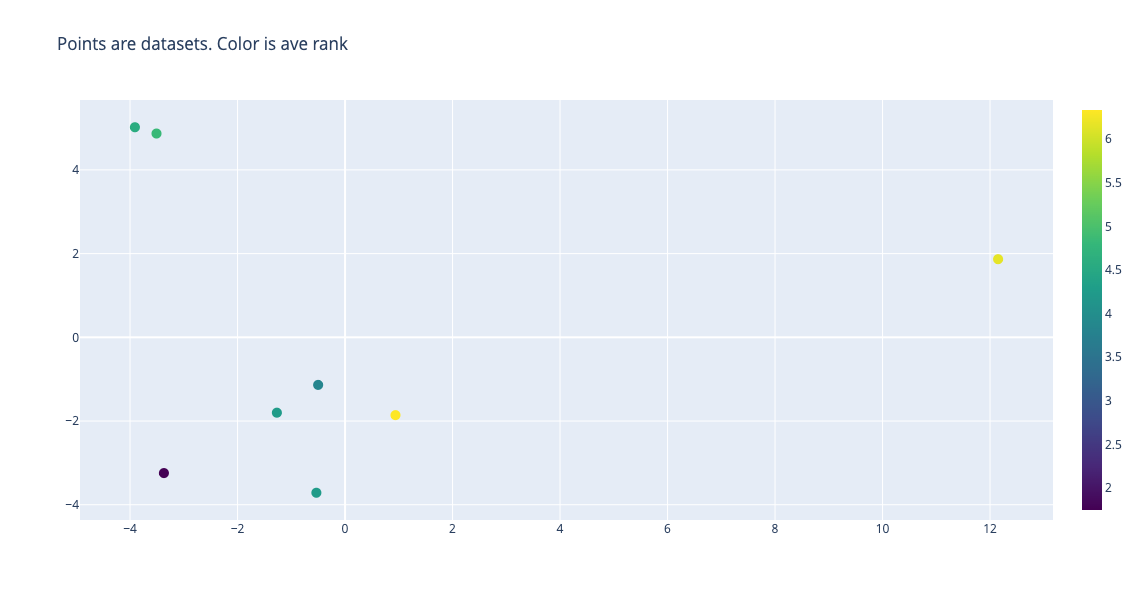

In [89]:
fig = go.Figure(data=go.Scatter(x=plot_df_datasets['pc0'],
                                y=plot_df_datasets['pc1'],
                                mode='markers',
#                                 marker_color=plot_df_datasets['ave_rank'],
                                marker=dict(color= plot_df_datasets['ave_rank'], 
                                  colorscale='Viridis', size=10, colorbar=dict(thickness=20)),
                                text=plot_df_datasets["text"])) # hover text goes here


fig.update_layout(
    autosize=False,
    width=800,
    height=600,
    title = "Points are datasets. Color is ave rank"
)

# fig.update_layout(title='Population of USA States')
fig.show()

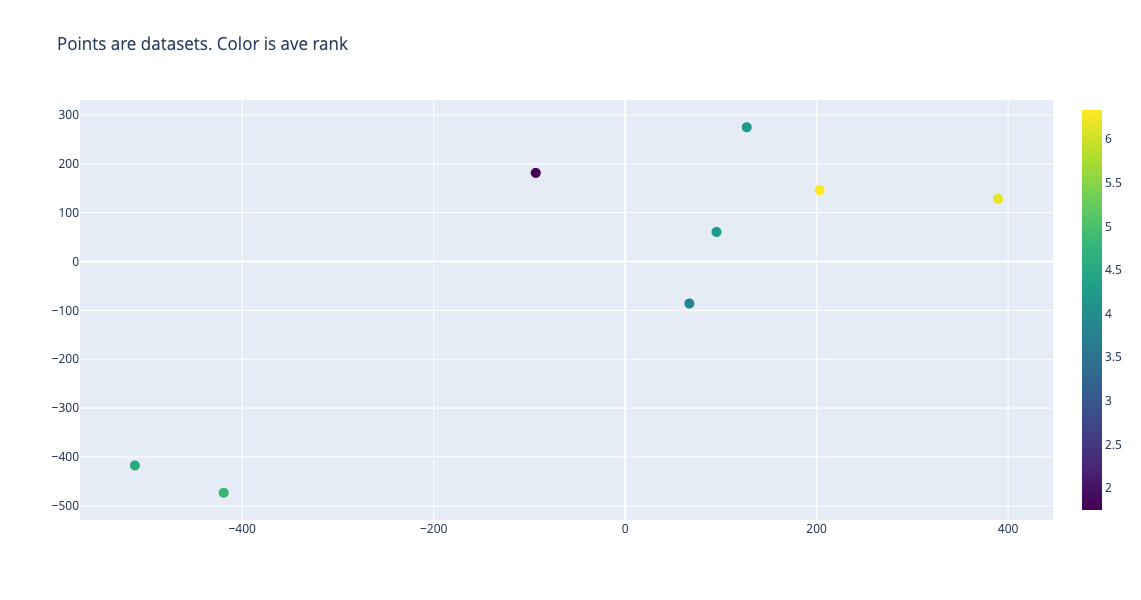

In [90]:
fig = go.Figure(data=go.Scatter(x=plot_df_datasets['tsne0'],
                                y=plot_df_datasets['tsne1'],
                                mode='markers',
#                                 marker_color=plot_df_datasets['ave_rank'],
                                marker=dict(color= plot_df_datasets['ave_rank'], 
                                  colorscale='Viridis', size=10, colorbar=dict(thickness=20)),
                                text=plot_df_datasets["text"])) # hover text goes here


fig.update_layout(
    autosize=False,
    width=800,
    height=600,
    title = "Points are datasets. Color is ave rank"
)

# fig.update_layout(title='Population of USA States')
fig.show()

In [91]:
plot_df_datasets.filename[1]

'f-czech-700__epoch-1000_bs-50_lr-g0001-d0001-a0001_epoch_id-499.csv'

### Really cluster

In [92]:
from sklearn import cluster

In [93]:
cl = cluster.KMeans(n_clusters=5)


In [94]:
scaled_vals_df

0             1             2             3             4  \
0  -3.054628e-01 -1.697164e-01 -3.359410e-01 -6.591552e-01  2.565402e+00   
1   3.466436e-01 -8.533848e-01  2.359276e-01 -9.387313e-01  1.870706e+00   
2  -5.214951e-01  1.691511e+00 -6.205873e-01 -3.861921e-01 -9.018070e-01   
3  -6.016603e-01  1.664756e+00 -4.233175e-01 -6.711753e-01 -7.812608e-01   
4  -4.204753e-01 -4.124472e-01 -4.059398e-01 -2.421652e-01  2.640977e+00   
5  -4.501159e-01 -4.501159e-01 -4.501159e-01  9.785129e-02  2.602844e+00   
6   3.779645e-01  3.779645e-01  3.779645e-01  3.779645e-01 -2.645751e+00   
7   5.070204e-01  5.070204e-01  5.070204e-01 -5.644189e-01 -2.477703e+00   
8  -7.777718e-01  3.165366e-01 -6.629253e-01  2.249007e+00 -8.835215e-01   
9  -6.013896e-01 -3.204360e-01 -4.774095e-01  2.224770e-01  2.560455e+00   
10 -6.602579e-01 -2.804171e-01 -5.750851e-01  7.721978e-01  2.376257e+00   
11  3.779645e-01  3.779645e-01  3.779645e-01  3.779645e-01 -2.645751e+00   
12  3.739669e-01  2.411567e-01  1.017012e+00 -1.080846e+00 -2.171567e+00   
13  7.011802e-01  4.048680e-01 -8.478010e-01  1.771155e+00 -1.385658e+00   
14 -6.090579e-01 -6.155714e-01  6.774164e-02 -3.075715e-01  2.516577e+00   
15  4.451925e-01 -1.697190e+00  5.987684e-01  5.293254e-01  9.980656e-01   
16 -7.494139e-01  1.638922e+00 -9.206208e-01 -3.206523e-01  1.365817e-01   
17  5.040151e-01  5.040151e-01  5.040151e-01 -5.365322e-01 -2.487558e+00   
18  5.095212e-01  6.391477e-01 -1.897501e+00  7.333759e-01  4.519380e-01   
19 -1.050870e+00 -6.546548e-01  6.125905e-01  2.524189e-01  1.918390e+00   
20 -4.473218e-01 -1.093808e+00  9.794672e-01  8.550692e-01  1.099081e+00   
21 -6.361723e-01  1.725288e+00 -6.489870e-01 -5.564943e-01 -3.589797e-01   
22 -7.313349e-01  1.542903e+00 -5.041156e-01 -5.675261e-01 -3.364419e-01   
23  7.151283e-01  7.087840e-01 -1.953679e+00  5.825890e-01  3.689850e-01   
24  4.375038e-01  9.430918e-01 -1.262218e+00  4.308755e-01 -1.277461e+00   
25  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
26  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
27  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
28 -9.977110e-01 -5.389062e-01  1.128836e+00 -9.971809e-01  1.084348e+00   
29 -1.153594e-01  1.563916e+00 -8.521821e-01 -1.810237e-01 -1.085655e+00   
30 -5.776763e-01  1.641712e+00 -5.736028e-01 -2.332246e-01 -7.869129e-01   
31  5.551115e-17  5.551115e-17  5.551115e-17  5.551115e-17  5.551115e-17   
32  6.752945e-01 -1.624236e+00  1.207992e-01  1.127166e+00  5.662832e-01   
33 -1.006523e+00  1.629183e+00 -7.772550e-02 -8.615531e-01 -2.662383e-01   
34  2.427179e-01 -6.550174e-01  5.891834e-01 -9.918739e-01  1.275667e+00   
35 -1.820747e-01  1.247188e-01 -5.945314e-01 -3.232139e-01  2.360692e+00   
36  3.309750e-01 -8.469961e-01  1.990678e-01 -9.572686e-01  1.863290e+00   
37 -3.869088e-01  1.765614e-01 -4.755902e-01 -6.006018e-01  2.428355e+00   
38 -2.090450e-01 -5.665390e-02 -9.934248e-01 -6.933247e-02  2.416036e+00   
39 -4.584014e-01 -4.666208e-01 -4.593091e-01  2.057477e-01  2.580519e+00   
40  3.779645e-01  3.779645e-01  3.779645e-01  3.779645e-01 -2.645751e+00   
41  5.843595e-01  5.591073e-01  5.815537e-01 -8.519467e-01 -2.352119e+00   
42  8.477795e-02 -3.262153e-01  2.957396e-01 -6.969019e-01  8.962836e-01   
43  2.372210e-01 -4.810776e-01  2.300738e-01 -6.811731e-01  1.732713e+00   
44 -2.078974e-01  1.961524e-01 -6.781767e-01 -2.494426e-01  2.163093e+00   
45 -1.548451e-01  1.099308e-01 -6.689467e-01 -1.991053e-01  2.254152e+00   
46  3.847954e-01  9.018407e-01 -1.261496e+00  3.808566e-01 -1.258005e+00   
47  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
48  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
49  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
50 -2.265185e-02 -3.422164e-01 -3.833556e-01 -5.063707e-01  1.546555e+00   
51 -4.456463e-01  1.429178e-01 -5.855329e-01 -4.627823e-01  2.2

In [95]:
cl.fit(scaled_vals_df)

KMeans(n_clusters=5)

In [96]:
cl.labels_

array([2, 4, 0, 0, 2, 2, 3, 3, 1, 2, 2, 3, 3, 1, 2, 4, 0, 3, 1, 4, 4, 0,
       0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 4, 0, 4, 2, 4, 2, 2, 2, 3, 3, 4, 4,
       2, 2, 0, 1, 1, 1, 4, 2], dtype=int32)

In [97]:
cl.labels_==0

array([False, False,  True,  True, False, False, False, False, False,
       False, False, False, False, False, False, False,  True, False,
       False, False, False,  True,  True, False,  True, False, False,
       False, False,  True,  True, False, False,  True, False, False,
       False, False, False, False, False, False, False, False, False,
       False,  True, False, False, False, False, False])

In [98]:
# xticklabels=full_vals_df["index"][~zero_var_cols], yticklabels=full_vals_df["index"][~zero_var_cols]

In [99]:
full_vals_df["index"][cl.labels_==0]

2                             td-ks
3                         td-wasser
16    tcode_1-grams_mean-coverage_r
21    tcode_3-grams_mean-coverage_r
22    tcode_3-grams_mean-coverage_g
24           dates_1-grams_mean-jsd
29           dates_3-grams_mean-jsd
30           dates_3-grams_mean-jac
33           dates_3-grams_mean-NED
46           joint-tcodes-dates_jsd
Name: index, dtype: object

In [100]:
for i in range(max(cl.labels_)+1):
    print(i)
    display(full_vals_df["index"][cl.labels_==i])
    print("\n\n")

0


2                             td-ks
3                         td-wasser
16    tcode_1-grams_mean-coverage_r
21    tcode_3-grams_mean-coverage_r
22    tcode_3-grams_mean-coverage_g
24           dates_1-grams_mean-jsd
29           dates_3-grams_mean-jsd
30           dates_3-grams_mean-jac
33           dates_3-grams_mean-NED
46           joint-tcodes-dates_jsd
Name: index, dtype: object




1


8            codes_1-grams_mean-NED
13           codes_3-grams_mean-NED
18           tcode_1-grams_mean-NED
23           tcode_3-grams_mean-NED
25           dates_1-grams_mean-jac
26    dates_1-grams_mean-coverage_r
27    dates_1-grams_mean-coverage_g
28           dates_1-grams_mean-NED
31    dates_3-grams_mean-coverage_r
47           joint-tcodes-dates_jac
48    joint-tcodes-dates_coverage_r
49    joint-tcodes-dates_coverage_g
Name: index, dtype: object




2


0                   raw_amount-ks
4          codes_1-grams_mean-jsd
5          codes_1-grams_mean-jac
9          codes_3-grams_mean-jsd
10         codes_3-grams_mean-jac
14         tcode_1-grams_mean-jsd
35      joint-codes-raw_amount_ks
37      joint-tcode-raw_amount_ks
38          joint-codes-dates_jsd
39          joint-codes-dates_jac
44       joint-codes-dates-amt_ks
45    *r-joint-codes-dates-amt_ks
51       joint-tcode-dates-amt_ks
Name: index, dtype: object




3


6     codes_1-grams_mean-coverage_r
7     codes_1-grams_mean-coverage_g
11    codes_3-grams_mean-coverage_r
12    codes_3-grams_mean-coverage_g
17    tcode_1-grams_mean-coverage_g
40     joint-codes-dates_coverage_r
41     joint-codes-dates_coverage_g
Name: index, dtype: object




4


1                   raw_amount-wasser
15             tcode_1-grams_mean-jac
19             tcode_3-grams_mean-jsd
20             tcode_3-grams_mean-jac
32      dates_3-grams_mean-coverage_g
34      joint-codes-raw_amount_wasser
36      joint-tcode-raw_amount_wasser
42       joint-codes-dates-amt_wasser
43    *r-joint-codes-dates-amt_wasser
50       joint-tcode-dates-amt_wasser
Name: index, dtype: object

In [101]:
from sklearn import metrics

metric_list = {
       "sil" : metrics.silhouette_score,
        "chs": metrics.calinski_harabasz_score,
        "dbi": metrics.davies_bouldin_score 
}



all_res = {}
all_models = {}
for k in range(3, 25):
    
    res = {}
    all_res[k] = res
    
    kmeans_model = cluster.KMeans(n_clusters=k).fit(scaled_vals_df)
    labels = kmeans_model.labels_
    
    all_models[k] = kmeans_model
    
    for name, fn in metric_list.items():
        
        res[name] = fn(scaled_vals_df, labels)
        
        

In [102]:
df = pd.DataFrame.from_dict(all_res)
df

3          4          5          6          7          8   \
sil   0.415820   0.468360   0.468637   0.490250   0.537462   0.566437   
chs  34.462612  35.336919  36.109026  35.499890  38.592498  44.014877   
dbi   1.117186   0.975725   0.960751   0.848938   0.712172   0.636264   

            9          10         11         12  ...         15         16  \
sil   0.558143   0.570877   0.571754   0.596446  ...   0.572802   0.563138   
chs  46.843575  50.269033  57.673198  66.853827  ...  82.061217  88.965133   
dbi   0.630404   0.631887   0.546336   0.492363  ...   0.543123   0.486563   

            17         18          19          20          21          22  \
sil   0.545809   0.542617    0.539927    0.519023    0.520685    0.515017   
chs  93.829073  92.125269  103.020783  103.094292  106.212023  114.301470   
dbi   0.509110   0.419983    0.458106    0.448284    0.394731    0.385387   

             23          24  
sil    0.487529    0.476299  
chs  119.883179  121.603296  
dbi    0.373298    0.384685  

[3 rows x 22 columns]

In [103]:
df == df.max(axis=1)

/Users/kylenickerson/opt/anaconda3/envs/py37_bf/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning:

Automatic reindexing on DataFrame vs Series comparisons is deprecated and will raise ValueError in a future version.  Do `left, right = left.align(right, axis=1, copy=False)` before e.g. `left == right`



3      4      5      6      7      8      9     10     11     12  \
sil  False  False  False  False  False  False  False  False  False  False   
chs  False  False  False  False  False  False  False  False  False  False   
dbi  False  False  False  False  False  False  False  False  False  False   

     ...     18     19     20     21     22     23     24    chs    dbi    sil  
sil  ...  False  False  False  False  False  False  False  False  False  False  
chs  ...  False  False  False  False  False  False  False  False  False  False  
dbi  ...  False  False  False  False  False  False  False  False  False  False  

[3 rows x 25 columns]

In [104]:
vals = df.iloc
np.argmax(vals[:2,:].to_numpy(), axis=1)

array([10, 21])

In [105]:
vals = df.iloc
np.argmin(vals[2:,:].to_numpy(), axis=1)

array([20])

In [106]:
df.to_numpy()

array([[  0.41581969,   0.46836025,   0.4686369 ,   0.49025042,
          0.53746199,   0.56643658,   0.55814271,   0.57087739,
          0.57175398,   0.59644626,   0.60527805,   0.59027851,
          0.57280221,   0.56313816,   0.54580893,   0.54261678,
          0.53992722,   0.519023  ,   0.5206848 ,   0.51501712,
          0.48752882,   0.47629891],
       [ 34.46261234,  35.33691911,  36.10902637,  35.49989043,
         38.59249803,  44.01487739,  46.84357455,  50.26903255,
         57.67319801,  66.85382679,  70.97667302,  77.72157769,
         82.06121687,  88.96513279,  93.82907348,  92.1252687 ,
        103.02078252, 103.09429155, 106.21202298, 114.30146973,
        119.88317881, 121.60329605],
       [  1.11718616,   0.97572532,   0.96075054,   0.84893798,
          0.71217195,   0.63626366,   0.63040366,   0.63188684,
          0.54633556,   0.49236329,   0.46572857,   0.51163934,
          0.54312313,   0.48656271,   0.50910992,   0.41998321,
          0.45810581,   0.4482

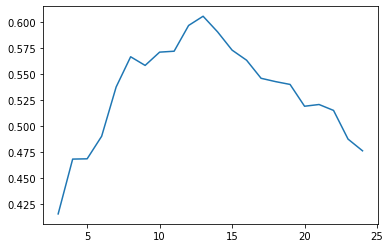

In [107]:
plt.plot(df.iloc[0,:])

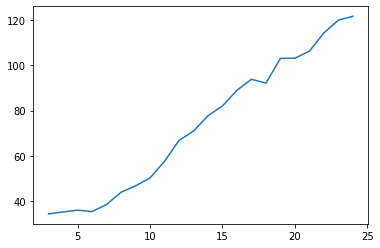

In [108]:
plt.plot(df.iloc[1,:])

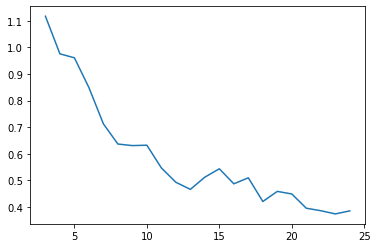

In [109]:
plt.plot(df.iloc[2,:])

In [110]:
!jupyter --version

Selected Jupyter core packages...
IPython          : 7.31.1
ipykernel        : 6.4.1
ipywidgets       : 7.6.5
jupyter_client   : 6.1.12
jupyter_core     : 4.9.1
jupyter_server   : 1.4.1
jupyterlab       : 3.2.1
nbclient         : 0.5.3
nbconvert        : 6.3.0
nbformat         : 5.1.3
notebook         : 6.4.6
qtconsole        : 5.2.2
traitlets        : 5.1.1


In [111]:
k = 15

cl = cluster.KMeans(n_clusters=15).fit(scaled_vals_df)

for i in range(max(cl.labels_)+1):
    print(i)
    display(full_vals_df["index"][cl.labels_==i])
    print("\n\n")

0


18    tcode_1-grams_mean-NED
23    tcode_3-grams_mean-NED
Name: index, dtype: object




1


25           dates_1-grams_mean-jac
26    dates_1-grams_mean-coverage_r
27    dates_1-grams_mean-coverage_g
31    dates_3-grams_mean-coverage_r
47           joint-tcodes-dates_jac
48    joint-tcodes-dates_coverage_r
49    joint-tcodes-dates_coverage_g
Name: index, dtype: object




2


0                   raw_amount-ks
35      joint-codes-raw_amount_ks
37      joint-tcode-raw_amount_ks
38          joint-codes-dates_jsd
44       joint-codes-dates-amt_ks
45    *r-joint-codes-dates-amt_ks
51       joint-tcode-dates-amt_ks
Name: index, dtype: object




3


6     codes_1-grams_mean-coverage_r
11    codes_3-grams_mean-coverage_r
40     joint-codes-dates_coverage_r
Name: index, dtype: object




4


2                      td-ks
3                  td-wasser
29    dates_3-grams_mean-jsd
30    dates_3-grams_mean-jac
Name: index, dtype: object




5


1                 raw_amount-wasser
34    joint-codes-raw_amount_wasser
36    joint-tcode-raw_amount_wasser
Name: index, dtype: object




6


15           tcode_1-grams_mean-jac
32    dates_3-grams_mean-coverage_g
Name: index, dtype: object




7


24    dates_1-grams_mean-jsd
46    joint-tcodes-dates_jsd
Name: index, dtype: object




8


19    tcode_3-grams_mean-jsd
20    tcode_3-grams_mean-jac
Name: index, dtype: object




9


8     codes_1-grams_mean-NED
13    codes_3-grams_mean-NED
Name: index, dtype: object




10


28    dates_1-grams_mean-NED
Name: index, dtype: object




11


4     codes_1-grams_mean-jsd
5     codes_1-grams_mean-jac
9     codes_3-grams_mean-jsd
10    codes_3-grams_mean-jac
14    tcode_1-grams_mean-jsd
39     joint-codes-dates_jac
Name: index, dtype: object




12


42       joint-codes-dates-amt_wasser
43    *r-joint-codes-dates-amt_wasser
50       joint-tcode-dates-amt_wasser
Name: index, dtype: object




13


16    tcode_1-grams_mean-coverage_r
21    tcode_3-grams_mean-coverage_r
22    tcode_3-grams_mean-coverage_g
33           dates_3-grams_mean-NED
Name: index, dtype: object




14


7     codes_1-grams_mean-coverage_g
12    codes_3-grams_mean-coverage_g
17    tcode_1-grams_mean-coverage_g
41     joint-codes-dates_coverage_g
Name: index, dtype: object

### next

In [112]:
final_rank_df.measures.unique()

array(['raw_amount', 'td', 'codes_1-grams', 'codes_3-grams',
       'tcode_1-grams', 'tcode_3-grams', 'dates_1-grams', 'dates_3-grams',
       'codes, raw_amount', 'tcode, raw_amount', 'codes, dates',
       'codes, dates, amt', 'tcode, dates', 'tcode, dates, amt'],
      dtype=object)

In [113]:
final_rank_df.metric.unique()

array(['ks', 'wasser', 'jsd', 'jac', 'coverage_r', 'coverage_g', 'NED'],
      dtype=object)

In [114]:
df_merged

index           measures      metric  \
0                     raw_amount-ks         raw_amount          ks   
1                 raw_amount-wasser         raw_amount      wasser   
2                             td-ks                 td          ks   
3                         td-wasser                 td      wasser   
4            codes_1-grams_mean-jsd      codes_1-grams         jsd   
5            codes_1-grams_mean-jac      codes_1-grams         jac   
6     codes_1-grams_mean-coverage_r      codes_1-grams  coverage_r   
7     codes_1-grams_mean-coverage_g      codes_1-grams  coverage_g   
8            codes_1-grams_mean-NED      codes_1-grams         NED   
9            codes_3-grams_mean-jsd      codes_3-grams         jsd   
10           codes_3-grams_mean-jac      codes_3-grams         jac   
11    codes_3-grams_mean-coverage_r      codes_3-grams  coverage_r   
12    codes_3-grams_mean-coverage_g      codes_3-grams  coverage_g   
13           codes_3-grams_mean-NED      codes_3-grams         NED   
14           tcode_1-grams_mean-jsd      tcode_1-grams         jsd   
15           tcode_1-grams_mean-jac      tcode_1-grams         jac   
16    tcode_1-grams_mean-coverage_r      tcode_1-grams  coverage_r   
17    tcode_1-grams_mean-coverage_g      tcode_1-grams  coverage_g   
18           tcode_1-grams_mean-NED      tcode_1-grams         NED   
19           tcode_3-grams_mean-jsd      tcode_3-grams         jsd   
20           tcode_3-grams_mean-jac      tcode_3-grams         jac   
21    tcode_3-grams_mean-coverage_r      tcode_3-grams  coverage_r   
22    tcode_3-grams_mean-coverage_g      tcode_3-grams  coverage_g   
23           tcode_3-grams_mean-NED      tcode_3-grams         NED   
24           dates_1-grams_mean-jsd      dates_1-grams         jsd   
25           dates_1-grams_mean-jac      dates_1-grams         jac   
26    dates_1-grams_mean-coverage_r      dates_1-grams  coverage_r   
27    dates_1-grams_mean-coverage_g      dates_1-grams  coverage_g   
28           dates_1-grams_mean-NED      dates_1-grams         NED   
29           dates_3-grams_mean-jsd      dates_3-grams         jsd   
30           dates_3-grams_mean-jac      dates_3-grams         jac   
31    dates_3-grams_mean-coverage_r      dates_3-grams  coverage_r   
32    dates_3-grams_mean-coverage_g      dates_3-grams  coverage_g   
33           dates_3-grams_mean-NED      dates_3-grams         NED   
34    joint-codes-raw_amount_wasser  codes, raw_amount      wasser   
35        joint-codes-raw_amount_ks  codes, raw_amount          ks   
36    joint-tcode-raw_amount_wasser  tcode, raw_amount      wasser   
37        joint-tcode-raw_amount_ks  tcode, raw_amount          ks   
38            joint-codes-dates_jsd       codes, dates         jsd   
39            joint-codes-dates_jac       codes, dates         jac   
40     joint-codes-dates_coverage_r       codes, dates  coverage_r   
41     joint-codes-dates_coverage_g       codes, dates  coverage_g   
42     joint-codes-dates-amt_wasser  codes, dates, amt      wasser   
43  *r-joint-codes-dates-amt_wasser  codes, dates, amt      wasser   
44         joint-codes-dates-amt_ks  codes, dates, amt          ks   
45      *r-joint-codes-dates-amt_ks  codes, dates, amt          ks   
46           joint-tcodes-dates_jsd       tcode, dates         jsd   
47           joint-tcodes-dates_jac       tcode, dates         jac   
48    joint-tcodes-dates_coverage_r       tcode, dates  coverage_r   
49    joint-tcodes-dates_coverage_g       tcode, dates  coverage_g   
50     joint-tcode-dates-amt_wasser  tcode, dates, amt      wasser   
51         joint-tcode-dates-amt_ks  tcode, dates, amt          ks   
52                        gen_fname               name        None   
53                       real_fname               name        None   

                                              value_0  \
0                                            0.161694   
1                                          3704.78486   
2       

In [115]:
non_name_rows = ~(df_merged.measures == "name")
non_coverage_rows = df_merged.metric.apply(lambda x: "coverage" not in x)

In [116]:
np.logical_and(non_name_rows, non_coverage_rows).sum()

36

In [117]:
df_merged[np.logical_and(non_name_rows, non_coverage_rows)]

index           measures  metric      value_0  \
0                     raw_amount-ks         raw_amount      ks     0.161694   
1                 raw_amount-wasser         raw_amount  wasser   3704.78486   
2                             td-ks                 td      ks     0.140243   
3                         td-wasser                 td  wasser     1.176085   
4            codes_1-grams_mean-jsd      codes_1-grams     jsd     0.001866   
5            codes_1-grams_mean-jac      codes_1-grams     jac          0.0   
8            codes_1-grams_mean-NED      codes_1-grams     NED     0.019418   
9            codes_3-grams_mean-jsd      codes_3-grams     jsd     0.022299   
10           codes_3-grams_mean-jac      codes_3-grams     jac      0.11594   
13           codes_3-grams_mean-NED      codes_3-grams     NED     0.170046   
14           tcode_1-grams_mean-jsd      tcode_1-grams     jsd     0.008737   
15           tcode_1-grams_mean-jac      tcode_1-grams     jac     0.794872   
18           tcode_1-grams_mean-NED      tcode_1-grams     NED     0.073951   
19           tcode_3-grams_mean-jsd      tcode_3-grams     jsd      0.05868   
20           tcode_3-grams_mean-jac      tcode_3-grams     jac     0.690745   
23           tcode_3-grams_mean-NED      tcode_3-grams     NED     0.390601   
24           dates_1-grams_mean-jsd      dates_1-grams     jsd     0.059103   
25           dates_1-grams_mean-jac      dates_1-grams     jac          0.0   
28           dates_1-grams_mean-NED      dates_1-grams     NED     -0.27745   
29           dates_3-grams_mean-jsd      dates_3-grams     jsd     0.188882   
30           dates_3-grams_mean-jac      dates_3-grams     jac      0.38865   
33           dates_3-grams_mean-NED      dates_3-grams     NED    -0.788156   
34    joint-codes-raw_amount_wasser  codes, raw_amount  wasser  3743.898891   
35        joint-codes-raw_amount_ks  codes, raw_amount      ks     0.321596   
36    joint-tcode-raw_amount_wasser  tcode, raw_amount  wasser  3686.092399   
37        joint-tcode-raw_amount_ks  tcode, raw_amount      ks     0.233426   
38            joint-codes-dates_jsd       codes, dates     jsd      0.10593   
39            joint-codes-dates_jac       codes, dates     jac     0.148895   
42     joint-codes-dates-amt_wasser  codes, dates, amt  wasser  3975.792976   
43  *r-joint-codes-dates-amt_wasser  codes, dates, amt  wasser  4177.573575   
44         joint-codes-dates-amt_ks  codes, dates, amt      ks     0.377858   
45      *r-joint-codes-dates-amt_ks  codes, dates, amt      ks     0.382594   
46           joint-tcodes-dates_jsd       tcode, dates     jsd     0.062532   
47           joint-tcodes-dates_jac       tcode, dates     jac          0.0   
50     joint-tcode-dates-amt_wasser  tcode, dates, amt  wasser  4003.031347   
51         joint-tcode-dates-amt_ks  tcode, dates, amt      ks     0.311903   

        value_1      value_2      value_3      value_4      value_5  \
0      0.183205     0.156864     0.105645     0.616628     0.161744   
1   2048.765521  3551.998563  1930.988833  5807.966294  1939.130183   
2      0.764744      0.11228     0.178425     0.032921     0.767066   
3      5.273062     1.498473     1.050423     0.851423     5.275384   
4      0.002746     0.003459     0.021414     0.337494     0.002671   
5           0.0          0.0     0.111111     0.619048          0.0   
8      0.063346     0.024028     0.140918     0.015173     0.039662   
9      0.061542     0.039616     0.137375      0.46394     0.054051   
10     0.184712     0.131361     0.375292     0.665712     0.159254   
13      0.14079     0.017108      0.27569    -0.035997      0.02647   
14     0.007311     0.156934     0.074752     0.693147     0.007141   
15          0.0     0.851852     0.826087          1.0          0.0   
18      0.13627    -1.083243     0.181571     0.046267     0.114001   
19     0.143343     0.414126     0.337165     0.693147     0.131679   
20     0.561458     0.976079     0.951202

### next 2

In [118]:
df_merged[value_cols][non_name_rows]

value_0      value_1      value_2      value_3      value_4  \
0      0.161694     0.183205     0.156864     0.105645     0.616628   
1    3704.78486  2048.765521  3551.998563  1930.988833  5807.966294   
2      0.140243     0.764744      0.11228     0.178425     0.032921   
3      1.176085     5.273062     1.498473     1.050423     0.851423   
4      0.001866     0.002746     0.003459     0.021414     0.337494   
5           0.0          0.0          0.0     0.111111     0.619048   
6           1.0          1.0          1.0          1.0     0.690476   
7           1.0          1.0          1.0     0.888889     0.690476   
8      0.019418     0.063346     0.024028     0.140918     0.015173   
9      0.022299     0.061542     0.039616     0.137375      0.46394   
10      0.11594     0.184712     0.131361     0.375292     0.665712   
11     0.849909     0.849909     0.849909     0.849909     0.412293   
12     0.854481     0.832076     0.962963     0.609053     0.425049   
13     0.170046      0.14079     0.017108      0.27569    -0.035997   
14     0.008737     0.007311     0.156934     0.074752     0.693147   
15     0.794872          0.0     0.851852     0.826087          1.0   
16     0.205128          1.0     0.148148     0.347826          0.5   
17          1.0          1.0          1.0     0.826087          0.5   
18     0.073951      0.13627    -1.083243     0.181571     0.046267   
19      0.05868     0.143343     0.414126     0.337165     0.693147   
20     0.690745     0.561458     0.976079     0.951202          1.0   
21     0.003015     0.349365     0.001136     0.014702     0.043671   
22     0.006762     0.324951     0.038552     0.029681     0.062012   
23     0.390601     0.382679    -2.941865     0.225103    -0.041618   
24     0.059103      0.07474     0.006536     0.058898     0.006064   
25          0.0          0.0          0.0          0.0          0.0   
26          1.0          1.0          1.0          1.0          1.0   
27          1.0          1.0          1.0          1.0          1.0   
28     -0.27745    -0.220194     -0.01207    -0.277383    -0.017622   
29     0.188882     0.453922     0.072589     0.178518      0.03574   
30      0.38865     0.895163      0.38958     0.467262     0.340898   
31     0.418409     0.418409     0.418409     0.418409     0.418409   
32     0.441636     0.043181     0.345555     0.519935     0.422747   
33    -0.788156     2.198651     0.264366    -0.623875     0.050741   
34  3743.898891  2771.503108  4119.178323  2406.631775  4862.753519   
35     0.321596     0.363936     0.264675     0.302119     0.672511   
36  3686.092399  2065.278395  3504.596409  1913.550321  5794.460976   
37     0.233426     0.321778     0.219521     0.199919     0.674857   
38      0.10593     0.122669     0.019769     0.121276     0.394283   
39     0.148895     0.147611     0.148753     0.252665     0.623713   
40     0.851105     0.851105     0.851105     0.851105     0.607719   
41          1.0     0.997312     0.999701     0.847101     0.687404   
42  3975.792976   3583.44508  4177.183992  3229.575345  4750.483351   
43  4177.573575   3439.70933  4170.231658  3234.163428  5713.801373   
44     0.377858     0.428994      0.31834       0.3726     0.677927   
45     0.382594     0.417806     0.314224     0.376708     0.702961   
46     0.062532     0.079278      0.00921     0.062404     0.009323   
47          0.0          0.0          0.0          0.0          0.0   
48          1.0          1.0          1.0          1.0          1.0   
49          1.0          1.0          1.0          1.0          1.0   
50  4003.031347  3618.480297  3568.974976  3420.943629  5891.351274   
51     0.311903     0.396193     0.291869     0.309448     0.697689   

        value_5      value_6      value_7  
0      0.161744     0.081775     0.213238  
1   1939.130183  2101.772203  4725.972935  
2      0.767066     0.069934     0.233642  
3      5.275384     0.600606     2.384143  
4      0.002671     0.00

In [119]:
df_merged[value_cols][non_name_rows].describe(percentiles=[.10, .5, .9])

value_0  value_1  value_2  value_3  value_4  value_5  value_6  value_7
count      52.0     52.0     52.0     52.0     52.0     52.0     52.0     52.0
unique     43.0     42.0     44.0     46.0     44.0     42.0     44.0     43.0
top         1.0      1.0      1.0      1.0      1.0      1.0      1.0      1.0
freq        8.0      8.0      7.0      5.0      6.0      8.0      7.0      8.0

In [120]:
rand_vals = pd.DataFrame.from_records(np.random.random(size=(10,10)))
rand_vals.describe()

0          1          2          3          4          5  \
count  10.000000  10.000000  10.000000  10.000000  10.000000  10.000000   
mean    0.533404   0.691059   0.398329   0.439393   0.493022   0.494568   
std     0.215212   0.281616   0.324472   0.386570   0.368772   0.256623   
min     0.086324   0.080049   0.054126   0.043668   0.015025   0.005304   
25%     0.431560   0.523533   0.107850   0.130673   0.190679   0.467408   
50%     0.525039   0.765159   0.339639   0.285881   0.463626   0.565980   
75%     0.689663   0.900029   0.611159   0.773034   0.830674   0.658362   
max     0.861344   0.952908   0.953889   0.988134   0.978575   0.775687   

               6          7          8          9  
count  10.000000  10.000000  10.000000  10.000000  
mean    0.613391   0.516136   0.422411   0.634893  
std     0.260080   0.256705   0.314657   0.222669  
min     0.257380   0.196774   0.060240   0.243811  
25%     0.374605   0.337737   0.229240   0.478436  
50%     0.635787   0.479012   0.270381   0.636421  
75%     0.808488   0.678659   0.597192   0.779608  
max     0.991664   0.993213   0.946996   0.951085

# Narrow down what to include

In [121]:
from sklearn.preprocessing import scale

In [122]:
df_merged.measures.unique()

array(['raw_amount', 'td', 'codes_1-grams', 'codes_3-grams',
       'tcode_1-grams', 'tcode_3-grams', 'dates_1-grams', 'dates_3-grams',
       'codes, raw_amount', 'tcode, raw_amount', 'codes, dates',
       'codes, dates, amt', 'tcode, dates', 'tcode, dates, amt', 'name'],
      dtype=object)

In [123]:
non_name_rows = ~(df_merged.measures == "name")
date_metrics = df_merged.measures.apply(lambda x: "date" in x)
one_gram_metrics = df_merged.measures.apply(lambda x: "1-grams" in x)
three_grams_metrics = df_merged.measures.apply(lambda x: "3-grams" in x)
joint_metrics = df_merged.measures.apply(lambda x: "," in x)

In [124]:
homogeneous_rows = df_merged[value_cols].T.describe().T.unique == 1.0
homogeneous_rows

0     False
1     False
2     False
3     False
4     False
5     False
6     False
7     False
8     False
9     False
10    False
11    False
12    False
13    False
14    False
15    False
16    False
17    False
18    False
19    False
20    False
21    False
22    False
23    False
24    False
25     True
26     True
27     True
28    False
29    False
30    False
31     True
32    False
33    False
34    False
35    False
36    False
37    False
38    False
39    False
40    False
41    False
42    False
43    False
44    False
45    False
46    False
47     True
48     True
49     True
50    False
51    False
52    False
53     True
Name: unique, dtype: bool

In [125]:
useful_val_rows = np.logical_and(non_name_rows, ~homogeneous_rows)
useful_val_rows

0      True
1      True
2      True
3      True
4      True
5      True
6      True
7      True
8      True
9      True
10     True
11     True
12     True
13     True
14     True
15     True
16     True
17     True
18     True
19     True
20     True
21     True
22     True
23     True
24     True
25    False
26    False
27    False
28     True
29     True
30     True
31    False
32     True
33     True
34     True
35     True
36     True
37     True
38     True
39     True
40     True
41     True
42     True
43     True
44     True
45     True
46     True
47    False
48    False
49    False
50     True
51     True
52    False
53    False
dtype: bool

In [126]:
inds = np.logical_and(non_name_rows, date_metrics)
inds = np.logical_and(inds, ~homogeneous_rows)

df_merged[inds]

index           measures      metric  \
24           dates_1-grams_mean-jsd      dates_1-grams         jsd   
28           dates_1-grams_mean-NED      dates_1-grams         NED   
29           dates_3-grams_mean-jsd      dates_3-grams         jsd   
30           dates_3-grams_mean-jac      dates_3-grams         jac   
32    dates_3-grams_mean-coverage_g      dates_3-grams  coverage_g   
33           dates_3-grams_mean-NED      dates_3-grams         NED   
38            joint-codes-dates_jsd       codes, dates         jsd   
39            joint-codes-dates_jac       codes, dates         jac   
40     joint-codes-dates_coverage_r       codes, dates  coverage_r   
41     joint-codes-dates_coverage_g       codes, dates  coverage_g   
42     joint-codes-dates-amt_wasser  codes, dates, amt      wasser   
43  *r-joint-codes-dates-amt_wasser  codes, dates, amt      wasser   
44         joint-codes-dates-amt_ks  codes, dates, amt          ks   
45      *r-joint-codes-dates-amt_ks  codes, dates, amt          ks   
46           joint-tcodes-dates_jsd       tcode, dates         jsd   
50     joint-tcode-dates-amt_wasser  tcode, dates, amt      wasser   
51         joint-tcode-dates-amt_ks  tcode, dates, amt          ks   

        value_0      value_1      value_2      value_3      value_4  \
24     0.059103      0.07474     0.006536     0.058898     0.006064   
28     -0.27745    -0.220194     -0.01207    -0.277383    -0.017622   
29     0.188882     0.453922     0.072589     0.178518      0.03574   
30      0.38865     0.895163      0.38958     0.467262     0.340898   
32     0.441636     0.043181     0.345555     0.519935     0.422747   
33    -0.788156     2.198651     0.264366    -0.623875     0.050741   
38      0.10593     0.122669     0.019769     0.121276     0.394283   
39     0.148895     0.147611     0.148753     0.252665     0.623713   
40     0.851105     0.851105     0.851105     0.851105     0.607719   
41          1.0     0.997312     0.999701     0.847101     0.687404   
42  3975.792976   3583.44508  4177.183992  3229.575345  4750.483351   
43  4177.573575   3439.70933  4170.231658  3234.163428  5713.801373   
44     0.377858     0.428994      0.31834       0.3726     0.677927   
45     0.382594     0.417806     0.314224     0.376708     0.702961   
46     0.062532     0.079278      0.00921     0.062404     0.009323   
50  4003.031347  3618.480297  3568.974976  3420.943629  5891.351274   
51     0.311903     0.396193     0.291869     0.309448     0.697689   

        value_5      value_6      value_7  
24     0.089745     0.010558     0.058936  
28    -0.175321     0.033935    -0.277428  
29     0.466607     0.057451     0.203004  
30     0.915703     0.303092     0.463561  
32     0.027543     0.398899     0.397491  
33     2.195104     0.218384    -0.695655  
38     0.138226     0.013589     0.115396  
39     0.154214     0.139399     0.148895  
40     0.851105     0.851105     0.851105  
41     0.992035     0.978793          1.0  
42   3511.49559  2266.084142  5664.828447  
43  3435.213485  2233.357332   5067.07715  
44     0.397654     0.202566     0.457414  
45     0.392412      0.20063     0.438155  
46     0.094722     0.011853     0.071228  
50  3619.094241  2163.417338  5957.024269  
51     0.361595     0.181135     0.455972

In [127]:
df_merged.metric.unique()

array(['ks', 'wasser', 'jsd', 'jac', 'coverage_r', 'coverage_g', 'NED',
       'None'], dtype=object)

### herr

In [128]:
combo_metric_setup = {"big_quality": ['ks', 'wasser', 'jsd', 'jac'],
 "small_quality1": ['ks', 'jsd'],
 "small_quality2": ['wasser', 'jsd'],
 "coverage_big": ['jac', 'coverage_g'],
 "coverage_small": ['coverage_g'] }

In [129]:
np.ones(len(df_merged), dtype=bool)

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True])

In [130]:
combo_metric_rows = {}

for k, v in combo_metric_setup.items():
    
    inds = np.zeros(len(df_merged), dtype=bool)
    
    for field in v:
        
        new_inds = df_merged.metric.apply(lambda x: field in x)
        inds = np.logical_or(inds, new_inds)
        
        
    combo_metric_rows[k] = inds
    
    

combo_measures_rows = {}
for k in ['date_metrics', 'one_gram_metrics', 'three_grams_metrics', 'joint_metrics']:
    combo_measures_rows[k] = eval(k)
    
# combo_metric_rows

In [131]:
for i, rows in enumerate([date_metrics, one_gram_metrics, three_grams_metrics, joint_metrics]):
    
    inds = np.logical_and(useful_val_rows, rows)
    
    break

In [132]:
df_merged[non_name_rows][value_cols].astype(float).describe()

value_0      value_1      value_2      value_3      value_4  \
count    52.000000    52.000000    52.000000    52.000000    52.000000   
mean    448.233566   337.566034   444.354689   310.650938   631.578912   
std    1253.742001   969.988147  1245.984681   893.954646  1771.976273   
min      -0.788156    -0.220194    -2.941865    -0.623875    -0.041618   
25%       0.061675     0.132870     0.034921     0.133350     0.059194   
50%       0.349727     0.418107     0.303047     0.360213     0.617838   
75%       1.000000     1.000000     1.000000     0.904467     0.740076   
max    4177.573575  3618.480297  4177.183992  3420.943629  5891.351274   

           value_5      value_6      value_7  
count    52.000000    52.000000    52.000000  
mean    329.910986   250.552548   603.533123  
std     951.688049   699.931173  1693.402667  
min      -0.175321     0.000000    -2.331037  
25%       0.109181     0.035891     0.076926  
50%       0.395033     0.201598     0.407950  
75%       1.000000     0.984095     1.000000  
max    3619.094241  2266.084142  5957.024269

In [133]:
def plot_rank_and_block(sub_df_merged, k=3, xlabels = None, second_plot = 'block', second_plot_opts = ['b', 'rs', 'ss', 'ns'], max_show_x=15):
    
    
    new_rank_df = sub_df_merged.rank(axis=1)
    

    fig, ax = plt.subplots(1,2 ,figsize=(18, 10))
    

    if xlabels is None:
        short_xlabels = [x[:12] for x in x_labels]
    else:
        short_xlabels = xlabels

        
    colnames, ave_vals  = zip(*dict(new_rank_df.mean()).items())

    sort_inds = np.argsort(ave_vals)
    sorted_colnames = np.array(colnames)[sort_inds]
    short_xlabels = np.array(short_xlabels)[sort_inds]


    sns.heatmap(new_rank_df[sorted_colnames].iloc[:,:max_show_x], linewidths=0.1, xticklabels=short_xlabels[:max_show_x], 
                yticklabels=full_vals_df["index"][inds], cmap=sns.color_palette("vlag", as_cmap=True), ax=ax[0])

    ax[0].set_title(f"Ranks - Smaller is better")

    
    if second_plot in ['block', 'b']:
        
        block_ranks = new_rank_df.copy()

        n_val_cols = new_rank_df.shape[1]
        best_vals = block_ranks <= k
        worst_vals = block_ranks > n_val_cols - k
        mid_vals = ~np.logical_or(best_vals, worst_vals)


        block_ranks[best_vals] = 100
        block_ranks[worst_vals] = 0
        block_ranks[mid_vals] = 50
        
        colnames, ave_vals  = zip(*dict(block_ranks.mean()).items())
        
        sort_inds = np.argsort(ave_vals)
        sorted_colnames = np.array(colnames)[sort_inds]
        short_xlabels = np.array(short_xlabels)[sort_inds]

        sns.heatmap(block_ranks[sorted_colnames].iloc[:,:max_show_x], linewidths=0.1, xticklabels=short_xlabels[:max_show_x], 
                    yticklabels=full_vals_df["index"][inds], cmap=sns.color_palette("vlag_r", as_cmap=True), ax=ax[1])

        ax[1].set_title(f"Block ranks - Bigger is better")

    elif second_plot == 'rs': # raw score
        
        colnames, ave_vals  = zip(*dict(sub_df_merged.mean()).items())
        
        sort_inds = np.argsort(ave_vals)
        sorted_colnames = np.array(colnames)[sort_inds]
        short_xlabels = np.array(short_xlabels)[sort_inds]

        sns.heatmap(sub_df_merged[sorted_colnames].iloc[:,:max_show_x], linewidths=0.1, xticklabels=short_xlabels[:max_show_x], 
                    yticklabels=full_vals_df["index"][inds], cmap=sns.color_palette("vlag", as_cmap=True), ax=ax[1])

        ax[1].set_title(f"Raw score - Smaller is better")
        
        
    elif second_plot == 'ss': # scaled scores
            
        scaled_df = sub_df_merged.copy()
        
        for i in range(len(scaled_df)):
            if sum(np.abs(scaled_df.iloc[i])) > 0:
                scaled_df.iloc[i] /= sum(np.abs(scaled_df.iloc[i]))
        
        
        colnames, ave_vals  = zip(*dict(scaled_df.mean()).items())

        sort_inds = np.argsort(ave_vals)
        sorted_colnames = np.array(colnames)[sort_inds]        
        short_xlabels = np.array(short_xlabels)[sort_inds]
        
        
        sns.heatmap(scaled_df[sorted_colnames].iloc[:,:max_show_x], linewidths=0.1, xticklabels=short_xlabels[:max_show_x], 
                    yticklabels=full_vals_df["index"][inds], cmap=sns.color_palette("vlag", as_cmap=True), ax=ax[1])

        ax[1].set_title(f"Scaled score (row sums to 1) - Smaller is better")
        
        
        

        
    elif second_plot == 'ns': # Normalized scores - 0 mean, 1 sd
        
        colnames, ave_vals  = zip(*dict(sub_df_merged.mean()).items())

        sort_inds = np.argsort(ave_vals)
        sorted_colnames = np.array(colnames)[sort_inds]        
        short_xlabels = np.array(short_xlabels)[sort_inds]
        
        sns.heatmap(scale(sub_df_merged[sorted_colnames], axis=1), linewidths=0.1, xticklabels=short_xlabels[:max_show_x], 
                    yticklabels=full_vals_df["index"][inds], cmap=sns.color_palette("vlag", as_cmap=True), ax=ax[1])

        ax[1].set_title(f"Normalized score - Smaller is better")
        
        
    # plt.xticks(rotation=270)
    plt.tight_layout()
    plt.show()


In [134]:
block_ranks

value_0  value_1  value_2  value_3  value_4  value_5  value_6  value_7
0      50.0      0.0     50.0    100.0      0.0      0.0    100.0      0.0
1       0.0     50.0      0.0    100.0      0.0    100.0     50.0      0.0
2      50.0      0.0     50.0      0.0    100.0      0.0    100.0      0.0
3      50.0      0.0      0.0     50.0    100.0      0.0    100.0      0.0
4     100.0     50.0      0.0      0.0      0.0     50.0    100.0      0.0
5      50.0     50.0     50.0      0.0      0.0     50.0     50.0     50.0
6       0.0      0.0      0.0      0.0    100.0      0.0      0.0      0.0
7       0.0      0.0      0.0    100.0    100.0      0.0      0.0      0.0
8     100.0      0.0     50.0      0.0    100.0      0.0     50.0      0.0
9     100.0      0.0     50.0      0.0      0.0     50.0    100.0      0.0
10    100.0      0.0     50.0      0.0      0.0      0.0    100.0     50.0
11      0.0      0.0      0.0      0.0    100.0      0.0      0.0      0.0
12     50.0     50.0      0.0    100.0    100.0      0.0      0.0      0.0
13      0.0      0.0    100.0      0.0    100.0     50.0     50.0      0.0
14     50.0     50.0      0.0      0.0      0.0    100.0    100.0      0.0
15     50.0    100.0      0.0      0.0      0.0    100.0     50.0      0.0
16     50.0      0.0    100.0      0.0      0.0      0.0     50.0    100.0
17      0.0      0.0      0.0    100.0    100.0      0.0      0.0      0.0
18     50.0      0.0    100.0      0.0     50.0      0.0      0.0    100.0
19    100.0     50.0      0.0      0.0      0.0     50.0    100.0      0.0
20     50.0     50.0      0.0      0.0      0.0    100.0    100.0      0.0
21     50.0      0.0    100.0      0.0      0.0      0.0     50.0    100.0
22    100.0      0.0      0.0     50.0      0.0      0.0    100.0     50.0
23      0.0      0.0    100.0      0.0     50.0      0.0     50.0    100.0
24      0.0      0.0    100.0     50.0    100.0      0.0     50.0      0.0
25     50.0     50.0     50.0     50.0     50.0     50.0     50.0     50.0
26     50.0     50.0     50.0     50.0     50.0     50.0     50.0     50.0
27     50.0     50.0     50.0     50.0     50.0     50.0     50.0     50.0
28    100.0     50.0      0.0     50.0      0.0      0.0      0.0    100.0
29      0.0      0.0     50.0     50.0    100.0      0.0    100.0      0.0
30     50.0      0.0     50.0      0.0    100.0      0.0    100.0      0.0
31     50.0     50.0     50.0     50.0     50.0     50.0     50.0     50.0
32      0.0    100.0     50.0      0.0      0.0    100.0      0.0     50.0
33    100.0      0.0      0.0     50.0     50.0      0.0      0.0    100.0
34      0.0     50.0      0.0    100.0      0.0     50.0    100.0      0.0
35      0.0      0.0    100.0     50.0      0.0     50.0    100.0      0.0
36      0.0     50.0      0.0    100.0      0.0    100.0     50.0      0.0
37     50.0      0.0     50.0    100.0      0.0      0.0    100.0      0.0
38     50.0      0.0    100.0      0.0      0.0      0.0    100.0     50.0
39     50.0    100.0     50.0      0.0      0.0      0.0    100.0     50.0
40      0.0      0.0      0.0      0.0    100.0      0.0      0.0      0.0
41      0.0      0.0      0.0    100.0    100.0     50.0     50.0      0.0
42      0.0     50.0      0.0    100.0      0.0     50.0    100.0      0.0
43      0.0     50.0      0.0    100.0      0.0     50.0    100.0      0.0
44     50.0      0.0    100.0     50.0      0.0      0.0    100.0      0.0
45     50.0      0.0    100.0     50.0      0.0      0.0    100.0      0.0
46      0.0      0.0    100.0     50.0    100.0      0.0     50.0      0.0
47     50.0     50.0     50.0     50.0     50.0     50.0     50.0     50.0
48     50.0     50.0     50.0     50.0     50.0     50.0     50.0     50.0
49     50.0     50.0     50.0     50.0     50.0     50.0     50.0     50.0
50      0.0     50.0     50.0    100.0      0.0      0.0    100.0      0.0
51     50.0      0.0    100.0     50.0      0.0      0.0    100.0      0.0

In [135]:
block_ranks.mean()

value_0    39.423077
value_1    25.000000
value_2    41.346154
value_3    40.384615
value_4    38.461538
value_5    27.884615
value_6    62.500000
value_7    24.038462
dtype: float64

In [136]:
colnames, ave_vals  = zip(*dict(block_ranks.mean()).items())
colnames, ave_vals

(('value_0',
  'value_1',
  'value_2',
  'value_3',
  'value_4',
  'value_5',
  'value_6',
  'value_7'),
 (39.42307692307692,
  25.0,
  41.34615384615385,
  40.38461538461539,
  38.46153846153846,
  27.884615384615383,
  62.5,
  24.03846153846154))

In [137]:
sorted_colnames = np.array(colnames)[np.argsort(ave_vals)]
sorted_colnames

array(['value_7', 'value_1', 'value_5', 'value_4', 'value_0', 'value_3',
       'value_2', 'value_6'], dtype='<U7')

In [138]:
a = np.arange(9).reshape((3,3))
a

array([[0, 1, 2],
       [3, 4, 5],
       [6, 7, 8]])

In [139]:
scale(a, axis=1)

array([[-1.22474487,  0.        ,  1.22474487],
       [-1.22474487,  0.        ,  1.22474487],
       [-1.22474487,  0.        ,  1.22474487]])

In [140]:
short_xlabels = [x[:12] for x in x_labels]

In [141]:
def use_dataset_1(ds_name):
    for x in ["v2a-", "b_", "v2c-", "mostly", "sdv", "timegan"]:
        if x in ds_name:
            return True
        
    return False


def use_dataset_2(ds_name):
    for x in ["v2b-", "b_", "mostly", "sdv", "timegan"]:
        if x in ds_name:
            return True
        
    return False



def use_dataset_paper(ds_name):
    for x in ["v2b-", "v2a-", "b_", 'dg', "timegan", "tg", "sdv", "f-cz"]:
        if x in ds_name:
            return True
        
    return False


def use_dataset_v2b_base(ds_name):

    if "_v2b_" in ds_name and not 'h-' in ds_name and not 't-' in ds_name:
        return True
        
    return False


def use_only_tg(ds_name):

    if "tg" in ds_name and not 'h-' in ds_name and not 't-' in ds_name:
        return True
        
    return False


def useall(x): return True

cond = lambda x: (x[1] != '-' and '.csv' in x and "__" in x and '4-dm_128-nh_2-' in x and 'lwi_0-bs_64--vf1-len_100-v2' in x and (not x[:2] in ['t-','h-'])) 
# or "v2a" in x

# use_dataset = use_dataset_paper
# use_dataset = use_dataset_2
use_dataset = use_dataset_v2b_base
use_dataset = cond
use_dataset = use_only_tg
use_dataset = useall

In [142]:
[x for x in x_labels if cond(x)];

do cross prod of metric, meseaures below

In [143]:

def clean_fname(fname):
    for x in ['gen_v2b__n', 'i_0-dr_0__1-opt_adam-', 'i_1-dr_0__1-opt_adam-']:
        fname = fname.replace(x, '')
    if not fname[0] in ['h', 't']:
        fname = 'f-' + fname # full
    fname = fname.replace('moredate', 'mdt')
    fname = fname.replace('lwi_0', 'lwi_bas')
    return fname

[clean_fname(x) for x in x_labels];

In [144]:
common_names = [x.split('--')[0][2:] if x[0] in ['h','t'] else x.split('--')[0] for x in x_labels]
common_names;

***** big_quality *********


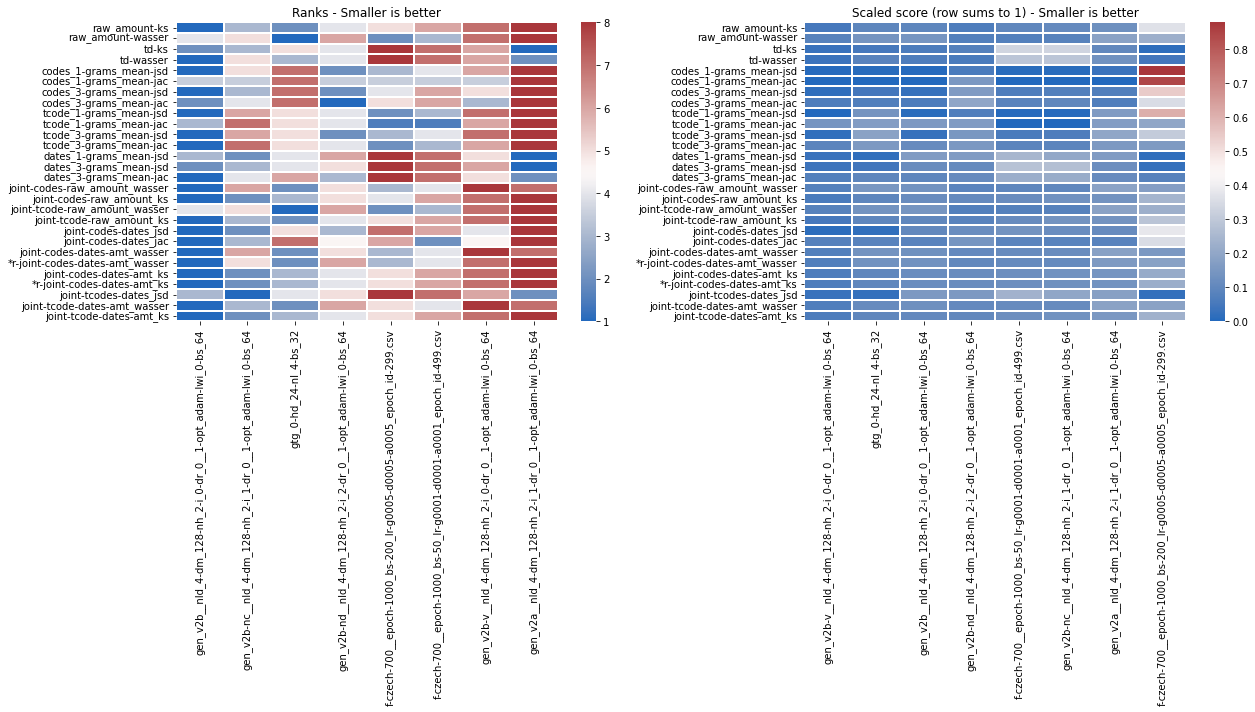

Breaking...


ave_rank                                           filename  \
0  4.250000  h-gen_v2b-nd__nld_4-dm_128-nh_2-i_2-dr_0__1-op...   
1  4.833333  f-czech-700__epoch-1000_bs-50_lr-g0001-d0001-a...   
2  4.250000  gen_v2b-nc__nld_4-dm_128-nh_2-i_1-dr_0__1-opt_...   
3  3.833333               h-gtg_0-hd_24-nl_4-bs_32--len_80.csv   
4  6.166667  h-gen_v2a__nld_4-dm_128-nh_2-i_1-dr_0__1-opt_a...   
5  4.583333  f-czech-700__epoch-1000_bs-200_lr-g0005-d0005-...   
6  1.750000  h-gen_v2b__nld_4-dm_128-nh_2-i_0-dr_0__1-opt_a...   
7  6.333333  h-gen_v2b-v__nld_4-dm_128-nh_2-i_0-dr_0__1-opt...   

                           short_labels_2  big_quality  
0  nd__nld_4-dm_128-nh_--am-lwi_0-bs_64--     4.142857  
1  0__epoch-1000_bs-50_--_epoch_id-499.cs     4.964286  
2  __nld_4-dm_128-nh_2----lwi_0-bs_64--vf     3.875000  
3                  _24-nl_4-bs_32--len_--     4.000000  
4  _nld_4-dm_128-nh_2-i--lwi_0-bs_64--vf1     6.500000  
5  0__epoch-1000_bs-200--5_epoch_id-299.c     4.714286  
6  _nld_4-dm_128-nh_2-i--lwi_0-bs_64--vf1     1.625000  
7  v__nld_4-dm_128-nh_2--m-lwi_0-bs_64--v     6.178571

In [145]:
# col_inds = [use_dataset(x) for x in short_xlabels]
col_inds = [use_dataset(x) for x in x_labels]
use_val_cols = np.array(value_cols)[col_inds].tolist()
# use_xlabels = np.array([clean_fname(x) for x in x_labels])[col_inds]
use_xlabels = np.array([x for x in common_names])[col_inds]

max_show_x = 12

new_result_df = result_df[col_inds].copy()


for k, rows in list(combo_metric_rows.items()) + list(combo_measures_rows.items() ):
    
    inds = np.logical_and(useful_val_rows, rows)
    
    
    
    sub_df_merged = df_merged[inds][use_val_cols].astype(float)
    new_rank_df = sub_df_merged.rank(axis=1)

    
    new_result_df[k] = new_rank_df.mean().to_list()
    
    print("*****", k, "*********")
    
    plot_rank_and_block(sub_df_merged, xlabels = use_xlabels, second_plot="ss", max_show_x = max_show_x)
    
    print("Breaking...")
    break 
    
    
new_result_df.drop(columns=['index'])

In [146]:
new_result_df.sort_values("ave_rank")

index  ave_rank                                           filename  \
6  value_6  1.750000  h-gen_v2b__nld_4-dm_128-nh_2-i_0-dr_0__1-opt_a...   
3  value_3  3.833333               h-gtg_0-hd_24-nl_4-bs_32--len_80.csv   
0  value_0  4.250000  h-gen_v2b-nd__nld_4-dm_128-nh_2-i_2-dr_0__1-op...   
2  value_2  4.250000  gen_v2b-nc__nld_4-dm_128-nh_2-i_1-dr_0__1-opt_...   
5  value_5  4.583333  f-czech-700__epoch-1000_bs-200_lr-g0005-d0005-...   
1  value_1  4.833333  f-czech-700__epoch-1000_bs-50_lr-g0001-d0001-a...   
4  value_4  6.166667  h-gen_v2a__nld_4-dm_128-nh_2-i_1-dr_0__1-opt_a...   
7  value_7  6.333333  h-gen_v2b-v__nld_4-dm_128-nh_2-i_0-dr_0__1-opt...   

                           short_labels_2  big_quality  
6  _nld_4-dm_128-nh_2-i--lwi_0-bs_64--vf1     1.625000  
3                  _24-nl_4-bs_32--len_--     4.000000  
0  nd__nld_4-dm_128-nh_--am-lwi_0-bs_64--     4.142857  
2  __nld_4-dm_128-nh_2----lwi_0-bs_64--vf     3.875000  
5  0__epoch-1000_bs-200--5_epoch_id-299.c     4.714286  
1  0__epoch-1000_bs-50_--_epoch_id-499.cs     4.964286  
4  _nld_4-dm_128-nh_2-i--lwi_0-bs_64--vf1     6.500000  
7  v__nld_4-dm_128-nh_2--m-lwi_0-bs_64--v     6.178571

In [147]:

"h-gen_v2b__nld_4-dm_128-nh_2-i_0-dr_0__1-opt_adam-lwi_0-bs_64--vf1-len_80-v2.csv"



'h-gen_v2b__nld_4-dm_128-nh_2-i_0-dr_0__1-opt_adam-lwi_0-bs_64--vf1-len_80-v2.csv'

In [148]:
def show_full_df(df):
    with pd.option_context('display.max_colwidth', None, "display.max_rows", None, "display.max_columns", None):
        display(df)

In [149]:
show_full_df(new_result_df.sort_values("big_quality"))

index  ave_rank  \
6  value_6  1.750000   
2  value_2  4.250000   
3  value_3  3.833333   
0  value_0  4.250000   
5  value_5  4.583333   
1  value_1  4.833333   
7  value_7  6.333333   
4  value_4  6.166667   

                                                                              filename  \
6     h-gen_v2b__nld_4-dm_128-nh_2-i_0-dr_0__1-opt_adam-lwi_0-bs_64--vf1-len_80-v2.csv   
2   gen_v2b-nc__nld_4-dm_128-nh_2-i_1-dr_0__1-opt_adam-lwi_0-bs_64--vf1-len_100-v2.csv   
3                                                 h-gtg_0-hd_24-nl_4-bs_32--len_80.csv   
0  h-gen_v2b-nd__nld_4-dm_128-nh_2-i_2-dr_0__1-opt_adam-lwi_0-bs_64--vf1-len_80-v2.csv   
5                 f-czech-700__epoch-1000_bs-200_lr-g0005-d0005-a0005_epoch_id-299.csv   
1                  f-czech-700__epoch-1000_bs-50_lr-g0001-d0001-a0001_epoch_id-499.csv   
7   h-gen_v2b-v__nld_4-dm_128-nh_2-i_0-dr_0__1-opt_adam-lwi_0-bs_64--vf1-len_80-v2.csv   
4     h-gen_v2a__nld_4-dm_128-nh_2-i_1-dr_0__1-opt_adam-lwi_0-bs_64--vf1-len_80-v2.csv   

                           short_labels_2  big_quality  
6  _nld_4-dm_128-nh_2-i--lwi_0-bs_64--vf1     1.625000  
2  __nld_4-dm_128-nh_2----lwi_0-bs_64--vf     3.875000  
3                  _24-nl_4-bs_32--len_--     4.000000  
0  nd__nld_4-dm_128-nh_--am-lwi_0-bs_64--     4.142857  
5  0__epoch-1000_bs-200--5_epoch_id-299.c     4.714286  
1  0__epoch-1000_bs-50_--_epoch_id-499.cs     4.964286  
7  v__nld_4-dm_128-nh_2--m-lwi_0-bs_64--v     6.178571  
4  _nld_4-dm_128-nh_2-i--lwi_0-bs_64--vf1     6.500000

In [150]:
9

9

In [151]:
new_result_df["f_prefix"] = new_result_df.filename.apply(lambda x: x.split("nld_")[0].split("-hd_")[0]) 

In [152]:
!pwd

/Users/kylenickerson/Desktop/verafin_proj_big/ecmlkdd/code/metrics-final


In [153]:
'h-gen_v2a__nld_4-dm_128-nh_2-i_1-dr_0__1-opt_adam-lwi_0-bs_64--vf1-len_80-v2.csv'
'h-gen_v2b-nd__nld_4-dm_128-nh_2-i_2-dr_0__1-opt_adam-lwi_0-bs_64--vf1-len_80-v2.csv'
'h-gen_v2b-v__nld_4-dm_128-nh_2-i_0-dr_0__1-opt_adam-lwi_0-bs_64--vf1-len_80-v2.csv'
'h-gen_v2b__nld_4-dm_128-nh_2-i_0-dr_0__1-opt_adam-lwi_0-bs_64--vf1-len_80-v2.csv'
'h-gtg_0-hd_24-nl_4-bs_32--len_80.csv'
'gen_v2b-nc__nld_4-dm_128-nh_2-i_1-dr_0__1-opt_adam-lwi_0-bs_64--vf1-len_100-v2.csv'



'gen_v2b-nc__nld_4-dm_128-nh_2-i_1-dr_0__1-opt_adam-lwi_0-bs_64--vf1-len_100-v2.csv'

In [154]:
cols = "ave_rank	filename	short_labels_2	big_quality	f_prefix".split()
v2b = new_result_df.filename.apply(lambda x: 'v2b' in x)
show_full_df(new_result_df[cols].sort_values(["f_prefix", "big_quality"]).groupby("f_prefix").head(1))

ave_rank  \
5  4.583333   
1  4.833333   
2  4.250000   
4  6.166667   
0  4.250000   
7  6.333333   
6  1.750000   
3  3.833333   

                                                                              filename  \
5                 f-czech-700__epoch-1000_bs-200_lr-g0005-d0005-a0005_epoch_id-299.csv   
1                  f-czech-700__epoch-1000_bs-50_lr-g0001-d0001-a0001_epoch_id-499.csv   
2   gen_v2b-nc__nld_4-dm_128-nh_2-i_1-dr_0__1-opt_adam-lwi_0-bs_64--vf1-len_100-v2.csv   
4     h-gen_v2a__nld_4-dm_128-nh_2-i_1-dr_0__1-opt_adam-lwi_0-bs_64--vf1-len_80-v2.csv   
0  h-gen_v2b-nd__nld_4-dm_128-nh_2-i_2-dr_0__1-opt_adam-lwi_0-bs_64--vf1-len_80-v2.csv   
7   h-gen_v2b-v__nld_4-dm_128-nh_2-i_0-dr_0__1-opt_adam-lwi_0-bs_64--vf1-len_80-v2.csv   
6     h-gen_v2b__nld_4-dm_128-nh_2-i_0-dr_0__1-opt_adam-lwi_0-bs_64--vf1-len_80-v2.csv   
3                                                 h-gtg_0-hd_24-nl_4-bs_32--len_80.csv   

                           short_labels_2  big_quality  \
5  0__epoch-1000_bs-200--5_epoch_id-299.c     4.714286   
1  0__epoch-1000_bs-50_--_epoch_id-499.cs     4.964286   
2  __nld_4-dm_128-nh_2----lwi_0-bs_64--vf     3.875000   
4  _nld_4-dm_128-nh_2-i--lwi_0-bs_64--vf1     6.500000   
0  nd__nld_4-dm_128-nh_--am-lwi_0-bs_64--     4.142857   
7  v__nld_4-dm_128-nh_2--m-lwi_0-bs_64--v     6.178571   
6  _nld_4-dm_128-nh_2-i--lwi_0-bs_64--vf1     1.625000   
3                  _24-nl_4-bs_32--len_--     4.000000   

                                                               f_prefix  
5  f-czech-700__epoch-1000_bs-200_lr-g0005-d0005-a0005_epoch_id-299.csv  
1   f-czech-700__epoch-1000_bs-50_lr-g0001-d0001-a0001_epoch_id-499.csv  
2                                                          gen_v2b-nc__  
4                                                           h-gen_v2a__  
0                                                        h-gen_v2b-nd__  
7                                                         h-gen_v2b-v__  
6                                                           h-gen_v2b__  
3                                                               h-gtg_0

In [155]:
v2b = new_result_df.filename.apply(lambda x: 'v2b' in x)
show_full_df(new_result_df[v2b].sort_values(["f_prefix", "big_quality"]).groupby("f_prefix").head(1))

index  ave_rank  \
2  value_2  4.250000   
0  value_0  4.250000   
7  value_7  6.333333   
6  value_6  1.750000   

                                                                              filename  \
2   gen_v2b-nc__nld_4-dm_128-nh_2-i_1-dr_0__1-opt_adam-lwi_0-bs_64--vf1-len_100-v2.csv   
0  h-gen_v2b-nd__nld_4-dm_128-nh_2-i_2-dr_0__1-opt_adam-lwi_0-bs_64--vf1-len_80-v2.csv   
7   h-gen_v2b-v__nld_4-dm_128-nh_2-i_0-dr_0__1-opt_adam-lwi_0-bs_64--vf1-len_80-v2.csv   
6     h-gen_v2b__nld_4-dm_128-nh_2-i_0-dr_0__1-opt_adam-lwi_0-bs_64--vf1-len_80-v2.csv   

                           short_labels_2  big_quality        f_prefix  
2  __nld_4-dm_128-nh_2----lwi_0-bs_64--vf     3.875000    gen_v2b-nc__  
0  nd__nld_4-dm_128-nh_--am-lwi_0-bs_64--     4.142857  h-gen_v2b-nd__  
7  v__nld_4-dm_128-nh_2--m-lwi_0-bs_64--v     6.178571   h-gen_v2b-v__  
6  _nld_4-dm_128-nh_2-i--lwi_0-bs_64--vf1     1.625000     h-gen_v2b__

In [156]:
v2b = new_result_df.filename.apply(lambda x: 'v2b' in x)
show_full_df(new_result_df[~v2b].sort_values("big_quality"))

index  ave_rank  \
3  value_3  3.833333   
5  value_5  4.583333   
1  value_1  4.833333   
4  value_4  6.166667   

                                                                           filename  \
3                                              h-gtg_0-hd_24-nl_4-bs_32--len_80.csv   
5              f-czech-700__epoch-1000_bs-200_lr-g0005-d0005-a0005_epoch_id-299.csv   
1               f-czech-700__epoch-1000_bs-50_lr-g0001-d0001-a0001_epoch_id-499.csv   
4  h-gen_v2a__nld_4-dm_128-nh_2-i_1-dr_0__1-opt_adam-lwi_0-bs_64--vf1-len_80-v2.csv   

                           short_labels_2  big_quality  \
3                  _24-nl_4-bs_32--len_--     4.000000   
5  0__epoch-1000_bs-200--5_epoch_id-299.c     4.714286   
1  0__epoch-1000_bs-50_--_epoch_id-499.cs     4.964286   
4  _nld_4-dm_128-nh_2-i--lwi_0-bs_64--vf1     6.500000   

                                                               f_prefix  
3                                                               h-gtg_0  
5  f-czech-700__epoch-1000_bs-200_lr-g0005-d0005-a0005_epoch_id-299.csv  
1   f-czech-700__epoch-1000_bs-50_lr-g0001-d0001-a0001_epoch_id-499.csv  
4                                                           h-gen_v2a__

In [157]:
with pd.option_context('display.max_colwidth', None, "display.max_rows", None, "display.max_columns", 25):
    display(new_result_df.sort_values("ave_rank"))

index  ave_rank  \
6  value_6  1.750000   
3  value_3  3.833333   
0  value_0  4.250000   
2  value_2  4.250000   
5  value_5  4.583333   
1  value_1  4.833333   
4  value_4  6.166667   
7  value_7  6.333333   

                                                                              filename  \
6     h-gen_v2b__nld_4-dm_128-nh_2-i_0-dr_0__1-opt_adam-lwi_0-bs_64--vf1-len_80-v2.csv   
3                                                 h-gtg_0-hd_24-nl_4-bs_32--len_80.csv   
0  h-gen_v2b-nd__nld_4-dm_128-nh_2-i_2-dr_0__1-opt_adam-lwi_0-bs_64--vf1-len_80-v2.csv   
2   gen_v2b-nc__nld_4-dm_128-nh_2-i_1-dr_0__1-opt_adam-lwi_0-bs_64--vf1-len_100-v2.csv   
5                 f-czech-700__epoch-1000_bs-200_lr-g0005-d0005-a0005_epoch_id-299.csv   
1                  f-czech-700__epoch-1000_bs-50_lr-g0001-d0001-a0001_epoch_id-499.csv   
4     h-gen_v2a__nld_4-dm_128-nh_2-i_1-dr_0__1-opt_adam-lwi_0-bs_64--vf1-len_80-v2.csv   
7   h-gen_v2b-v__nld_4-dm_128-nh_2-i_0-dr_0__1-opt_adam-lwi_0-bs_64--vf1-len_80-v2.csv   

                           short_labels_2  big_quality  \
6  _nld_4-dm_128-nh_2-i--lwi_0-bs_64--vf1     1.625000   
3                  _24-nl_4-bs_32--len_--     4.000000   
0  nd__nld_4-dm_128-nh_--am-lwi_0-bs_64--     4.142857   
2  __nld_4-dm_128-nh_2----lwi_0-bs_64--vf     3.875000   
5  0__epoch-1000_bs-200--5_epoch_id-299.c     4.714286   
1  0__epoch-1000_bs-50_--_epoch_id-499.cs     4.964286   
4  _nld_4-dm_128-nh_2-i--lwi_0-bs_64--vf1     6.500000   
7  v__nld_4-dm_128-nh_2--m-lwi_0-bs_64--v     6.178571   

                                                               f_prefix  
6                                                           h-gen_v2b__  
3                                                               h-gtg_0  
0                                                        h-gen_v2b-nd__  
2                                                          gen_v2b-nc__  
5  f-czech-700__epoch-1000_bs-200_lr-g0005-d0005-a0005_epoch_id-299.csv  
1   f-czech-700__epoch-1000_bs-50_lr-g0001-d0001-a0001_epoch_id-499.csv  
4                                                           h-gen_v2a__  
7                                                         h-gen_v2b-v__

In [158]:
new_result_df["fname"] = new_result_df["index"].apply(lambda x: fname_map[x])
new_result_df

index  ave_rank                                           filename  \
0  value_0  4.250000  h-gen_v2b-nd__nld_4-dm_128-nh_2-i_2-dr_0__1-op...   
1  value_1  4.833333  f-czech-700__epoch-1000_bs-50_lr-g0001-d0001-a...   
2  value_2  4.250000  gen_v2b-nc__nld_4-dm_128-nh_2-i_1-dr_0__1-opt_...   
3  value_3  3.833333               h-gtg_0-hd_24-nl_4-bs_32--len_80.csv   
4  value_4  6.166667  h-gen_v2a__nld_4-dm_128-nh_2-i_1-dr_0__1-opt_a...   
5  value_5  4.583333  f-czech-700__epoch-1000_bs-200_lr-g0005-d0005-...   
6  value_6  1.750000  h-gen_v2b__nld_4-dm_128-nh_2-i_0-dr_0__1-opt_a...   
7  value_7  6.333333  h-gen_v2b-v__nld_4-dm_128-nh_2-i_0-dr_0__1-opt...   

                           short_labels_2  big_quality  \
0  nd__nld_4-dm_128-nh_--am-lwi_0-bs_64--     4.142857   
1  0__epoch-1000_bs-50_--_epoch_id-499.cs     4.964286   
2  __nld_4-dm_128-nh_2----lwi_0-bs_64--vf     3.875000   
3                  _24-nl_4-bs_32--len_--     4.000000   
4  _nld_4-dm_128-nh_2-i--lwi_0-bs_64--vf1     6.500000   
5  0__epoch-1000_bs-200--5_epoch_id-299.c     4.714286   
6  _nld_4-dm_128-nh_2-i--lwi_0-bs_64--vf1     1.625000   
7  v__nld_4-dm_128-nh_2--m-lwi_0-bs_64--v     6.178571   

                                            f_prefix  \
0                                     h-gen_v2b-nd__   
1  f-czech-700__epoch-1000_bs-50_lr-g0001-d0001-a...   
2                                       gen_v2b-nc__   
3                                            h-gtg_0   
4                                        h-gen_v2a__   
5  f-czech-700__epoch-1000_bs-200_lr-g0005-d0005-...   
6                                        h-gen_v2b__   
7                                      h-gen_v2b-v__   

                                               fname  
0  generated_data/h-gen_v2b-nd__nld_4-dm_128-nh_2...  
1  generated_data/f-czech-700__epoch-1000_bs-50_l...  
2  generated_data/gen_v2b-nc__nld_4-dm_128-nh_2-i...  
3  generated_data/h-gtg_0-hd_24-nl_4-bs_32--len_8...  
4  generated_data/h-gen_v2a__nld_4-dm_128-nh_2-i_...  
5  generated_data/f-czech-700__epoch-1000_bs-200_...  
6  generated_data/h-gen_v2b__nld_4-dm_128-nh_2-i_...  
7  generated_data/h-gen_v2b-v__nld_4-dm_128-nh_2-...

In [159]:
fname_map

{'value_0': 'generated_data/h-gen_v2b-nd__nld_4-dm_128-nh_2-i_2-dr_0__1-opt_adam-lwi_0-bs_64--vf1-len_80-v2.csv',
 'value_1': 'generated_data/f-czech-700__epoch-1000_bs-50_lr-g0001-d0001-a0001_epoch_id-499.csv',
 'value_2': 'generated_data/gen_v2b-nc__nld_4-dm_128-nh_2-i_1-dr_0__1-opt_adam-lwi_0-bs_64--vf1-len_100-v2.csv',
 'value_3': 'generated_data/h-gtg_0-hd_24-nl_4-bs_32--len_80.csv',
 'value_4': 'generated_data/h-gen_v2a__nld_4-dm_128-nh_2-i_1-dr_0__1-opt_adam-lwi_0-bs_64--vf1-len_80-v2.csv',
 'value_5': 'generated_data/f-czech-700__epoch-1000_bs-200_lr-g0005-d0005-a0005_epoch_id-299.csv',
 'value_6': 'generated_data/h-gen_v2b__nld_4-dm_128-nh_2-i_0-dr_0__1-opt_adam-lwi_0-bs_64--vf1-len_80-v2.csv',
 'value_7': 'generated_data/h-gen_v2b-v__nld_4-dm_128-nh_2-i_0-dr_0__1-opt_adam-lwi_0-bs_64--vf1-len_80-v2.csv'}

***** date_metrics--big_quality *********


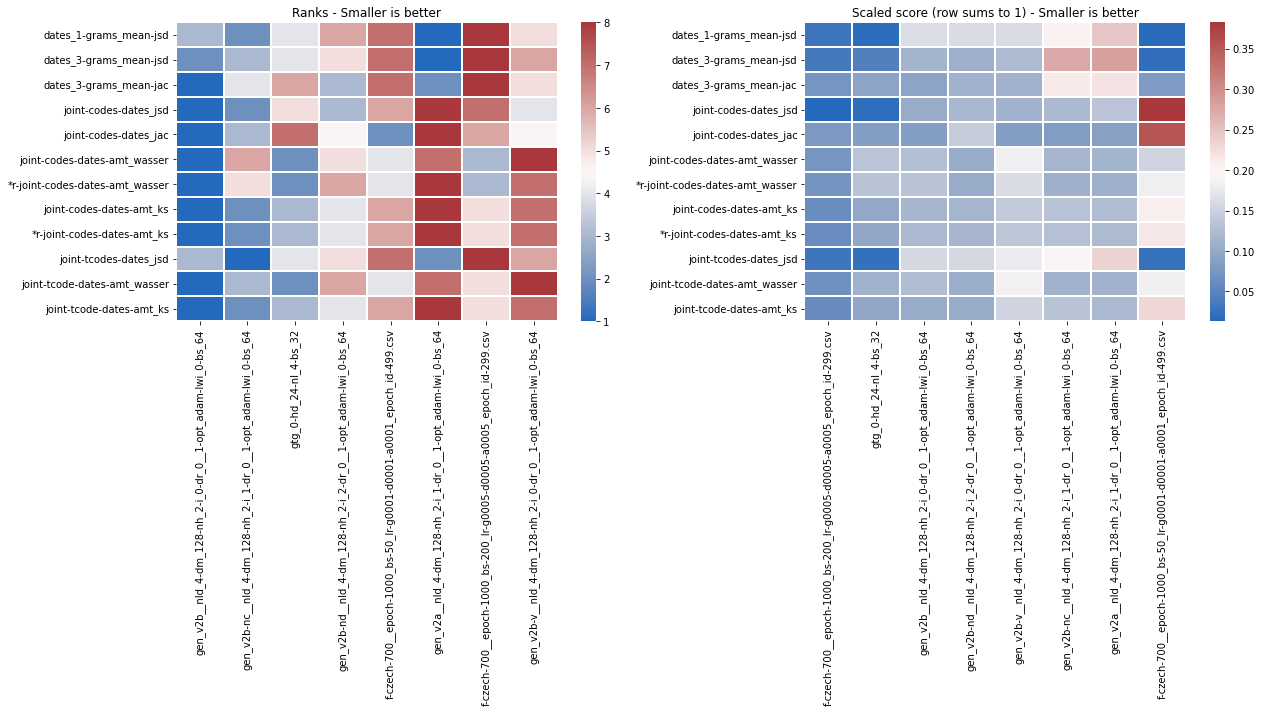

***** date_metrics--small_quality1 *********


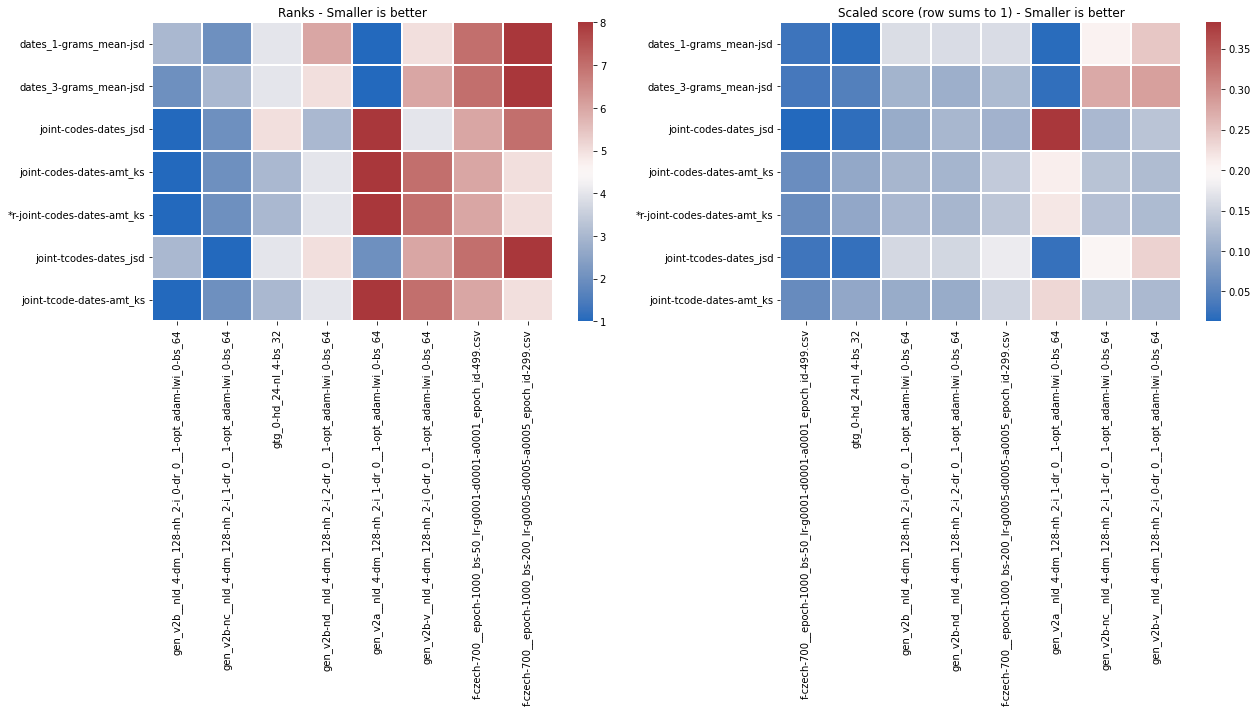

***** date_metrics--small_quality2 *********


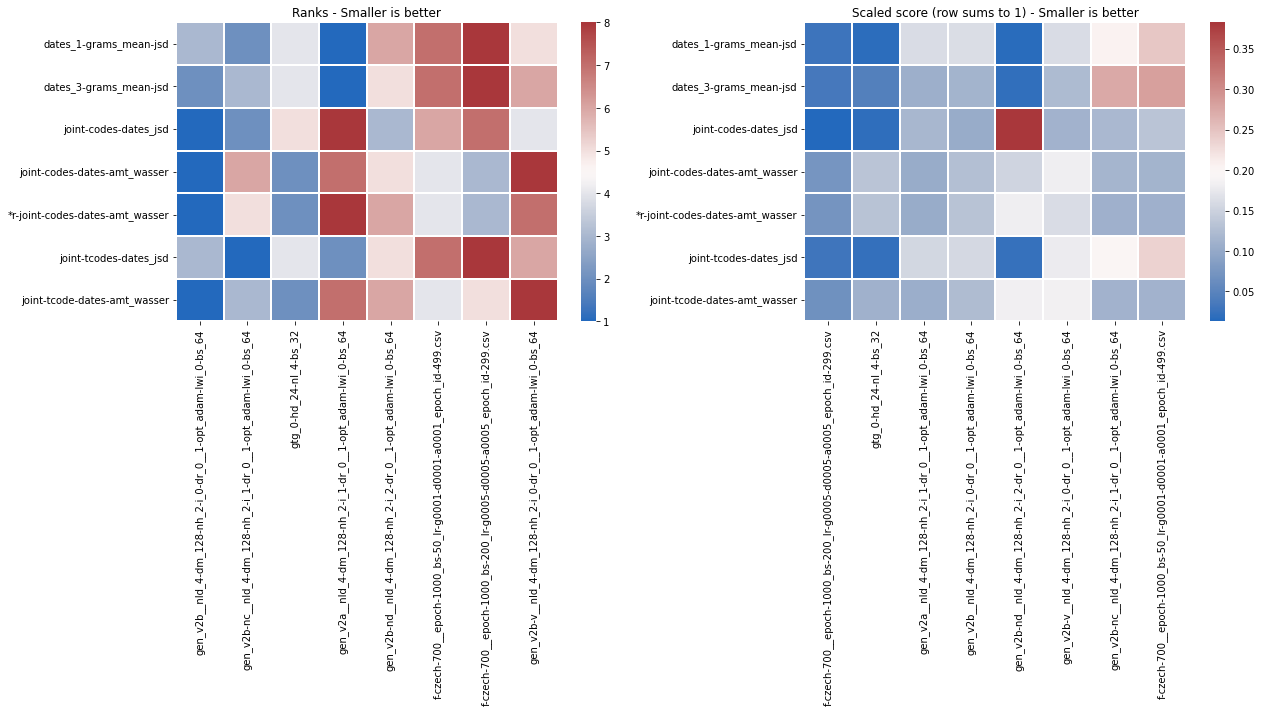

***** date_metrics--coverage_big *********


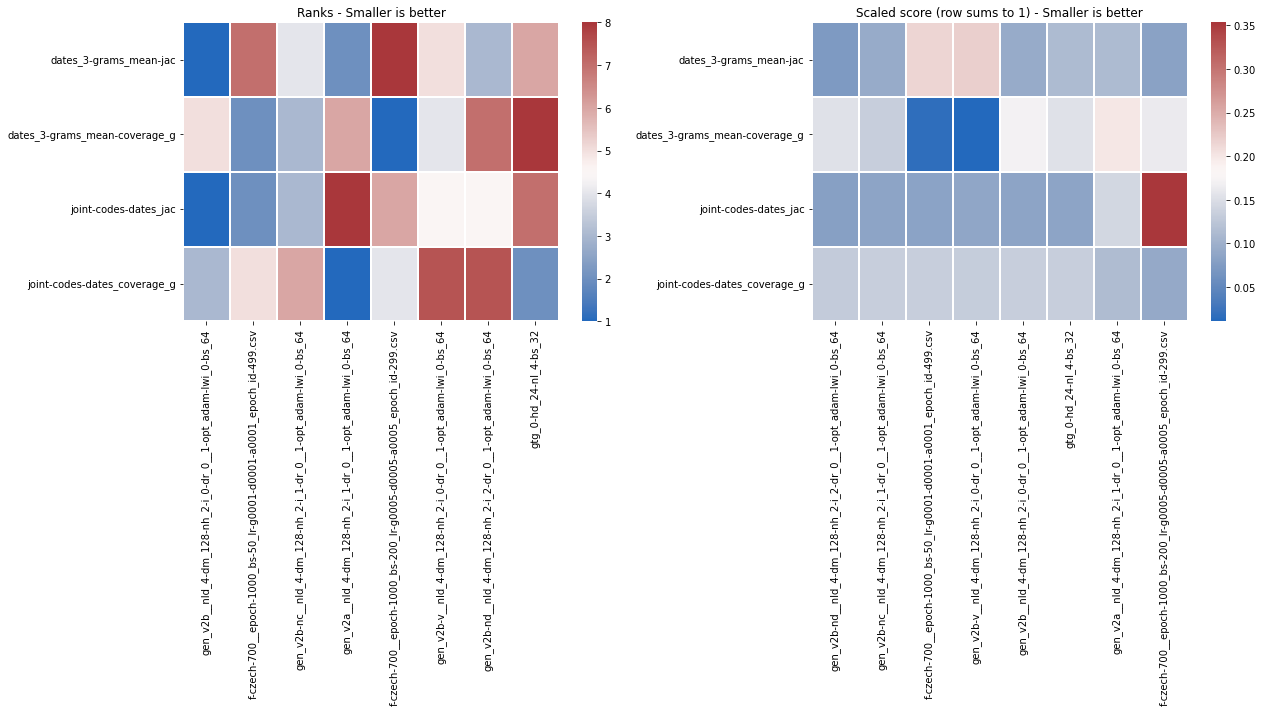

***** date_metrics--coverage_small *********


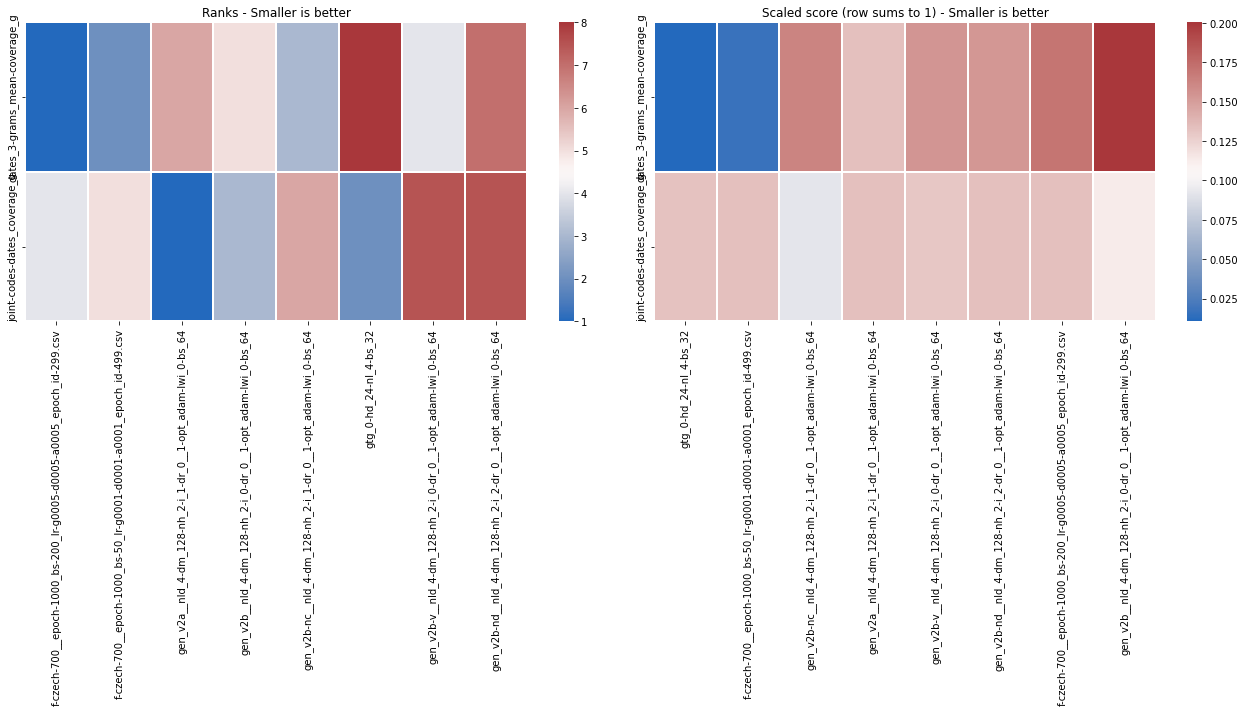

***** one_gram_metrics--big_quality *********


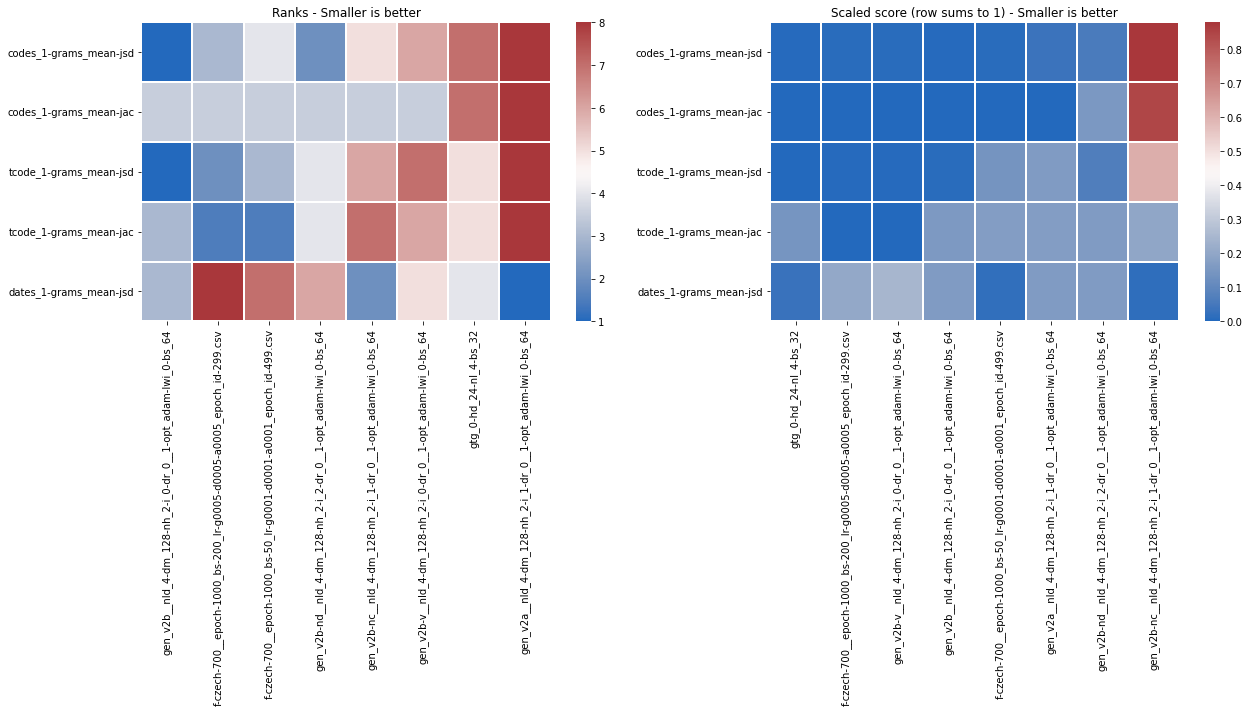

***** one_gram_metrics--small_quality1 *********


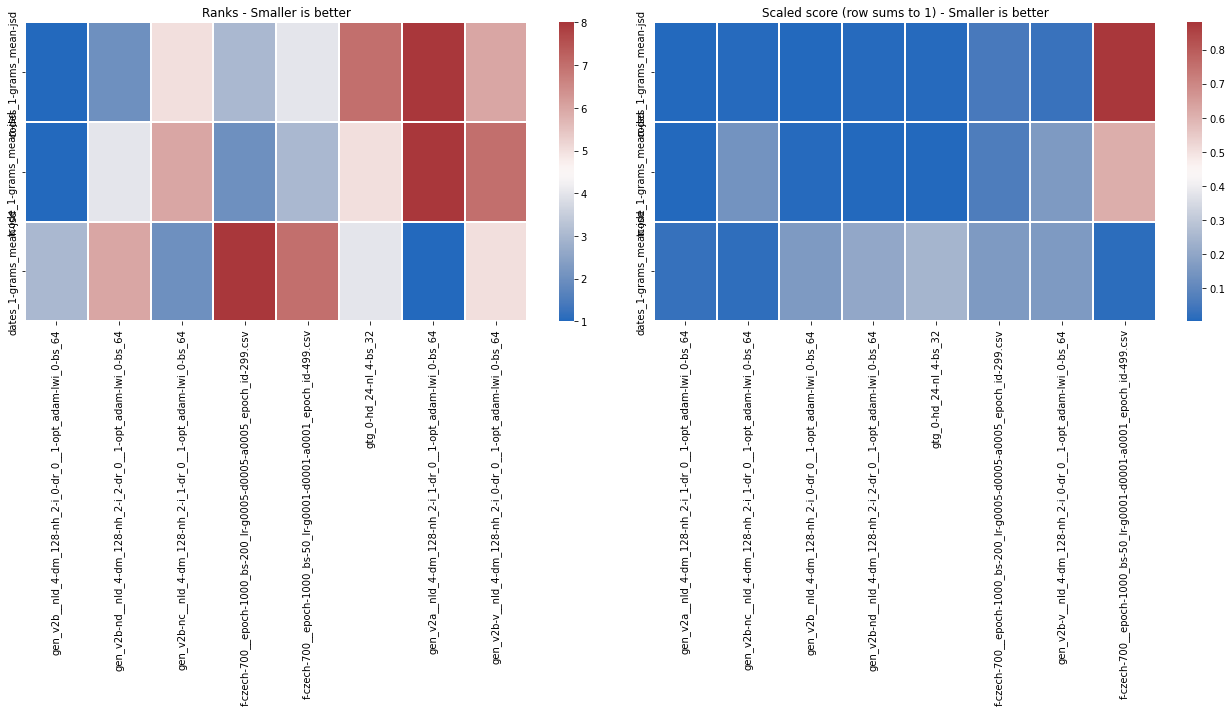

***** one_gram_metrics--small_quality2 *********


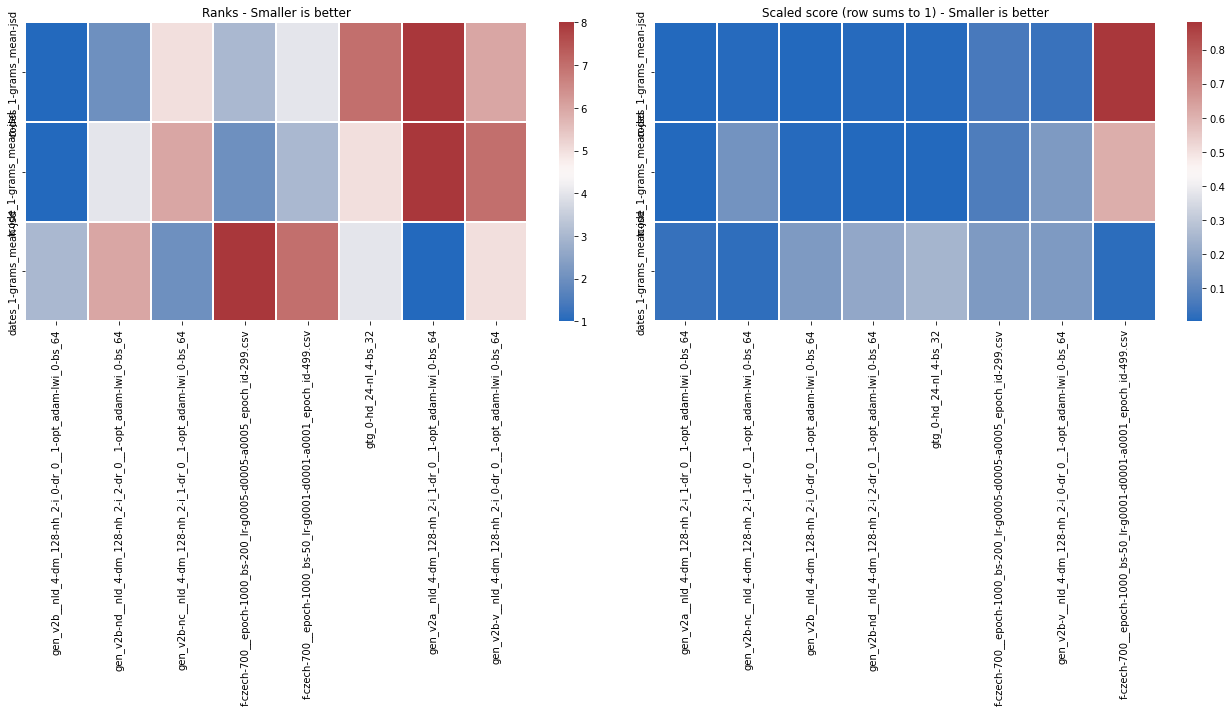

***** one_gram_metrics--coverage_big *********


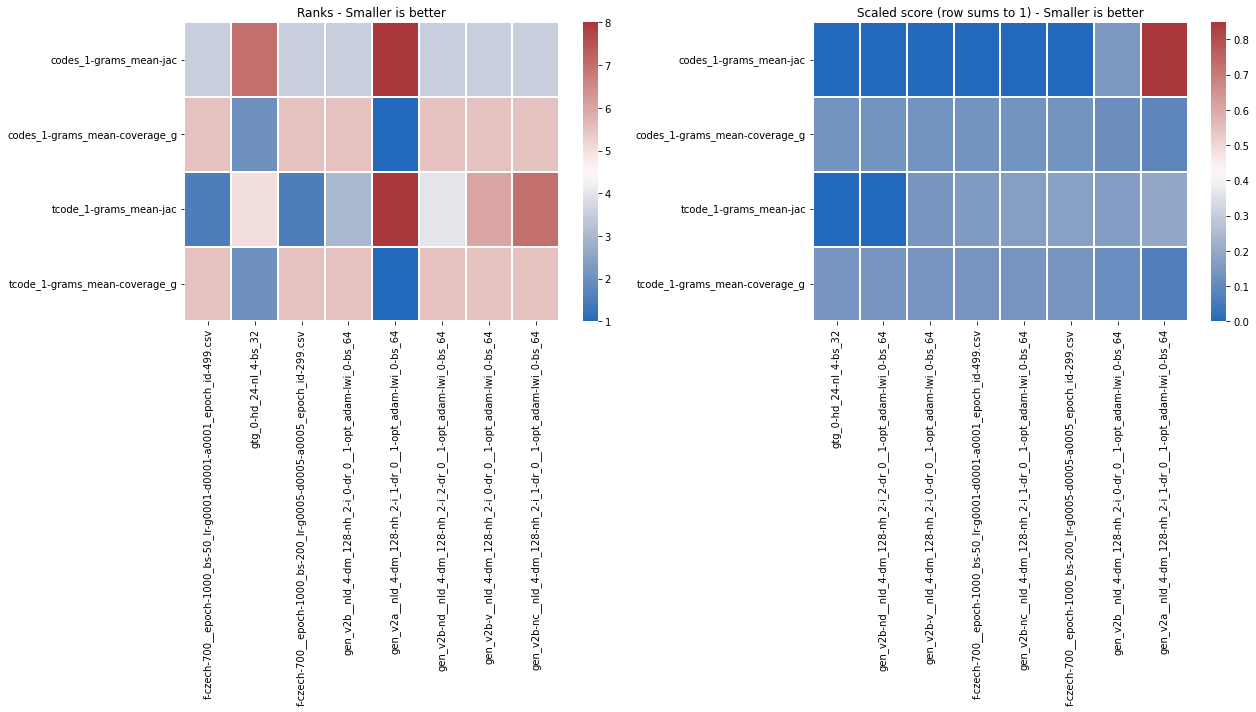

***** one_gram_metrics--coverage_small *********


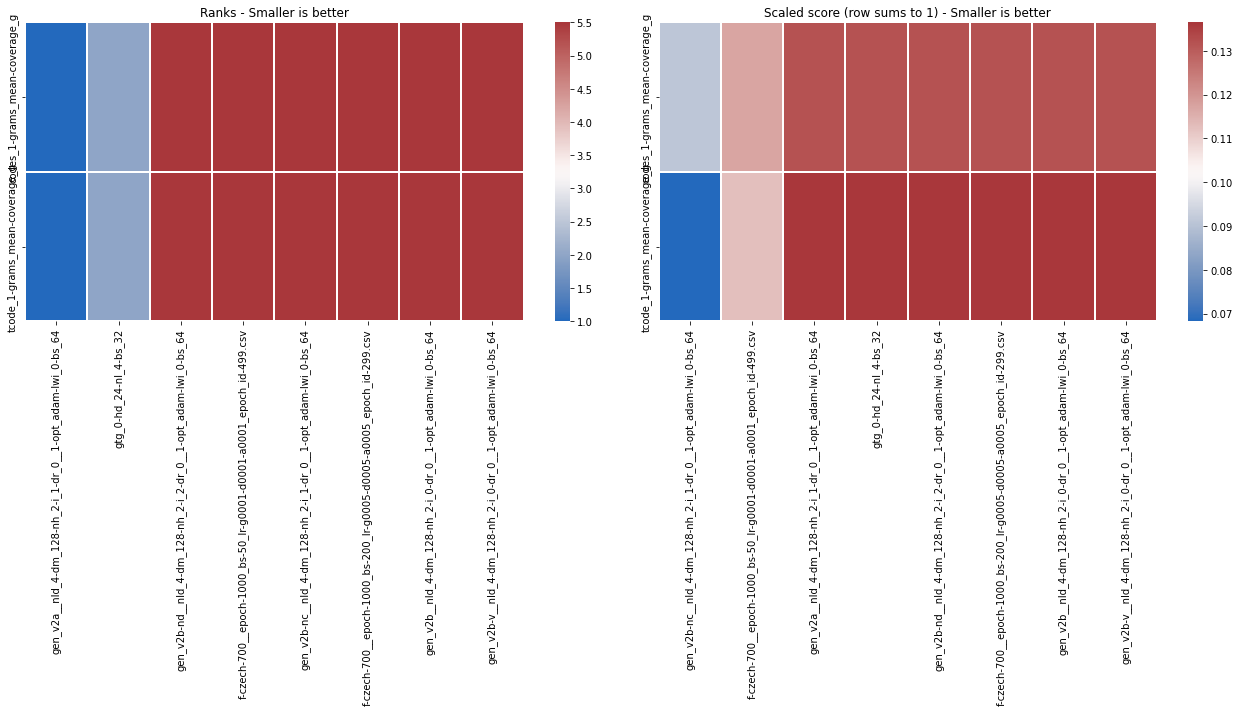

***** three_grams_metrics--big_quality *********


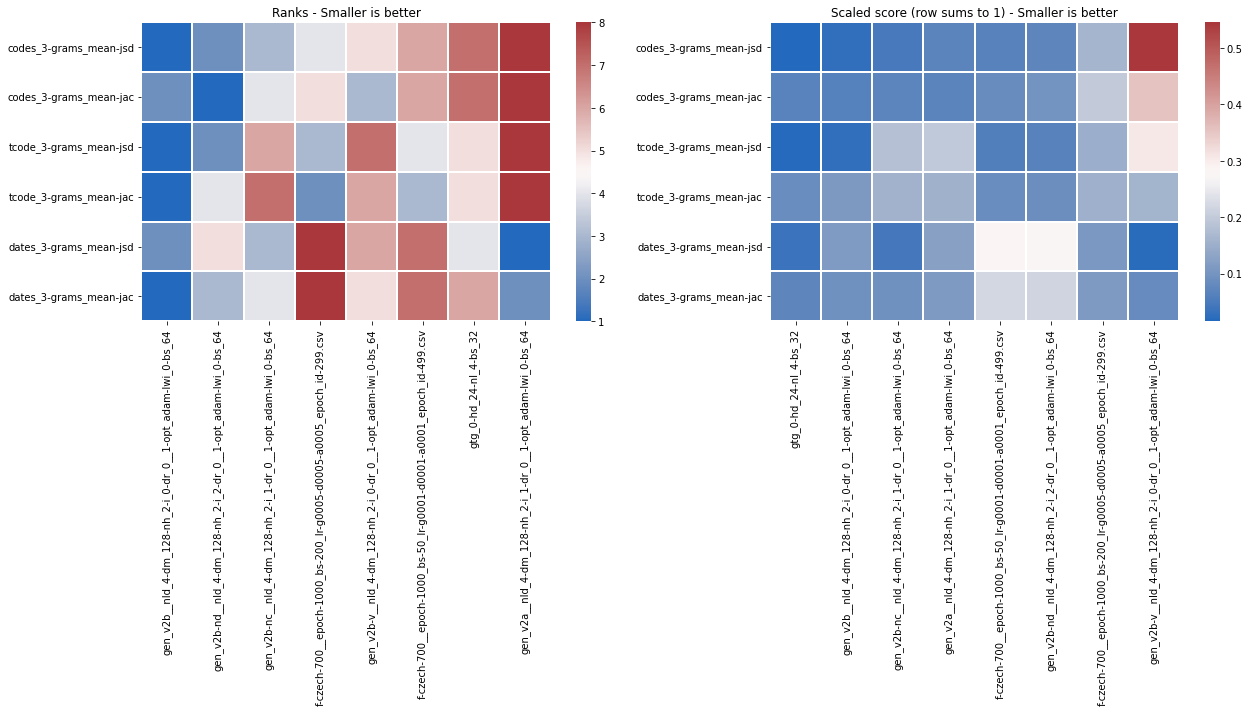

***** three_grams_metrics--small_quality1 *********


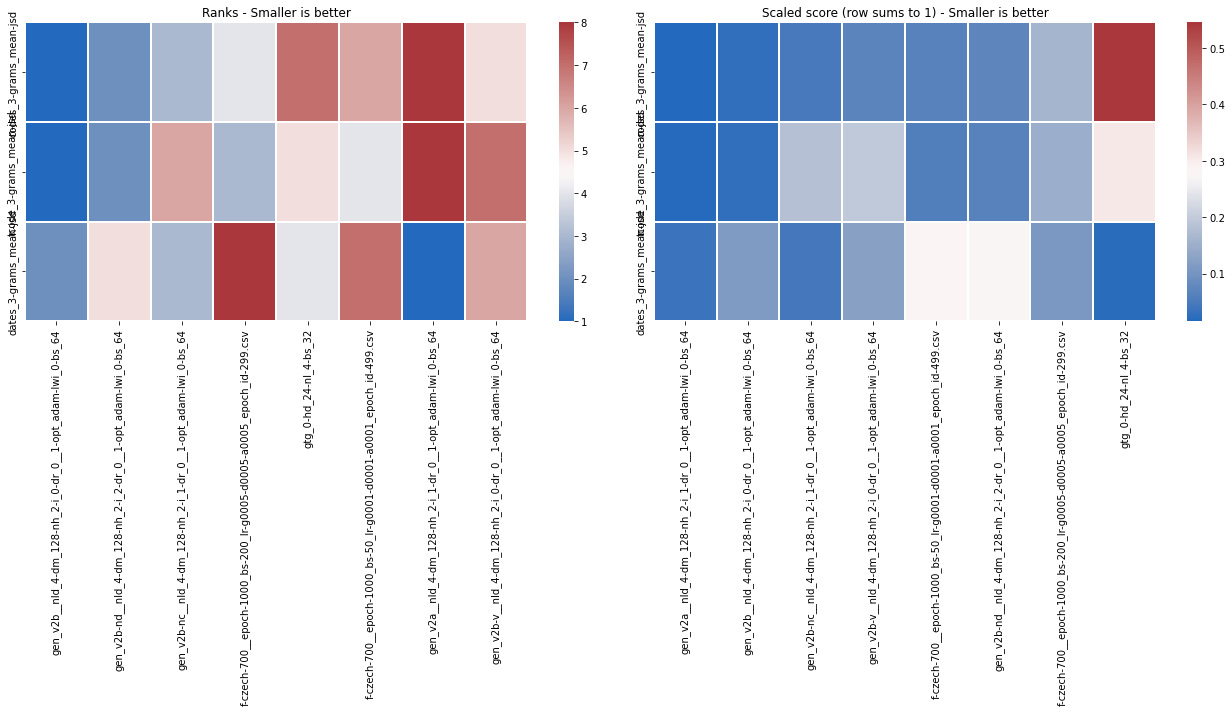

***** three_grams_metrics--small_quality2 *********


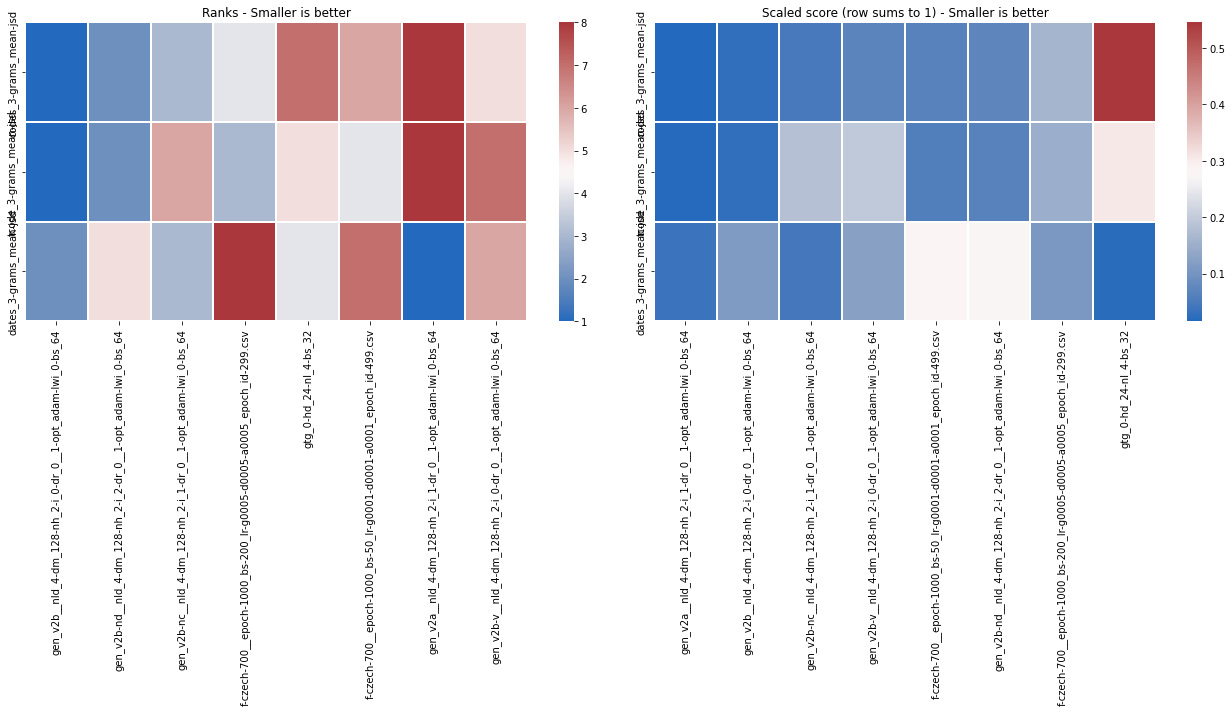

***** three_grams_metrics--coverage_big *********


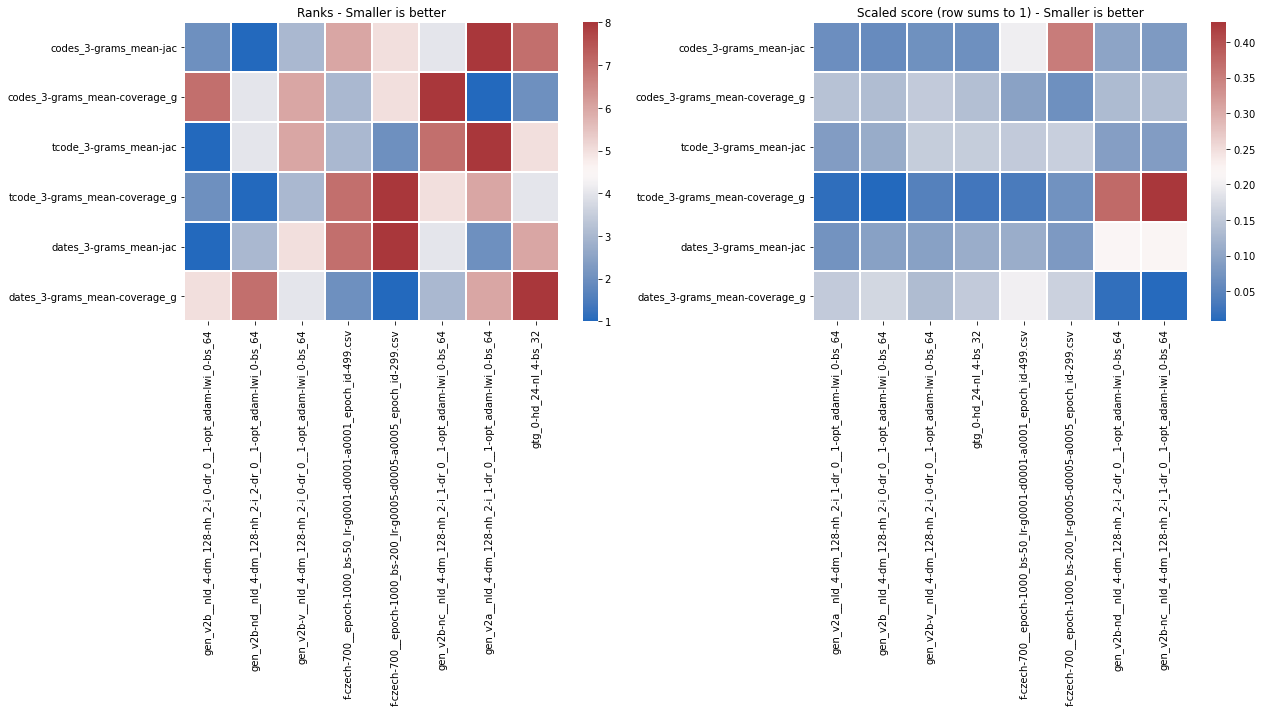

***** three_grams_metrics--coverage_small *********


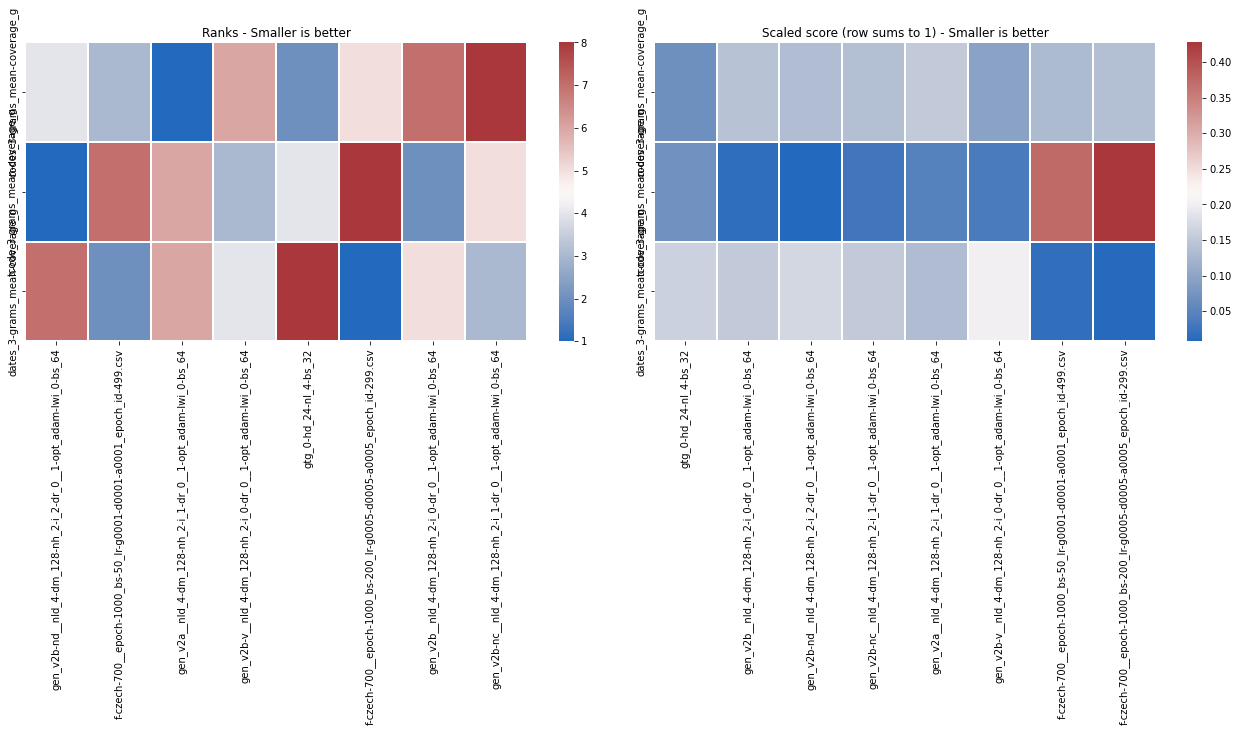

***** joint_metrics--big_quality *********


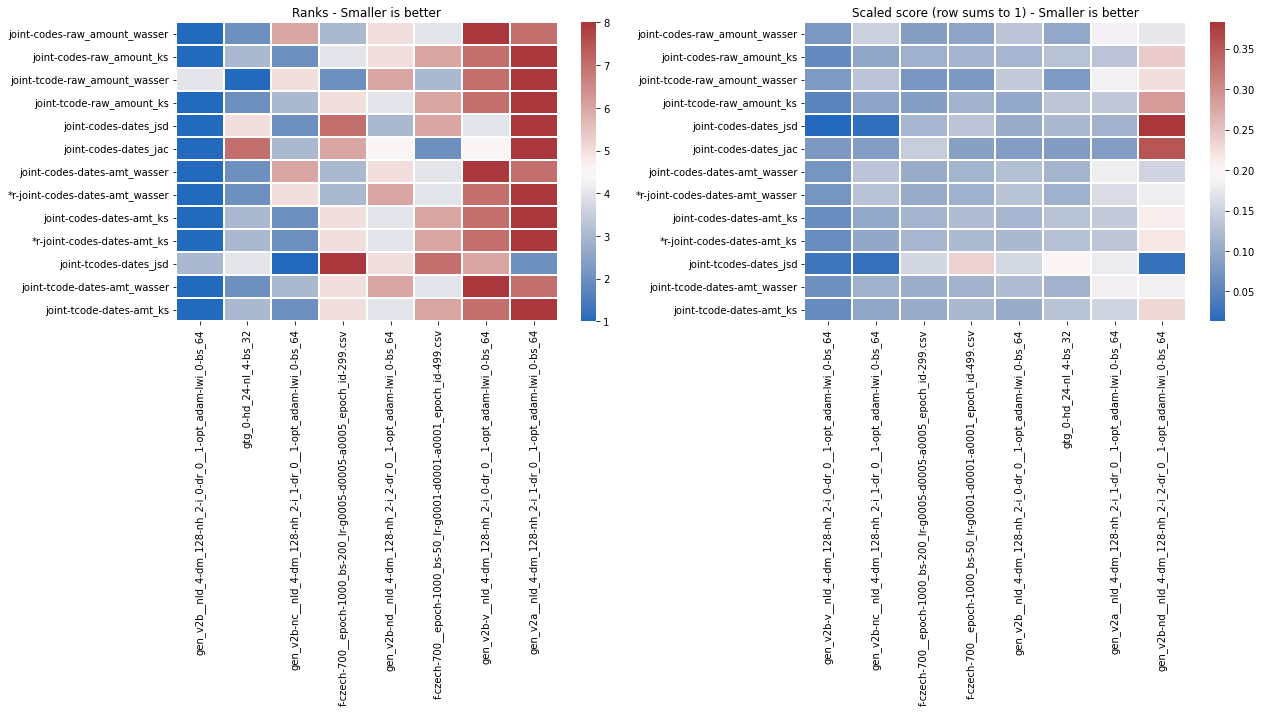

***** joint_metrics--small_quality1 *********


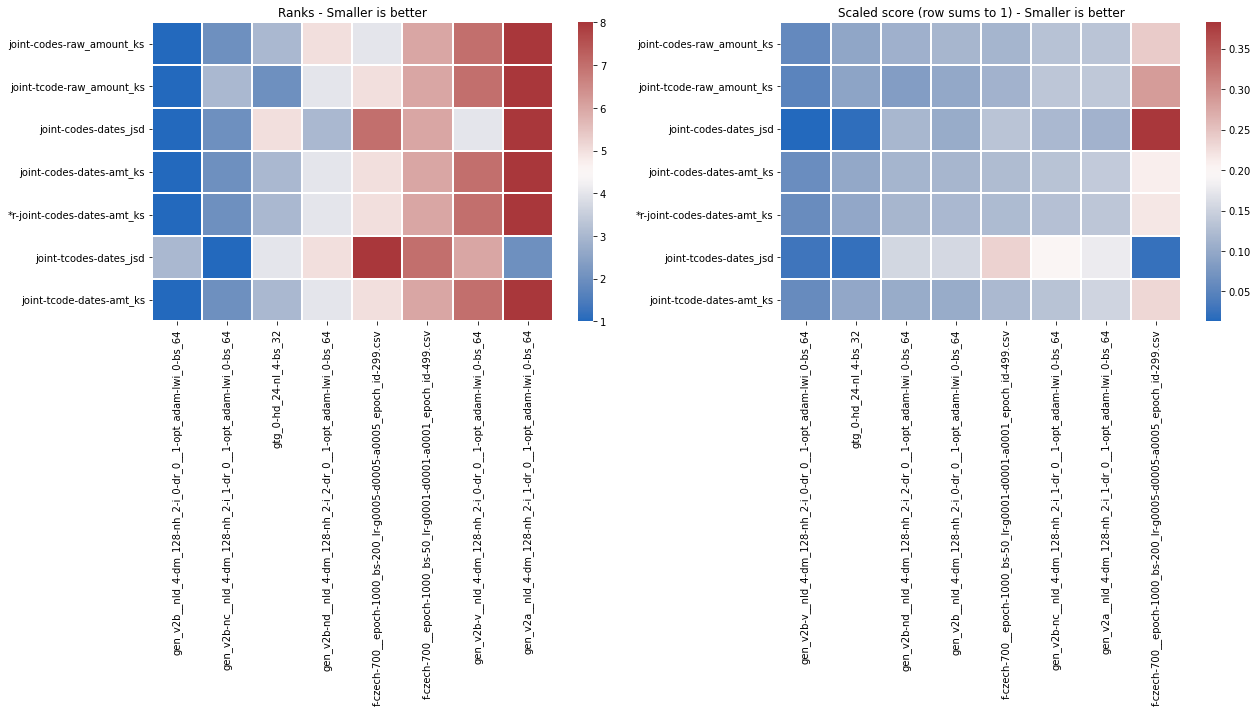

***** joint_metrics--small_quality2 *********


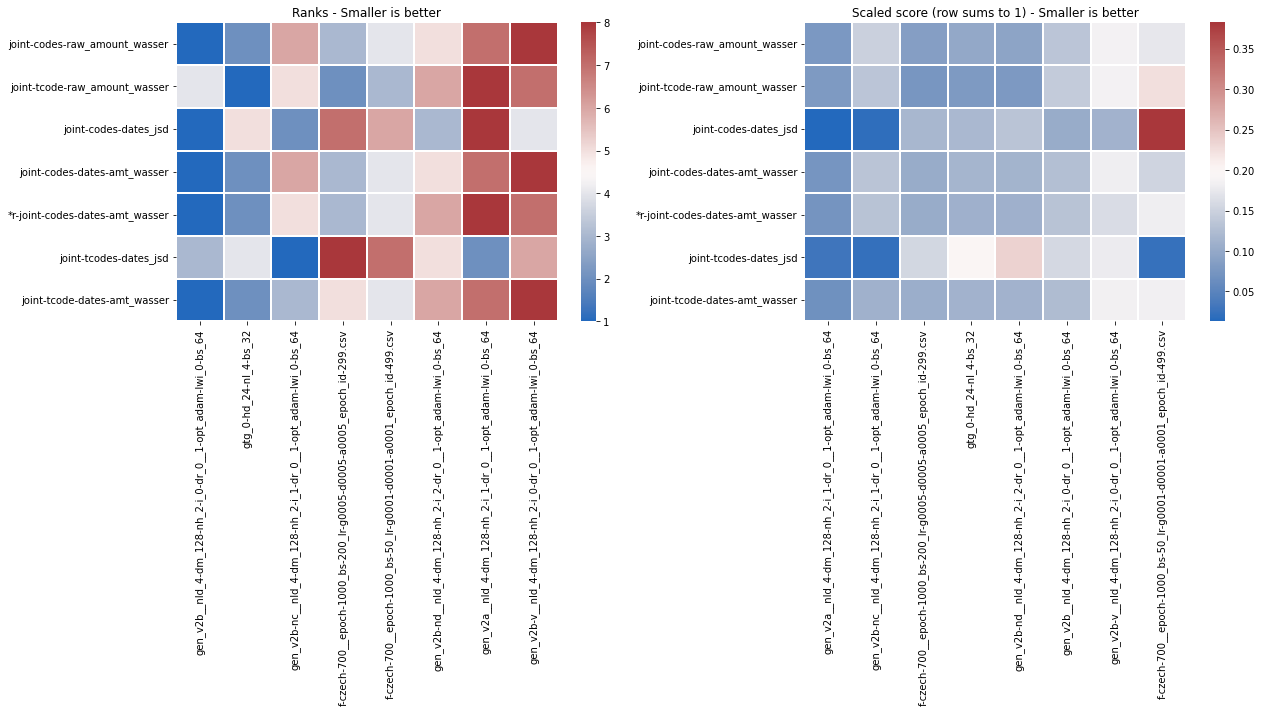

***** joint_metrics--coverage_big *********


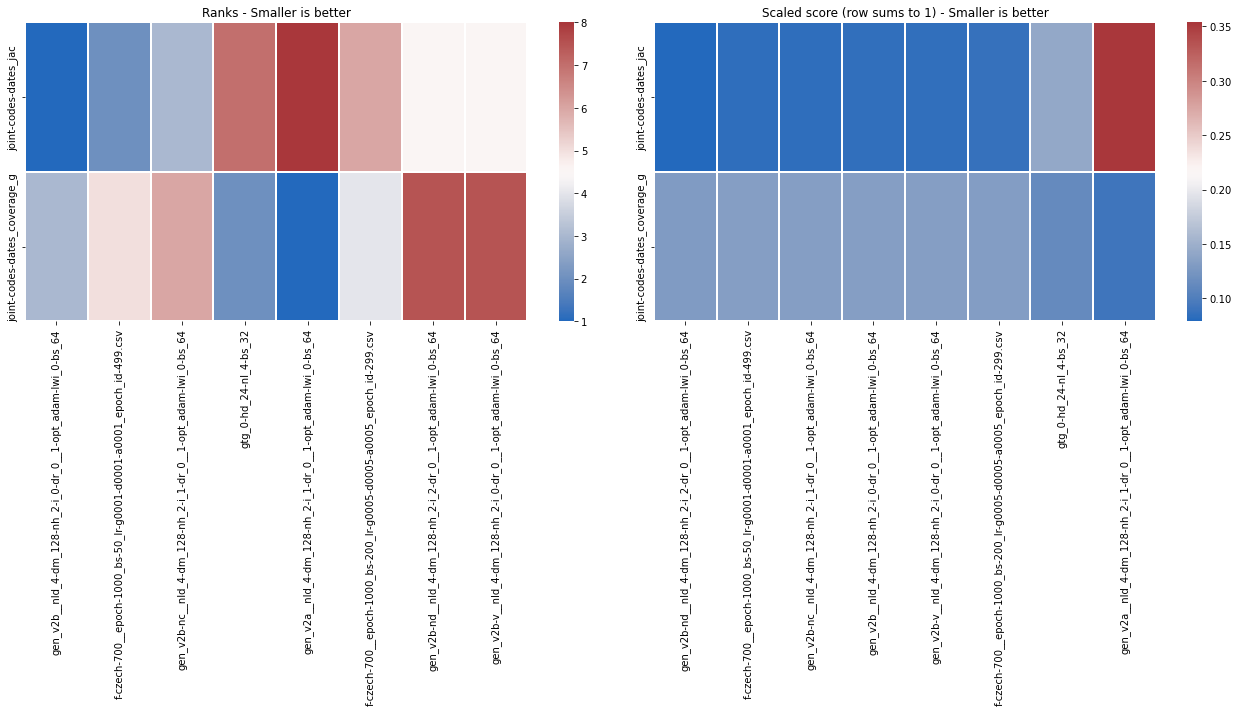

***** joint_metrics--coverage_small *********


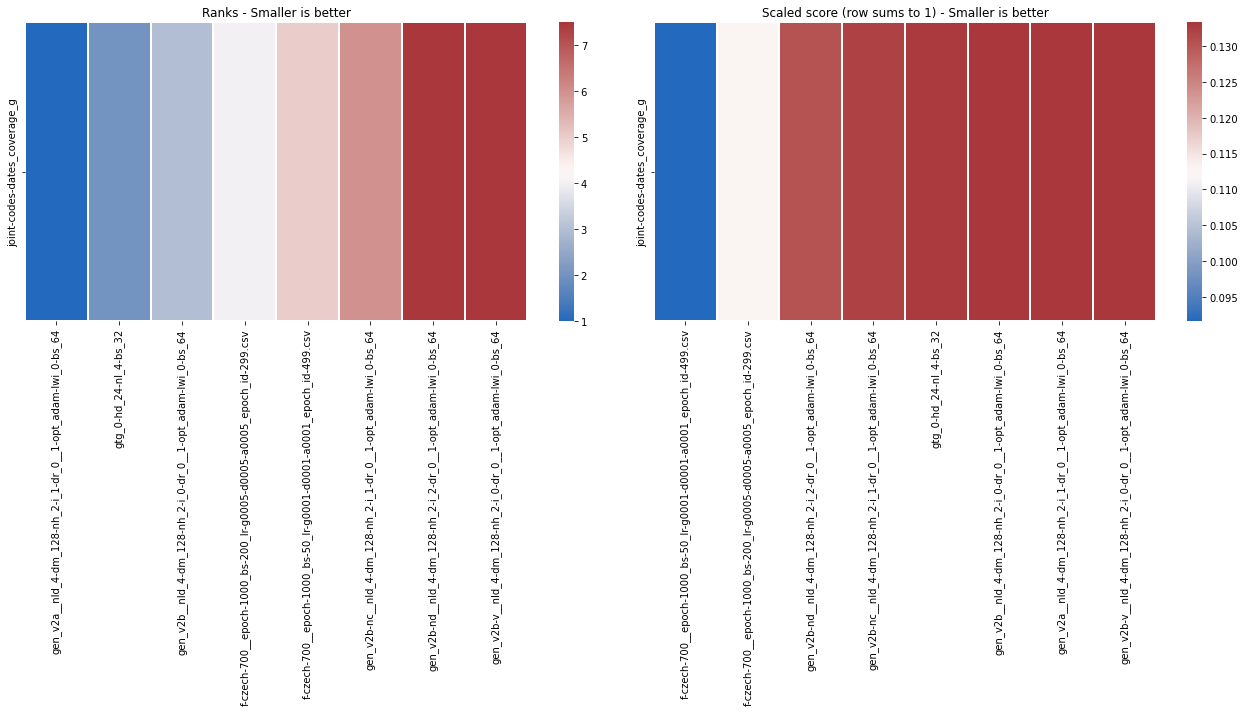

In [160]:
# print("*"*50, "\n"*8, "*"*50, "\nCross of conditions", "\n"*5)


for k_mea, mea_rows in combo_measures_rows.items():
    
    for k_met, met_rows in combo_metric_rows.items():

        inds = np.logical_and(useful_val_rows, mea_rows)
        inds = np.logical_and(inds, met_rows)

        k = f"{k_mea}--{k_met}"
        

        sub_df_merged = df_merged[inds][use_val_cols].astype(float)
        new_rank_df = sub_df_merged.rank(axis=1)


        new_result_df[k] = new_rank_df.mean().to_list()

        print("*****", k, "*********")

        plot_rank_and_block(sub_df_merged, xlabels = use_xlabels, second_plot="ss")



    
    

In [161]:
x_labels[0].split("--")[0] + ".pickle"

'h-gen_v2b-nd__nld_4-dm_128-nh_2-i_2-dr_0__1-opt_adam-lwi_0-bs_64.pickle'

In [162]:
new_result_df = new_result_df.reset_index()

In [163]:
x = new_result_df.filename[2]
x

'gen_v2b-nc__nld_4-dm_128-nh_2-i_1-dr_0__1-opt_adam-lwi_0-bs_64--vf1-len_100-v2.csv'

In [164]:
x.split("__")

['gen_v2b-nc',
 'nld_4-dm_128-nh_2-i_1-dr_0',
 '1-opt_adam-lwi_0-bs_64--vf1-len_100-v2.csv']

In [165]:
x.replace("gen_v2b__", "").split("--")[0].replace('__', '.').split('-')

['gen_v2b',
 'nc.nld_4',
 'dm_128',
 'nh_2',
 'i_1',
 'dr_0.1',
 'opt_adam',
 'lwi_0',
 'bs_64']

In [166]:
[y.split('_') for y in x.replace("gen_v2b__", "").split("--")[0].replace('__', '.').split('-')]

[['gen', 'v2b'],
 ['nc.nld', '4'],
 ['dm', '128'],
 ['nh', '2'],
 ['i', '1'],
 ['dr', '0.1'],
 ['opt', 'adam'],
 ['lwi', '0'],
 ['bs', '64']]

In [167]:
parse_fname = lambda x: dict([try_parse_split(y) for y in x.replace("gen_v2b__", "").split("--")[0].replace('__', '.').split('-')])

In [171]:
with pd.option_context('display.max_colwidth', None, "display.max_rows", None, "display.max_columns", None):
    display(new_result_df.sort_values("ave_rank"))

level_0    index  ave_rank  \
6        6  value_6  1.750000   
3        3  value_3  3.833333   
0        0  value_0  4.250000   
2        2  value_2  4.250000   
5        5  value_5  4.583333   
1        1  value_1  4.833333   
4        4  value_4  6.166667   
7        7  value_7  6.333333   

                                                                              filename  \
6     h-gen_v2b__nld_4-dm_128-nh_2-i_0-dr_0__1-opt_adam-lwi_0-bs_64--vf1-len_80-v2.csv   
3                                                 h-gtg_0-hd_24-nl_4-bs_32--len_80.csv   
0  h-gen_v2b-nd__nld_4-dm_128-nh_2-i_2-dr_0__1-opt_adam-lwi_0-bs_64--vf1-len_80-v2.csv   
2   gen_v2b-nc__nld_4-dm_128-nh_2-i_1-dr_0__1-opt_adam-lwi_0-bs_64--vf1-len_100-v2.csv   
5                 f-czech-700__epoch-1000_bs-200_lr-g0005-d0005-a0005_epoch_id-299.csv   
1                  f-czech-700__epoch-1000_bs-50_lr-g0001-d0001-a0001_epoch_id-499.csv   
4     h-gen_v2a__nld_4-dm_128-nh_2-i_1-dr_0__1-opt_adam-lwi_0-bs_64--vf1-len_80-v2.csv   
7   h-gen_v2b-v__nld_4-dm_128-nh_2-i_0-dr_0__1-opt_adam-lwi_0-bs_64--vf1-len_80-v2.csv   

                           short_labels_2  big_quality  \
6  _nld_4-dm_128-nh_2-i--lwi_0-bs_64--vf1     1.625000   
3                  _24-nl_4-bs_32--len_--     4.000000   
0  nd__nld_4-dm_128-nh_--am-lwi_0-bs_64--     4.142857   
2  __nld_4-dm_128-nh_2----lwi_0-bs_64--vf     3.875000   
5  0__epoch-1000_bs-200--5_epoch_id-299.c     4.714286   
1  0__epoch-1000_bs-50_--_epoch_id-499.cs     4.964286   
4  _nld_4-dm_128-nh_2-i--lwi_0-bs_64--vf1     6.500000   
7  v__nld_4-dm_128-nh_2--m-lwi_0-bs_64--v     6.178571   

                                                               f_prefix  \
6                                                           h-gen_v2b__   
3                                                               h-gtg_0   
0                                                        h-gen_v2b-nd__   
2                                                          gen_v2b-nc__   
5  f-czech-700__epoch-1000_bs-200_lr-g0005-d0005-a0005_epoch_id-299.csv   
1   f-czech-700__epoch-1000_bs-50_lr-g0001-d0001-a0001_epoch_id-499.csv   
4                                                           h-gen_v2a__   
7                                                         h-gen_v2b-v__   

                                                                                                fname  \
6     generated_data/h-gen_v2b__nld_4-dm_128-nh_2-i_0-dr_0__1-opt_adam-lwi_0-bs_64--vf1-len_80-v2.csv   
3                                                 generated_data/h-gtg_0-hd_24-nl_4-bs_32--len_80.csv   
0  generated_data/h-gen_v2b-nd__nld_4-dm_128-nh_2-i_2-dr_0__1-opt_adam-lwi_0-bs_64--vf1-len_80-v2.csv   
2   generated_data/gen_v2b-nc__nld_4-dm_128-nh_2-i_1-dr_0__1-opt_adam-lwi_0-bs_64--vf1-len_100-v2.csv   
5                 generated_data/f-czech-700__epoch-1000_bs-200_lr-g0005-d0005-a0005_epoch_id-299.csv   
1                  generated_data/f-czech-700__epoch-1000_bs-50_lr-g0001-d0001-a0001_epoch_id-499.csv   
4     generated_data/h-gen_v2a__nld_4-dm_128-nh_2-i_1-dr_0__1-opt_adam-lwi_0-bs_64--vf1-len_80-v2.csv   
7   generated_data/h-gen_v2b-v__nld_4-dm_128-nh_2-i_0-dr_0__1-opt_adam-lwi_0-bs_64--vf1-len_80-v2.csv   

   date_metrics--big_quality  date_metrics--small_quality1  \
6                   1.416667                      1.714286   
3                   3.750000                      3.714286   
0                   4.625000                      4.428571   
2                   2.916667                      2.000000   
5                   5.916667                      6.571429   
1                   5.500000                      6.428571   
4                   5.666667                      5.142857   
7                   6.208333                      6.000000   

   date_metrics--small_quality2  date_metrics--coverage_big  \
6                      1.714286                        2.50   
3                      3.285714                        5.75   
0

In [172]:
with pd.option_context('display.max_colwidth', None, "display.max_rows", None, "display.max_columns", None):
    display(new_result_df.sort_values("big_quality"))

level_0    index  ave_rank  \
6        6  value_6  1.750000   
2        2  value_2  4.250000   
3        3  value_3  3.833333   
0        0  value_0  4.250000   
5        5  value_5  4.583333   
1        1  value_1  4.833333   
7        7  value_7  6.333333   
4        4  value_4  6.166667   

                                                                              filename  \
6     h-gen_v2b__nld_4-dm_128-nh_2-i_0-dr_0__1-opt_adam-lwi_0-bs_64--vf1-len_80-v2.csv   
2   gen_v2b-nc__nld_4-dm_128-nh_2-i_1-dr_0__1-opt_adam-lwi_0-bs_64--vf1-len_100-v2.csv   
3                                                 h-gtg_0-hd_24-nl_4-bs_32--len_80.csv   
0  h-gen_v2b-nd__nld_4-dm_128-nh_2-i_2-dr_0__1-opt_adam-lwi_0-bs_64--vf1-len_80-v2.csv   
5                 f-czech-700__epoch-1000_bs-200_lr-g0005-d0005-a0005_epoch_id-299.csv   
1                  f-czech-700__epoch-1000_bs-50_lr-g0001-d0001-a0001_epoch_id-499.csv   
7   h-gen_v2b-v__nld_4-dm_128-nh_2-i_0-dr_0__1-opt_adam-lwi_0-bs_64--vf1-len_80-v2.csv   
4     h-gen_v2a__nld_4-dm_128-nh_2-i_1-dr_0__1-opt_adam-lwi_0-bs_64--vf1-len_80-v2.csv   

                           short_labels_2  big_quality  \
6  _nld_4-dm_128-nh_2-i--lwi_0-bs_64--vf1     1.625000   
2  __nld_4-dm_128-nh_2----lwi_0-bs_64--vf     3.875000   
3                  _24-nl_4-bs_32--len_--     4.000000   
0  nd__nld_4-dm_128-nh_--am-lwi_0-bs_64--     4.142857   
5  0__epoch-1000_bs-200--5_epoch_id-299.c     4.714286   
1  0__epoch-1000_bs-50_--_epoch_id-499.cs     4.964286   
7  v__nld_4-dm_128-nh_2--m-lwi_0-bs_64--v     6.178571   
4  _nld_4-dm_128-nh_2-i--lwi_0-bs_64--vf1     6.500000   

                                                               f_prefix  \
6                                                           h-gen_v2b__   
2                                                          gen_v2b-nc__   
3                                                               h-gtg_0   
0                                                        h-gen_v2b-nd__   
5  f-czech-700__epoch-1000_bs-200_lr-g0005-d0005-a0005_epoch_id-299.csv   
1   f-czech-700__epoch-1000_bs-50_lr-g0001-d0001-a0001_epoch_id-499.csv   
7                                                         h-gen_v2b-v__   
4                                                           h-gen_v2a__   

                                                                                                fname  \
6     generated_data/h-gen_v2b__nld_4-dm_128-nh_2-i_0-dr_0__1-opt_adam-lwi_0-bs_64--vf1-len_80-v2.csv   
2   generated_data/gen_v2b-nc__nld_4-dm_128-nh_2-i_1-dr_0__1-opt_adam-lwi_0-bs_64--vf1-len_100-v2.csv   
3                                                 generated_data/h-gtg_0-hd_24-nl_4-bs_32--len_80.csv   
0  generated_data/h-gen_v2b-nd__nld_4-dm_128-nh_2-i_2-dr_0__1-opt_adam-lwi_0-bs_64--vf1-len_80-v2.csv   
5                 generated_data/f-czech-700__epoch-1000_bs-200_lr-g0005-d0005-a0005_epoch_id-299.csv   
1                  generated_data/f-czech-700__epoch-1000_bs-50_lr-g0001-d0001-a0001_epoch_id-499.csv   
7   generated_data/h-gen_v2b-v__nld_4-dm_128-nh_2-i_0-dr_0__1-opt_adam-lwi_0-bs_64--vf1-len_80-v2.csv   
4     generated_data/h-gen_v2a__nld_4-dm_128-nh_2-i_1-dr_0__1-opt_adam-lwi_0-bs_64--vf1-len_80-v2.csv   

   date_metrics--big_quality  date_metrics--small_quality1  \
6                   1.416667                      1.714286   
2                   2.916667                      2.000000   
3                   3.750000                      3.714286   
0                   4.625000                      4.428571   
5                   5.916667                      6.571429   
1                   5.500000                      6.428571   
7                   6.208333                      6.000000   
4                   5.666667                      5.142857   

   date_metrics--small_quality2  date_metrics--coverage_big  \
6                      1.714286                        2.50   
2                      3.142857                        4.00   
3

In [ ]:
import pickle 

root_dir = "../banksformer_v2b/training_history/"


final_fits = []
condition = root_dir.split("/")[1]
names = []
fit_times = []

for csv_fname in x_labels:
    
    # if ".pickle" in fname:
    pickle_fname = csv_fname.split("--")[0][4:] + ".pickle"
        
    with open(f"{root_dir}{pickle_fname}", "rb") as f:
        data =  pickle.load(f) 

    final_fits.append(data["val_loss"][-1].numpy())
    # names.append(fname.split(".")[0])
    names.append(pickle_fname.split(".")[0])
    
    try:
        fit_times.append(data['fit_time'])
    except:
        print("No fit time for", pickle_fname)
        fit_times.append(-1)

            
loss_types = [x.split("-")[-2].split("_")[1] for x in names]


In [ ]:
loss_types

In [ ]:
data['fit_time']

In [ ]:
result_df

In [ ]:
names

In [ ]:
rdf2 = result_df.drop(columns=['filename', 'short_labels_2'])
 
    
for f in ['final_fits', 'names', 'loss_types', 'fit_times']:
    rdf2[f] = eval(f)


rdf2

In [ ]:
rdf2.loss_types.factorize()

In [ ]:
plt.scatter(rdf2.ave_rank, rdf2.final_fits, c=rdf2.loss_types.factorize()[0])
plt.colorbar()
plt.xlabel("Ave rank")
plt.ylabel("Val loss")
plt.show()

In [ ]:
plt.scatter(rdf2.ave_rank, rdf2.fit_times, c=rdf2.loss_types.factorize()[0])
plt.colorbar()
plt.xlabel("Ave rank")
plt.ylabel("Fit time")
plt.show()

In [ ]:
x_labels[0].split("--")[0][4:] + ".pickle" in os.listdir("../banksformer_v2b/training_history/")

In [ ]:
x_labels[0].split("--")[0][4:] + ".pickle"

In [ ]:
fname

In [ ]:
k = 3

In [ ]:
block_ranks = new_rank_df.copy()

best_vals = block_ranks <= k
worst_vals = block_ranks > len(value_cols) - k
mid_vals = ~np.logical_or(best_vals, worst_vals)


block_ranks[best_vals] = 100
block_ranks[worst_vals] = 0
block_ranks[mid_vals] = 50

block_ranks

In [ ]:
full_vals_df["index"][inds]

In [ ]:
plt.figure(figsize=(10,10))
short_xlabels = [x[:12] for x in x_labels]
sns.heatmap(block_ranks, linewidths=0.1, xticklabels=short_xlabels, 
            yticklabels=full_vals_df["index"][inds], cmap=sns.color_palette("vlag_r", as_cmap=True))
plt.xticks(rotation=270)
plt.title(f"Block ranks - Bigger is better")
plt.show()

In [ ]:
plt.figure(figsize=(10,10))
short_xlabels = [x[:12] for x in x_labels]
sns.heatmap(new_rank_df, linewidths=0.1, xticklabels=short_xlabels, 
            yticklabels=full_vals_df["index"][inds], cmap=sns.color_palette("vlag_r", as_cmap=True))
plt.xticks(rotation=270)
plt.title(f"Ranks - Smaller is better")
plt.show()

In [ ]:
fig, ax = plt.subplots(1,2 ,figsize=(18, 10))

short_xlabels = [x[:12] for x in x_labels]




sns.heatmap(new_rank_df, linewidths=0.1, xticklabels=short_xlabels, 
            yticklabels=full_vals_df["index"][inds], cmap=sns.color_palette("vlag", as_cmap=True), ax=ax[1])

ax[0].set_title(f"Ranks - Smaller is better")


sns.heatmap(block_ranks, linewidths=0.1, xticklabels=short_xlabels, 
            yticklabels=full_vals_df["index"][inds], cmap=sns.color_palette("vlag_r", as_cmap=True), ax=ax[0])

ax[1].set_title(f"Block ranks - Bigger is better")

# plt.xticks(rotation=270)
plt.tight_layout()
plt.show()